In [1]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from IPython.core.debugger import set_trace
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import networkx as nx

In [2]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [3]:
client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)
client.materialize.get_tables()

['soma_jan2022',
 'wing_motor_neuron_table_v0',
 'synapses_nov2022',
 'proofread_second_pass',
 'motor_neuron_table_v7',
 'cell_ids',
 'wing_premotor_v4',
 'somas_dec2022',
 'upstream_feco_axons',
 'nucleus_mar2022',
 'proofreading_status_jasper',
 'neuron_somas_dec2022',
 'downstream_feco_axons_v1',
 'synapse_regions_v1',
 'topo_23b_table_v0',
 'downstream_10b_table_v0',
 'downstream_hair_plate_axon_table_v0',
 'proofread_by_andrewcook',
 'glia_somas_dec2022',
 'grooming_command_like_neurons_v1',
 'peripheral_nerves',
 'feco_axons_v0',
 'gustatory_downstream_t1l',
 'upstream_hair_plate_axon_table_v0',
 'sensory_admn_left',
 'left_t1_local_premotor_table_v5',
 'legcs_axons',
 'neck_connective',
 'neuron_information',
 'abdominal_sensory_axon_table_v0',
 'neurotransmitter_hemilineage_table',
 'left_t1_local_premotor_table_v6',
 'downstream_feco_axons_v0',
 'hair_plate_table',
 'downstream_bristle_table_v0',
 'bristle_axon_table',
 'right_to_left_t1_mn_bound2tag_v0',
 'all_leg_motor_neur

## Functions

In [4]:
def get_clustered_order(sim_mat, distance_threshold = 0, 
                       n_clusters = None, **kwargs):
    
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None).fit(sim_mat)
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    
    parsed_order = []
    for c in clustered_order:
        if '(' in c:
            c = c.split('(')[1]
            c = c.split(')')[0]
        parsed_order.append(int(c))
    
    return parsed_order

def connectivity_sort(edge, reverted=False):
    # pre and post pt_root_ids list
    if reverted:
        pre = edge.post_pt_root_id.unique().tolist()
        post = edge.pre_pt_root_id.unique().tolist()
    else:
        
        pre = edge.pre_pt_root_id.unique().tolist()
        post = edge.post_pt_root_id.unique().tolist()
    # initialize conn_mat with length of pre and post pt_root_ids
    conn_mat = np.zeros((len(pre),len(post)))
    print(conn_mat.shape)

    # enumerate every pre_pt_root_id in pre list
    for ix, i in enumerate(pre):
        # locates rows with pre_pt_root_id as such
        subset = edge[edge.pre_pt_root_id == i]

        for jx, j in enumerate(post):
            if j in subset.post_pt_root_id.tolist():
                c = subset[subset.post_pt_root_id==j]['count'].tolist()[0]
                conn_mat[ix,jx] = c
    sim_mat = cosine_similarity(conn_mat)
    clustered_order = get_clustered_order(sim_mat)

    ids_ordered = [pre[i] for i in clustered_order]
    ids_order_map = dict(zip(ids_ordered,[i for i in range(len(ids_ordered))]))

#     gust_only_edge['pre_order'] = gust_only_edge['pre_pt_root_id'].map(ids_order_map)
#     gust_only_edge['post_order'] = gust_only_edge['post_pt_root_id'].map(ids_order_map)
    return ids_order_map, conn_mat, clustered_order

# convert into microns
def convert_to_microns(col, voxel_size=[4.3,4.3,45]):
    return np.vstack(col.values)*voxel_size/1000

def plot_entire(df, title, hue):
    # setting up size and axis handle for plot
    a4_dims = (15, 10)
    fig, ax = pyplot.subplots(1,2,figsize=a4_dims)
    # plots synapses with seaborn module based on classification systems
    syn_pos = convert_to_microns(df['pre_pt_position'])
    x = syn_pos[:, 0]
    y = syn_pos[:, 1]
    z = syn_pos[:, 2]
    sns.scatterplot(x=x, y=y, hue=hue,legend=False,palette='Set2', ax=ax[0]).set_title(title)
    ax[0].set_xlim(30, 180)
    ax[0].set_ylim(400, 520)
    ax[0].set_aspect('equal')
    ax[0].set_xlabel('x (um)')
    ax[0].set_ylabel('y (um)')
    sns.scatterplot(x=x, y=z, hue=hue,legend='auto',palette='Set2', ax=ax[1]).set_title(title)
    ax[1].set_xlim(30, 170)
    ax[1].set_ylim(105, 180)
    ax[1].set_aspect('equal')
    ax[1].set_xlabel('x (um)')
    ax[1].set_ylabel('z (um)')
    plt.legend(loc = 2, bbox_to_anchor = (1,1))
    return syn_pos

def classify_clusters(data, rnge, clss, dct):
    dct = dct
    for i in rnge:
        dct[data[i]] = clss
    return dct

def histplot_classes(df, hue,title, hue_order=None, x='post_order'):
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(1,1,1)
    sns.histplot(data=df, x=x, hue=hue, hue_order=hue_order,
                palette="Paired", multiple='layer', bins=102).set_title(title)
    ax.set_ylim(0, 35)

    sns.move_legend(ax, "upper right",frameon=False,bbox_to_anchor=(1.15, 1))

In [5]:
%matplotlib inline
# tot_df is of order and count column only and comprises ALL the counts
# label_df is of order and count column only and comprises parts of counts
def get_full_axon_df(tot_df, label_df, groupby='order'):
    lst = [i for i in range(tot_df.shape[0])]
    dct2 = dict(zip(label_df[groupby], label_df['count']))
    dct1 = {lst[i]: 0 for i in range(len(lst))}
    dct1.update(dct2)
    keys = list(dct1.keys())
    vals = list(dct1.values())
    new_dct = {groupby:keys, 'count':vals}
    df = pd.DataFrame(data=new_dct)
    return df

def get_count_synapse(df, tot, column='label', test='upstream', groupby='order'):
    if isinstance(test, str):
        up = df[df[column]==test].groupby(groupby)['count'].sum().reset_index()
        up = get_full_axon_df(tot, up, groupby=groupby[0])
    else:
        up = df[df[column].isna()].groupby(groupby)['count'].sum().reset_index()
        up = get_full_axon_df(tot, up, groupby=groupby[0])
    return up

def get_count_by_proportionality(df, test, df_groupby_total, label, column='label', groupby='order'):
    df_portion = get_count_synapse(df, df_groupby_total, test=test, column=column, groupby=groupby)
    df_portion['count'] = [i / j * 100 for i,j in zip(df_portion['count'], df_groupby_total['count'])]
    df_portion.name = str(label);
    return df_portion

def plot_percent_stacked_bar(total, args, x='order', only=[]):
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(1,1,1)
    bottom = [0 for i in range(total.shape[0])]
    if len(only) != 0:
        for arg in args:
            if arg.name in only:
                ax.bar(arg[x], arg['count'], bottom=bottom, edgecolor='white', label=arg.name)
                bottom = [i+j for i,j in zip(bottom, arg['count'])]
            else:    
                ax.bar(arg[x], arg['count'], color='#808080', bottom=bottom, edgecolor='white')
                bottom = [i+j for i,j in zip(bottom, arg['count'])]
    else:
        for arg in args:
            ax.bar(arg[x], arg['count'], bottom=bottom, edgecolor='white', label=arg.name)
            bottom = [i+j for i,j in zip(bottom, arg['count'])]
    plt.legend(loc='lower right', bbox_to_anchor=(1,1), ncol=1, prop={"size":20})
    
# master_df (df for short) needs count of synapse column ('count') and order/bristle/pt_root_id of interest to groupby
# column is the column's name of the hue by which the bar chart is plotted
# groupby is the order/bristle/pt_root_id column to groupby
# only is a list of labels that are plotted with color (others are plotted with grey)
    # only is an empty list by default. Will plot everything with colors if empty.
def plot_percent_stacked_bar_column(df, column, groupby='order', only=[]):
    total = df.groupby(groupby)['count'].sum().reset_index()
    label_lst = [*df[column].unique()]
    subdf_lst = []
    for label in label_lst:
        subdf_lst.append(get_count_by_proportionality(df, label, total, label, column=column, groupby=groupby))
    plot_percent_stacked_bar(total, subdf_lst, only=only, x=groupby[0])
#     return label_lst, total, subdf_lst

In [6]:
# get bristle tables
bristle_df= client.materialize.query_table('bristle_axon_table')
leg_df = bristle_df.loc[bristle_df.classification_system.str.contains("T1_L")]
gust_df = leg_df.loc[leg_df.classification_system.str.contains("gustatory")]
leg_df.shape, gust_df.shape

((199, 9), (39, 9))

In [7]:
dwn_df= client.materialize.query_table('downstream_bristle_table_v0')
print(dwn_df.shape)
dwn_df.head()

(604, 9)


,id,created,superceded_id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,882,2022-09-02 16:54:18.932901+00:00,NaN,t,ax_ascending,dend_intersegmental_unilateral_soma_dors_t3,73893228700598830,648518346481892541,"[54208, 181960, 60]"
1,1009,2022-09-02 16:54:43.393997+00:00,NaN,t,ax_local,dend_local_soma_ven_t1,73398518999798869,648518346496727932,"[39224, 118408, 3549]"
2,836,2022-09-02 16:53:49.188174+00:00,NaN,t,ax_ascending_intersegmental_unilateral,dend_intersegmental_soma_ant_t1,73116218718064250,648518346479064271,"[31552, 92504, 2192]"
3,863,2022-09-02 16:54:18.705434+00:00,NaN,t,ax_ascending,dend_intersegmental_unilateral_soma_dors_t3,73964216457117215,648518346500008003,"[56640, 198952, 1058]"
4,1146,2022-09-07 23:52:07.033538+00:00,NaN,t,ax_local,dend_local_soma_post_t1_3A,72413356178647443,648518346512717214,"[11296, 116988, 2762]"


In [8]:
# get downstream and upstream partners of gust
gust_down_df = client.materialize.synapse_query(pre_ids=gust_df.pt_root_id)
gust_up_df = client.materialize.synapse_query(post_ids=gust_df.pt_root_id)

In [9]:
gust_downstream = pd.merge(dwn_df, gust_down_df, how='right', left_on='pt_root_id', 
                           right_on='post_pt_root_id', suffixes=('_dwn', '_gust'))

In [10]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

### Gust_downstream edge filtered for >3 or not

In [11]:
gust_downstream_edge = gust_downstream.groupby(['pre_pt_root_id', 'post_pt_root_id', 'cell_type', 'classification_system'],
                        dropna=False).size().sort_values(ascending=False).reset_index(name='count')
gust_downstream_edge = gust_downstream_edge.query("count > 3")

In [12]:
# get partners of gust that are gust

## get gust_lst
gust_lst = gust_df.pt_root_id.to_list()

## filter for gust-gust connection
df1 = gust_down_df.loc[(gust_down_df.post_pt_root_id.isin(gust_lst))]
df2 = gust_up_df.loc[(gust_up_df.pre_pt_root_id.isin(gust_lst))]
gust_only_df = pd.concat([df1, df2], axis=0)

In [13]:
gust_only_edge = gust_only_df.groupby(['pre_pt_root_id', 'post_pt_root_id'], 
                            dropna=False).size().sort_values(ascending=False).reset_index(name='count')

In [14]:
gust_only_edge

,pre_pt_root_id,post_pt_root_id,count
0,648518346500687795,648518346496828461,44
1,648518346512198702,648518346520556598,38
2,648518346483328588,648518346511221557,28
3,648518346481688735,648518346517576040,28
4,648518346500687795,648518346490221320,28
...,...,...,...
662,648518346493968782,648518346467189255,2
663,648518346493767928,648518346502580848,2
664,648518346493767928,648518346496002662,2
665,648518346491937675,648518346517576040,2


In [15]:
dwn_df[dwn_df.pt_root_id==648518346501213325]

,id,created,superceded_id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position


## Gust_ascending
Few postsynaptic partners because downstream table doesn't have a lot of them

In [16]:
gust_ascending_edge = gust_downstream_edge.loc[gust_downstream_edge.classification_system.str.contains("ascending", na=False)]

In [17]:
gust_ascending_edge.loc[~(gust_ascending_edge.cell_type.isna())]

,pre_pt_root_id,post_pt_root_id,cell_type,classification_system,count
5,648518346491499974,648518346503901536,dend_intersegmental_bilateral_soma_t3,ax_ascending,42
6,648518346489490885,648518346503901536,dend_intersegmental_bilateral_soma_t3,ax_ascending,40
7,648518346486178440,648518346479064271,dend_intersegmental_soma_ant_t1,ax_ascending_intersegmental_unilateral,38
8,648518346491499974,648518346479064271,dend_intersegmental_soma_ant_t1,ax_ascending_intersegmental_unilateral,38
10,648518346496002662,648518346503901536,dend_intersegmental_bilateral_soma_t3,ax_ascending,35
...,...,...,...,...,...
779,648518346496002662,648518346496987288,dend_intersegmental_unilateral_soma_dors_t3,ax_ascending,4
780,648518346489490885,648518346491406504,ascending,ascending,4
782,648518346476980168,648518346490999160,dend_intersegmental_unilateral_soma_dors_t3,ax_ascending,4
783,648518346490998904,648518346500962716,dend_intersegmental_soma_ant_t1,ax_ascending_intersegmental_unilateral,4


In [18]:
len(gust_ascending_edge.post_pt_root_id.unique())

29

(38, 29)


C:\Users\trnan\anaconda3\envs\micronsbinder\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


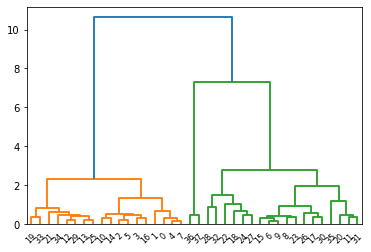

In [19]:
ids_map_gust_ascending, conn_mat_ascending, clustered_order_ascending = connectivity_sort(gust_ascending_edge)
gust_ascending_edge['order'] = gust_ascending_edge['pre_pt_root_id'].map(ids_map_gust_ascending)

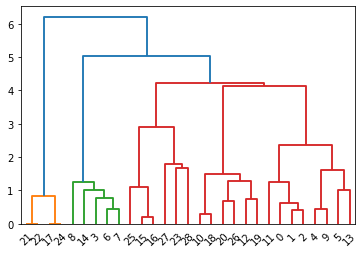

In [20]:
#clustering the postsynaptic ascending neurons to gust neurons
gust_post_ascending = gust_ascending_edge.post_pt_root_id.unique().tolist()
gust_post_ascending_sim_mat = cosine_similarity(conn_mat_ascending.T)
gust_post_ascending_clustered_order = get_clustered_order(gust_post_ascending_sim_mat)
gust_post_ascending_ids_ordered = [gust_post_ascending[i] for i in gust_post_ascending_clustered_order]

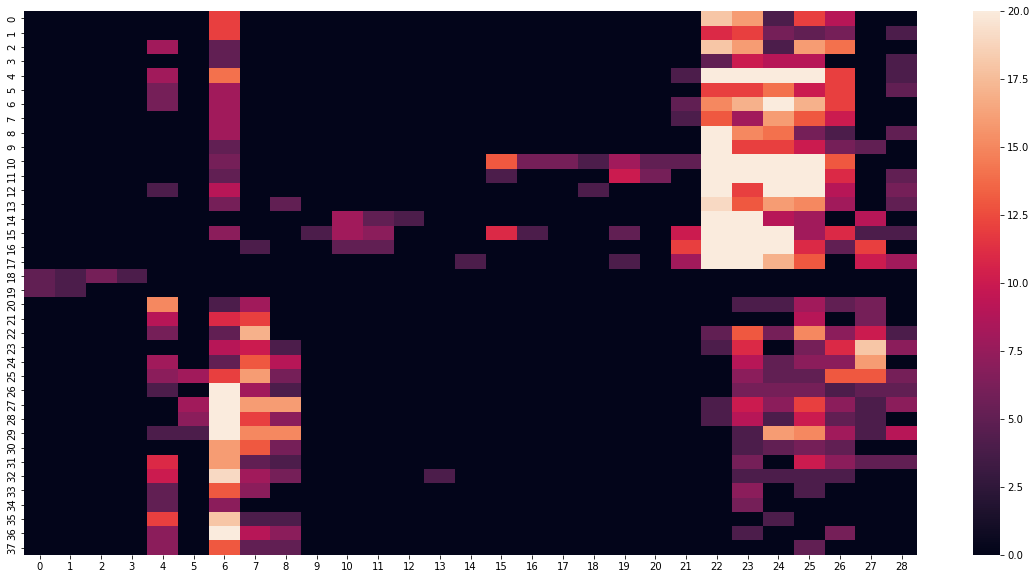

In [21]:
fig = plt.figure(1, figsize =[20,10])

conn_mat_ascending_ordered = conn_mat_ascending[clustered_order_ascending,:]
conn_mat_ascending_ordered = conn_mat_ascending_ordered[:,gust_post_ascending_clustered_order]

sns.heatmap(conn_mat_ascending_ordered, vmin=0, vmax=20)
#f= '../Gust_downstream_syn_connmat_all.png'
#plt.savefig(f)
plt.show()

In [22]:
smth = list(gust_ascending_edge[gust_ascending_edge.order.isin(list(range(0,17)))].pre_pt_root_id.unique())

## Gust_downstream connectivity

In [23]:
# class_df = pd.read_pickle(r'C:\Users\trnan\OneDrive\Desktop\uw\Tutill lab\repos\gustatory_downstream')
# final_class_df = class_df[['Segment IDs','Tags']].reset_index()
# final_class_df = final_class_df.drop(final_class_df[~final_class_df['Segment IDs'].isin(gust_post_ids_ordered)].index)

In [24]:
final_class_df = client.materialize.query_table('gustatory_downstream_t1l')

In [25]:
final_class_df

,id,created,superceded_id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,129,2023-05-26 18:54:34.274509+00:00,NaN,t,gustatory,tbd,72342506934951939,648518346495701922,"[9818, 103282, 3781]"
1,130,2023-05-26 18:54:34.275618+00:00,NaN,t,"ascending,bilateral,intersegmental,midline",tbd,72766574221647768,648518346497161857,"[20731, 158561, 2575]"
2,131,2023-05-26 18:54:34.276397+00:00,NaN,t,gustatory,tbd,72342506934984778,648518346501454424,"[9122, 104074, 3797]"
3,132,2023-05-26 18:54:34.277148+00:00,NaN,t,gustatory,tbd,72272069471317075,648518346481688735,"[6672, 102349, 3795]"
4,133,2023-05-26 18:54:34.277903+00:00,NaN,t,gustatory,tbd,72272138190756416,648518346479895013,"[7638, 102608, 3791]"
...,...,...,...,...,...,...,...,...,...
158,319,2023-05-29 17:29:31.460659+00:00,NaN,t,error,tbd,72975963004365930,648518346487526035,"[28653, 107000, 3637]"
159,320,2023-05-29 17:29:31.461268+00:00,NaN,t,gustatory,tbd,72342506934927417,648518346494219634,"[9256, 103354, 3777]"
160,321,2023-05-29 17:29:31.461861+00:00,NaN,t,error,tbd,73046400333865189,648518346492591291,"[28751, 110039, 3398]"
161,322,2023-05-29 17:29:31.462462+00:00,NaN,t,error,tbd,72905662979688963,648518346500363078,"[24731, 110448, 3656]"


In [26]:
new_class_dct = dict(zip(final_class_df['pt_root_id'], final_class_df['classification_system']))

In [27]:
# assigning new labeling system
gust_downstream_edge['new_class'] = gust_downstream_edge['post_pt_root_id'].map(new_class_dct)

In [28]:
gust_downstream_edge.loc[(~gust_downstream_edge.post_pt_root_id.isin(gust_df.pt_root_id.unique())) &
                          ~(gust_downstream_edge.classification_system.isna())].post_pt_root_id.unique()

array([648518346477104584, 648518346504049760, 648518346503901536,
       648518346479064271, 648518346493134578, 648518346502021449,
       648518346508881215, 648518346486280290, 648518346493756273,
       648518346483300260, 648518346478077653, 648518346491016227,
       648518346492035467, 648518346493182640, 648518346494575893,
       648518346501905770, 648518346486253704, 648518346492716219,
       648518346500545496, 648518346496011466, 648518346518885855,
       648518346494219634, 648518346490999160, 648518346465965360,
       648518346503860832, 648518346494916490, 648518346477700828,
       648518346492058386, 648518346490559741, 648518346511968959,
       648518346494560901, 648518346478628692, 648518346520346961,
       648518346484110877, 648518346479847141, 648518346488604750,
       648518346482280852, 648518346486703612, 648518346489745503,
       648518346480798941, 648518346481892541, 648518346486759676,
       648518346488017175, 648518346491944331, 648518346491085

In [29]:
gust_downstream_edge = gust_downstream_edge.loc[~(gust_downstream_edge.new_class.isna())]

(38, 109)


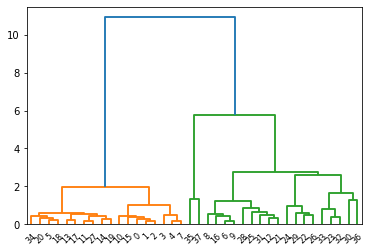

In [30]:
# gust-downstream connectivity dendrogram sorted by cosine similarity
ids_map_gust_downstream, conn_mat_dwn, clustered_order_dwn = connectivity_sort(gust_downstream_edge[~gust_downstream_edge.post_pt_root_id.isin(gust_downstream_edge.pre_pt_root_id)])
gust_downstream_edge['order'] = gust_downstream_edge['pre_pt_root_id'].map(ids_map_gust_downstream)

In [31]:
test = gust_downstream_edge.copy()

In [32]:
test[test.order==0]

,pre_pt_root_id,post_pt_root_id,cell_type,classification_system,count,new_class,order
192,648518346494140411,648518346479064271,dend_intersegmental_soma_ant_t1,ax_ascending_intersegmental_unilateral,10,"left,intersegmental,ascending,midline",0
218,648518346494140411,648518346504049760,midline_intersegmental,local,9,"intersegmental,bilateral,midline",0
236,648518346494140411,648518346493134578,dend_intersegmental_unilateral_soma_dors_t3,ax_ascending,9,"left,intersegmental,ascending",0
239,648518346494140411,648518346508881215,dend_intersegmental_bilateral_soma_t3,ax_ascending,9,"ascending,midline,intersegmental,bilateral",0
275,648518346494140411,648518346477104584,midline_intersegmental,midline_intersegmental,8,"intersegmental,bilateral,midline",0
333,648518346494140411,648518346493756273,midline_intersegmental,local,7,"intersegmental,bilateral,midline",0
377,648518346494140411,648518346486280290,midline_intersegmental,local,6,"intersegmental,bilateral,midline",0
522,648518346494140411,648518346488625230,Bristle,sensory,5,gustatory,0
540,648518346494140411,648518346502021449,dend_intersegmental_unilateral_soma_dors_t3,ax_ascending,5,"ascending,left,intersegmental",0
543,648518346494140411,648518346503901536,dend_intersegmental_bilateral_soma_t3,ax_ascending,5,"ascending,intersegmental,bilateral,midline",0


In [33]:
pre = gust_downstream_edge.pre_pt_root_id.unique().tolist()
post = gust_downstream_edge[~gust_downstream_edge.post_pt_root_id.isin(gust_downstream_edge.pre_pt_root_id)].post_pt_root_id.unique().tolist()
# initialize conn_mat with length of pre and post pt_root_ids
conn_mat = np.zeros((len(pre),len(post)))
print(conn_mat.shape)

# enumerate every pre_pt_root_id in pre list
for ix, i in enumerate(pre):
    # locates rows with pre_pt_root_id as such
    subset = gust_downstream_edge[gust_downstream_edge.pre_pt_root_id == i]

    for jx, j in enumerate(post):
        if j in subset.post_pt_root_id.tolist():
            c = subset[subset.post_pt_root_id==j]['count'].tolist()[0]
            conn_mat[ix,jx] = c

(38, 109)


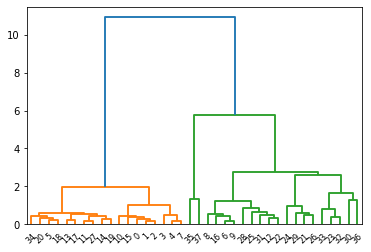

In [34]:
#clustering the gustatory neurons
gust_pre = gust_downstream_edge.pre_pt_root_id.unique().tolist()
gust_sim_mat = cosine_similarity(conn_mat)
gust_clustered_order = get_clustered_order(gust_sim_mat)
gust_ids_ordered = [gust_pre[i] for i in gust_clustered_order]

In [35]:
gust_ids_ordered[0:2]

[648518346494140411, 648518346491937675]

In [36]:
gust_downstream_edge[gust_downstream_edge['order'].isin(range(0,2))].post_pt_root_id.unique()

array([648518346477104584, 648518346493756273, 648518346504049760,
       648518346493134578, 648518346503901536, 648518346508881215,
       648518346479064271, 648518346494575893, 648518346502021449,
       648518346486280290, 648518346486759676, 648518346488625230,
       648518346479895013, 648518346490234065, 648518346486253704,
       648518346491944331, 648518346490999160, 648518346486763772],
      dtype=int64)

In [37]:
gust_downstream_group = {}
for i in range(19):
    gust_downstream_group[i] = '1'
for i in range(19, 38):
    gust_downstream_group[i] = '2'

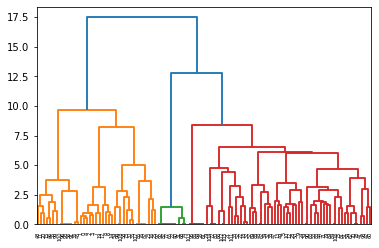

In [38]:
#clustering the postsynaptic neurons to gust neurons
gust_post = gust_downstream_edge[~gust_downstream_edge.post_pt_root_id.isin(gust_downstream_edge.pre_pt_root_id)].post_pt_root_id.unique().tolist()
gust_post_sim_mat = cosine_similarity(conn_mat.T)
gust_post_clustered_order = get_clustered_order(gust_post_sim_mat)
gust_post_ids_ordered = [gust_post[i] for i in gust_post_clustered_order]

#reordering the connectivity matrix according to both #clusterings
gust_conn_mat_ordered = conn_mat[gust_clustered_order,:]
gust_conn_mat_ordered = gust_conn_mat_ordered[:,gust_post_clustered_order]

In [39]:
gust_post_id_map = dict(zip(gust_post_ids_ordered,[i for i in range(len(gust_post_ids_ordered))]))

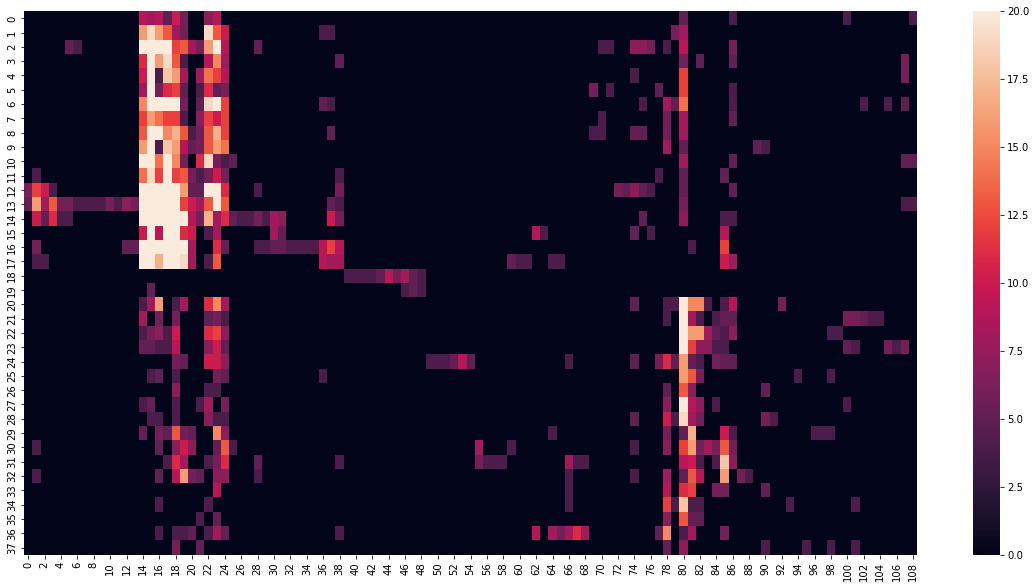

In [40]:
#plotting
fig = plt.figure(1, figsize =[20,10])
sns.heatmap(gust_conn_mat_ordered, vmin=0, vmax=20)
plt.show()

In [41]:
gust_dwn_dct = {}
# gust_dwn_dct = classify_clusters(clustered_order_dwn, range(0,18), 11, gust_dwn_dct)
# gust_dwn_dct = classify_clusters(clustered_order_dwn, range(18,20), 12, gust_dwn_dct)
# gust_dwn_dct = classify_clusters(clustered_order_dwn, range(20,26), 13, gust_dwn_dct)
# gust_dwn_dct = classify_clusters(clustered_order_dwn, range(26,39), 14, gust_dwn_dct)
# gust_dwn_dct = classify_clusters(clustered_order_dwn, range(0,18), 11, gust_dwn_dct)
# gust_dwn_dct = classify_clusters(clustered_order_dwn, range(18,19), 12, gust_dwn_dct)
# gust_dwn_dct = classify_clusters(clustered_order_dwn, range(19,25), 13, gust_dwn_dct)
# gust_dwn_dct = classify_clusters(clustered_order_dwn, range(25,38), 14, gust_dwn_dct)
# gust_downstream_edge['category'] = gust_downstream_edge['order'].map(gust_dwn_dct)
# gust_dwn_id_class = dict(zip(gust_downstream_edge.pre_pt_root_id, gust_downstream_edge.category))

In [42]:
# gust_downstream_edge['order'] = pd.Categorical(gust_downstream_edge.order)

In [43]:
# gust_downstream['category'] = gust_downstream['pre_pt_root_id'].map(gust_dwn_id_class)


In [44]:
# category = 12
# gust_downstream_a_category = gust_downstream[gust_downstream.category == category]
# plot_entire(gust_downstream_a_category, f"gust-downstream synapse position category {category}", gust_downstream_a_category.category)

In [45]:
# plot_entire(gust_downstream, "gust-downstream synapse position", gust_downstream.category)

In [46]:
# assigning order for post_ids
gust_downstream_edge['post_order'] = gust_downstream_edge['post_pt_root_id'].map(gust_post_id_map)

In [47]:
# confirming that the new class added covers for every downstream partners (except for interconnection)
gust_downstream_edge.loc[(gust_downstream_edge.new_class.isna()) 
                         & (gust_downstream_edge.post_pt_root_id.isin(gust_post_ids_ordered))]

,pre_pt_root_id,post_pt_root_id,cell_type,classification_system,count,new_class,order,post_order


## TESTING

In [48]:
test = gust_downstream_edge.copy()

In [49]:
gust_post_ids_ordered[22:30], gust_post_ids_ordered[77:89], gust_post_ids_ordered[63:76]

([648518346493756273,
  648518346508881215,
  648518346494575893,
  648518346502023283,
  648518346512687262,
  648518346498539076,
  648518346477652494,
  648518346489327705],
 [648518346480798941,
  648518346493182640,
  648518346486759676,
  648518346502021449,
  648518346478077653,
  648518346492035467,
  648518346494916490,
  648518346488017175,
  648518346483300260,
  648518346490999160,
  648518346500363078,
  648518346502316403],
 [648518346491406504,
  648518346511968959,
  648518346501454424,
  648518346503860832,
  648518346500545496,
  648518346486417824,
  648518346499578373,
  648518346509589891,
  648518346480940288,
  648518346488604750,
  648518346484267962,
  648518346509953338,
  648518346478628692])

In [50]:
df_no_error = gust_downstream_edge.copy()

In [51]:
all_ascending = df_no_error[df_no_error.new_class.str.contains('ascending',na=False)].new_class.unique()
not_ascending = df_no_error[~df_no_error.new_class.str.contains('ascending',na=False)].new_class.unique()
intersegmental = df_no_error[df_no_error.new_class.str.contains('intersegmental',na=False)].new_class.unique()
midline = df_no_error[df_no_error.new_class.str.contains('midline',na=False)].new_class.unique()
name = ['ascending', 'not_ascending', 'intersegmental', 'midline']
# all_intersegmental = gust_downstream_edge[gust_downstream_edge.new_class.str.contains('intersegmental',na=False)].new_class.unique()

In [52]:
gust_downstream_edge

,pre_pt_root_id,post_pt_root_id,cell_type,classification_system,count,new_class,order,post_order
0,648518346490221320,648518346477104584,midline_intersegmental,midline_intersegmental,57,"intersegmental,bilateral,midline",12,15
1,648518346486178440,648518346477104584,midline_intersegmental,midline_intersegmental,48,"intersegmental,bilateral,midline",13,15
2,648518346486178440,648518346504049760,midline_intersegmental,local,46,"intersegmental,bilateral,midline",13,14
3,648518346491499974,648518346477104584,midline_intersegmental,midline_intersegmental,45,"intersegmental,bilateral,midline",14,15
4,648518346491499974,648518346504049760,midline_intersegmental,local,44,"intersegmental,bilateral,midline",14,14
...,...,...,...,...,...,...,...,...
811,648518346511221557,648518346482292884,NaN,NaN,4,error,16,32
812,648518346491499974,648518346498539076,NaN,NaN,4,error,14,27
813,648518346483328588,648518346493968782,Bristle,sensory,4,gustatory,29,NaN
814,648518346477699735,648518346475324257,Bristle,sensory,4,gustatory,37,NaN


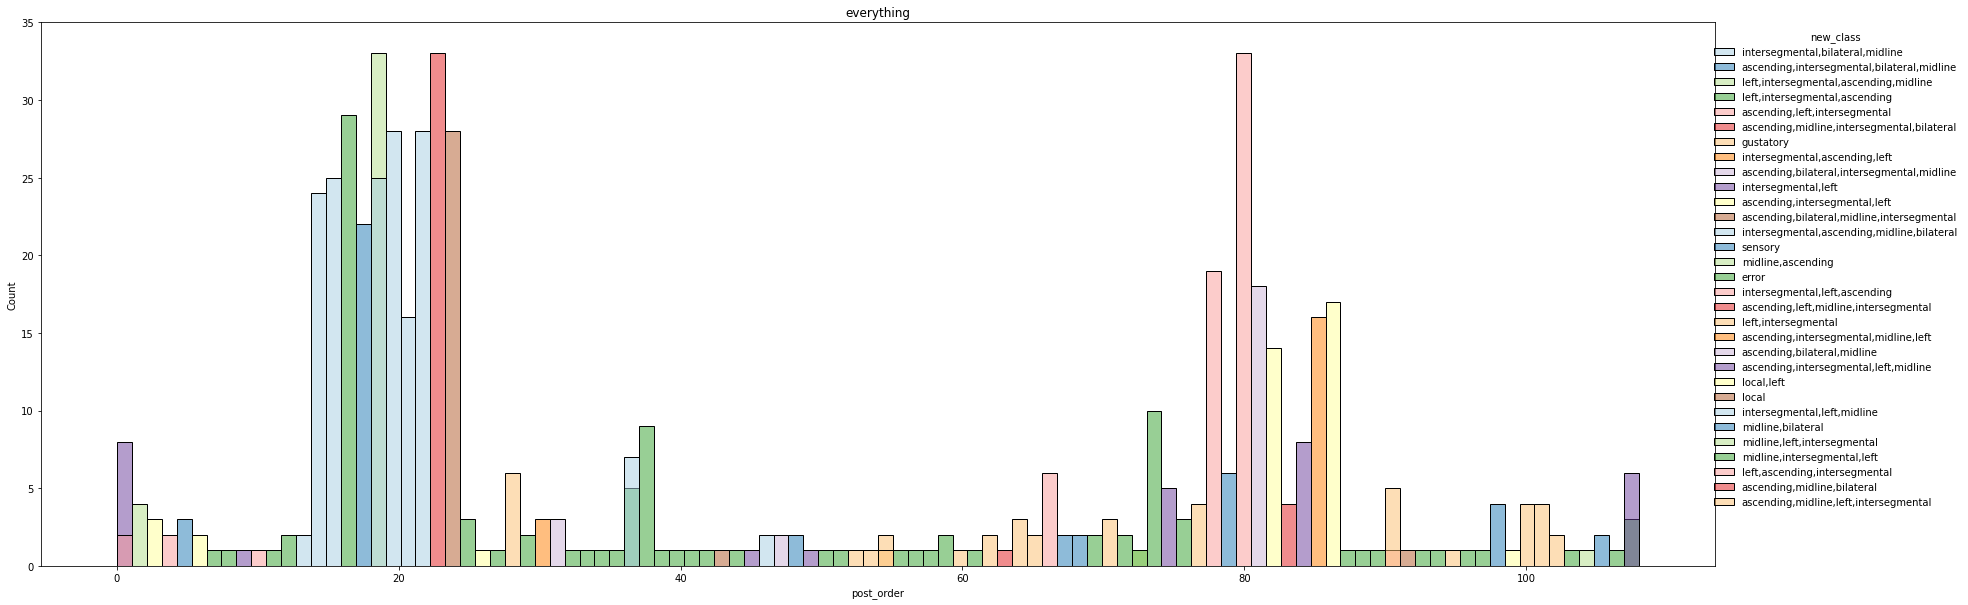

In [53]:
histplot_classes(df_no_error, 'new_class', 'everything')

In [54]:
for title, i in enumerate([all_ascending, not_ascending, intersegmental, midline]):
    print(i)

['ascending,intersegmental,bilateral,midline'
 'left,intersegmental,ascending,midline' 'left,intersegmental,ascending'
 'ascending,left,intersegmental'
 'ascending,midline,intersegmental,bilateral'
 'intersegmental,ascending,left'
 'ascending,bilateral,intersegmental,midline'
 'ascending,intersegmental,left'
 'ascending,bilateral,midline,intersegmental'
 'intersegmental,ascending,midline,bilateral' 'midline,ascending'
 'intersegmental,left,ascending' 'ascending,left,midline,intersegmental'
 'ascending,intersegmental,midline,left' 'ascending,bilateral,midline'
 'ascending,intersegmental,left,midline' 'left,ascending,intersegmental'
 'ascending,midline,bilateral' 'ascending,midline,left,intersegmental']
['intersegmental,bilateral,midline' 'gustatory' 'intersegmental,left'
 'sensory' 'error' 'left,intersegmental' 'local,left' 'local'
 'intersegmental,left,midline' 'midline,bilateral'
 'midline,left,intersegmental' 'midline,intersegmental,left']
['intersegmental,bilateral,midline'
 'ascend

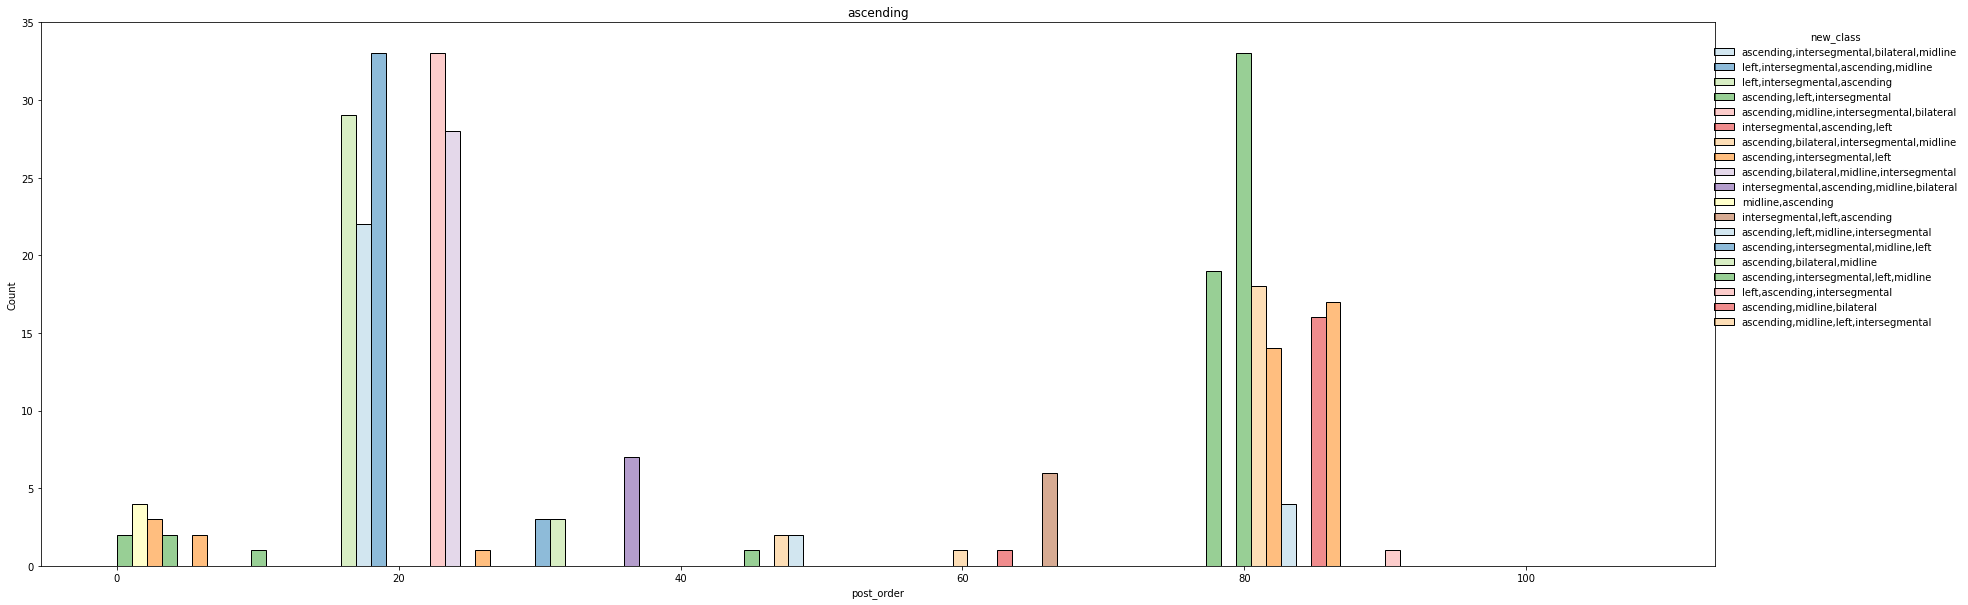

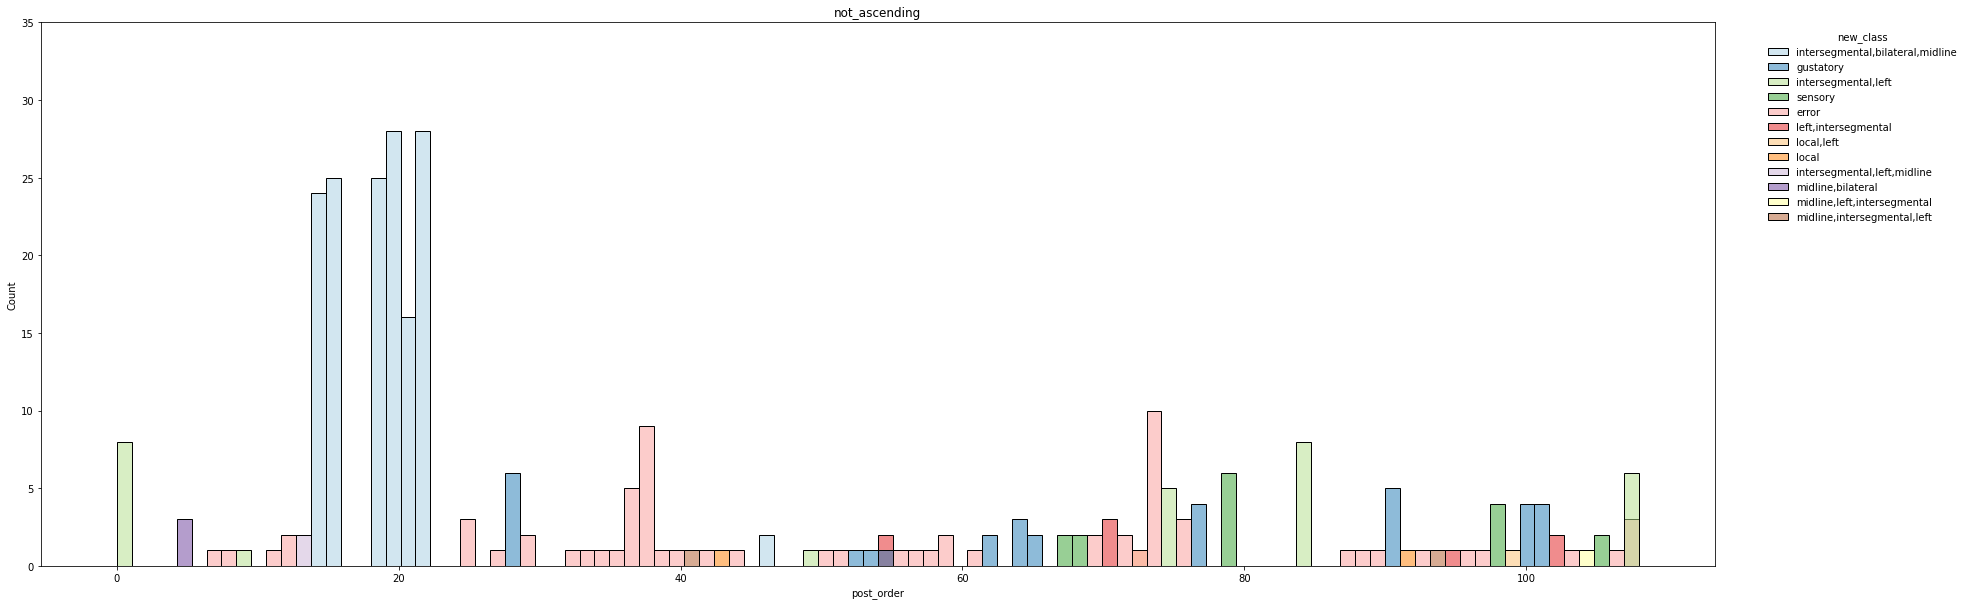

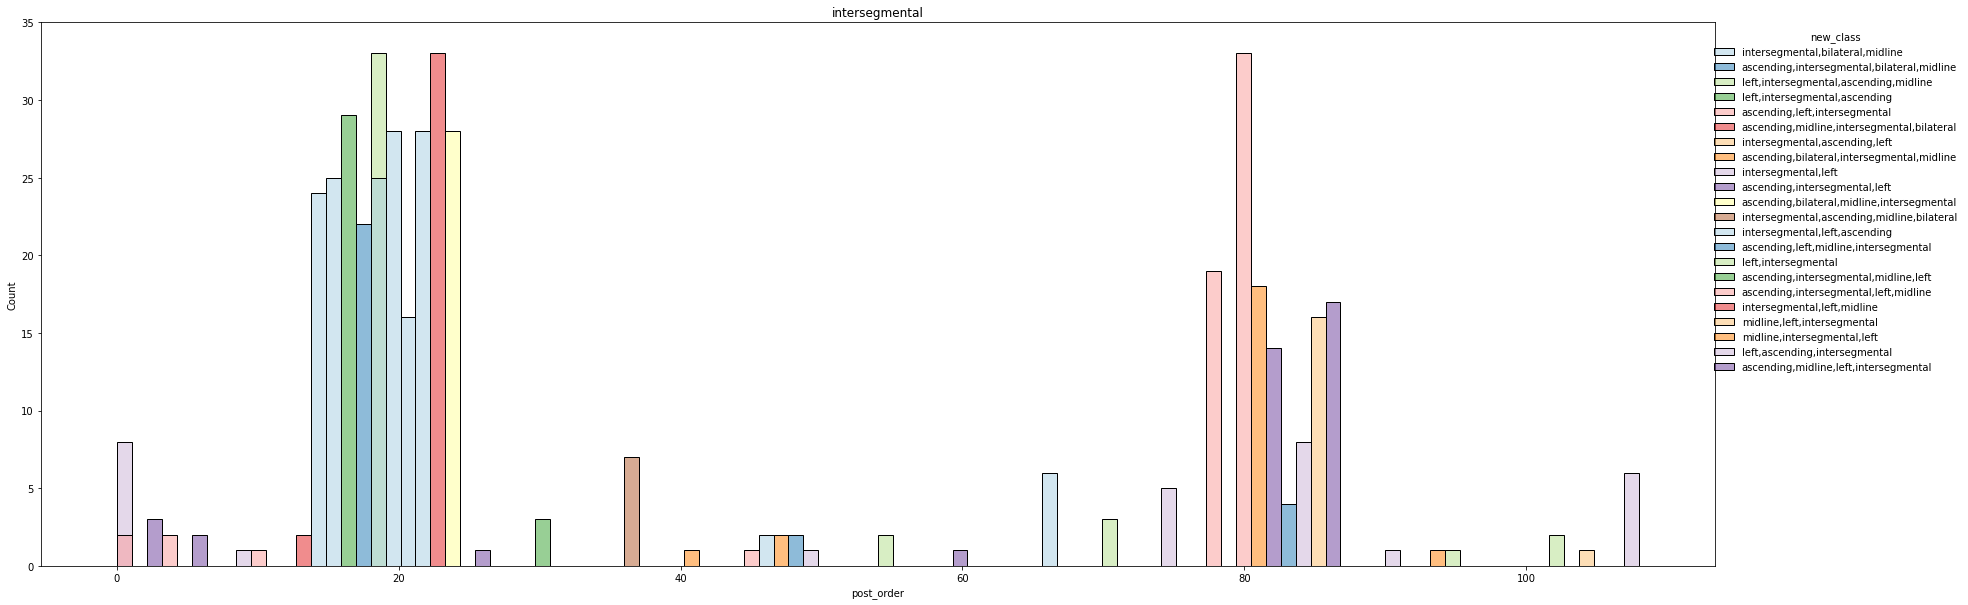

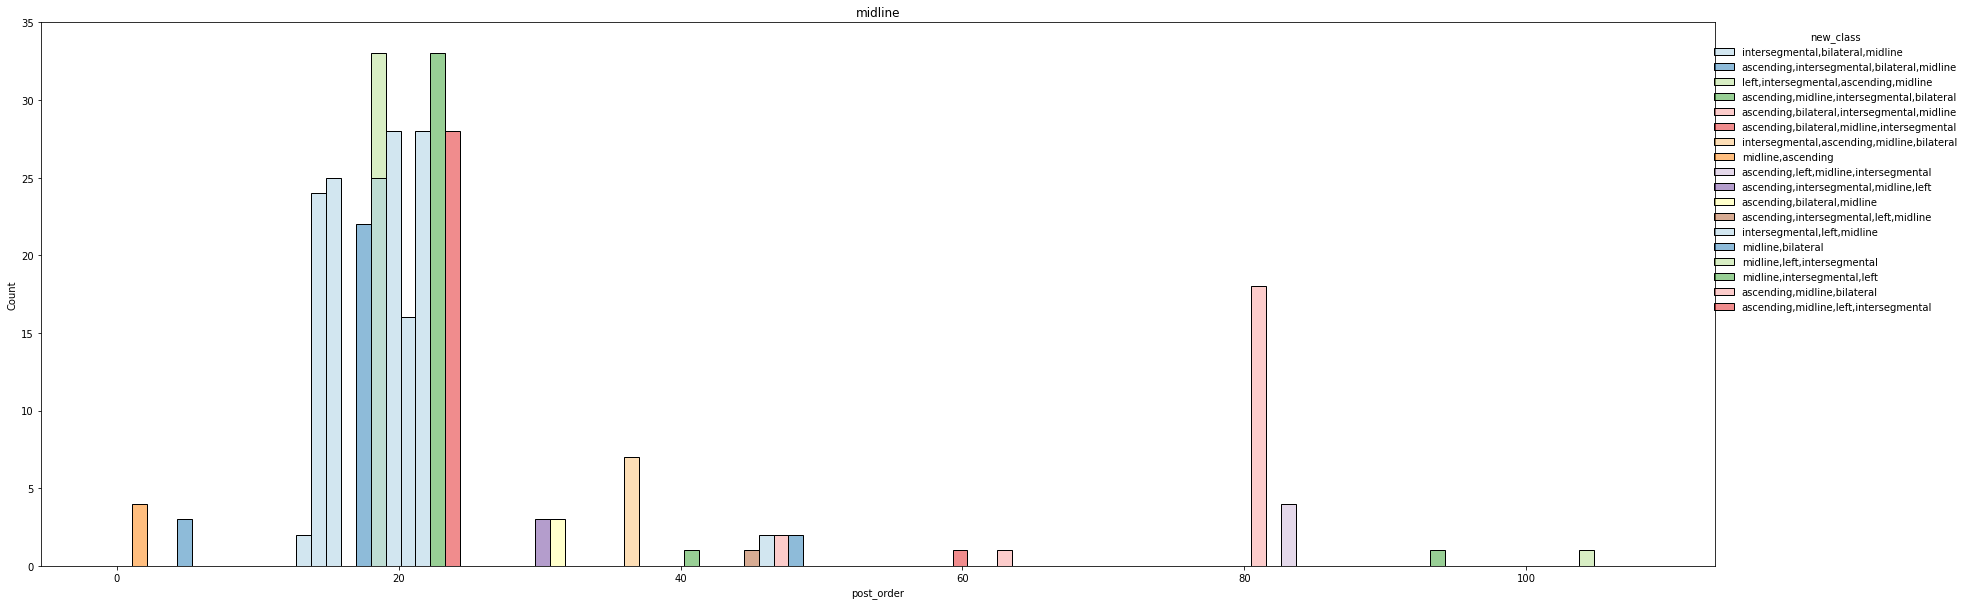

In [55]:
for title, i in enumerate([all_ascending, not_ascending, intersegmental, midline]):
    histplot_classes(df_no_error, 'new_class',  f'{name[title]}', hue_order=i,)

##### Checking for partners between range(x,y)

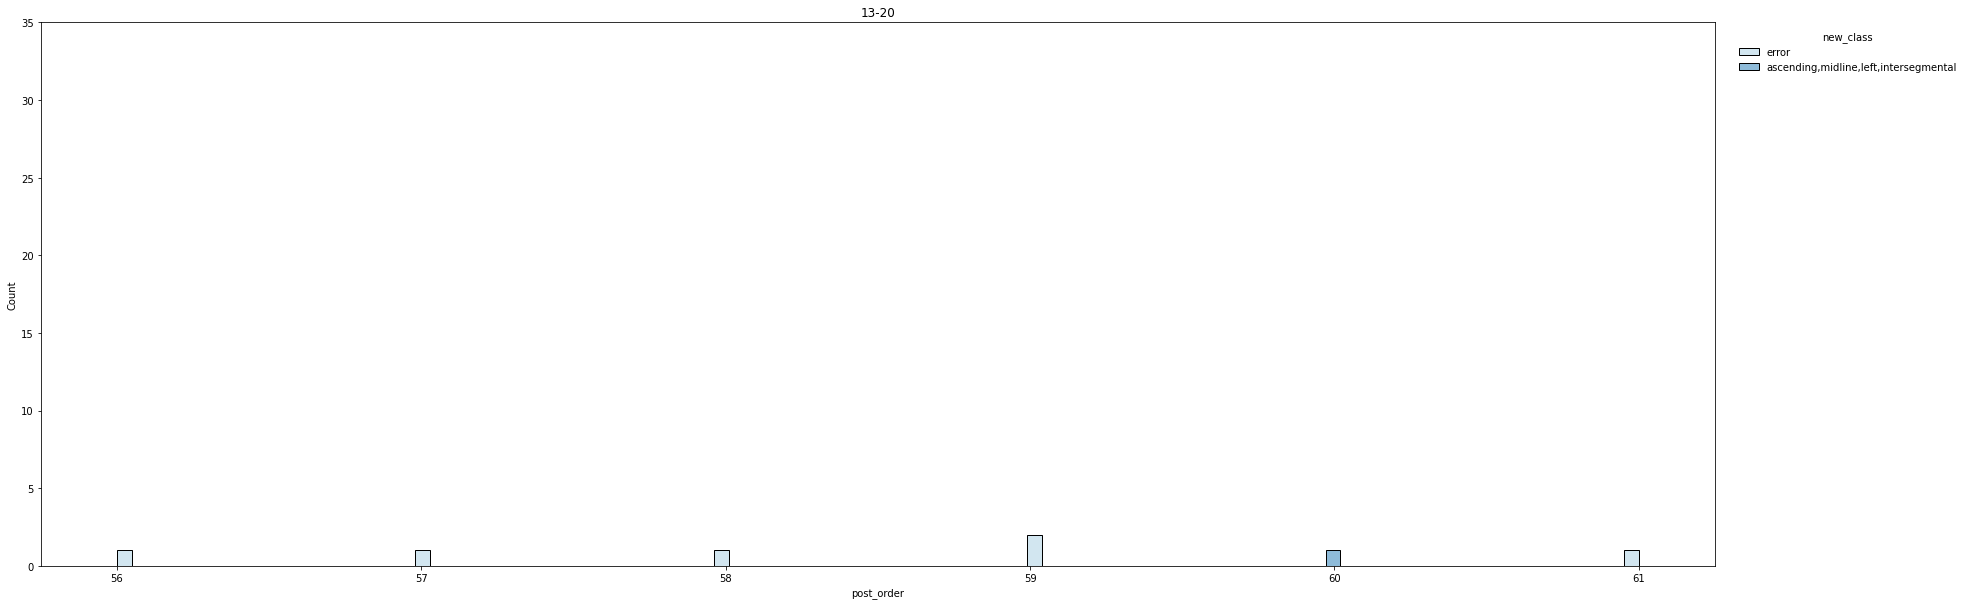

In [56]:
histplot_classes(df_no_error[df_no_error.post_order.isin(list(range(56,62)))],'new_class', "13-20")

## proportionality histogram by synapses

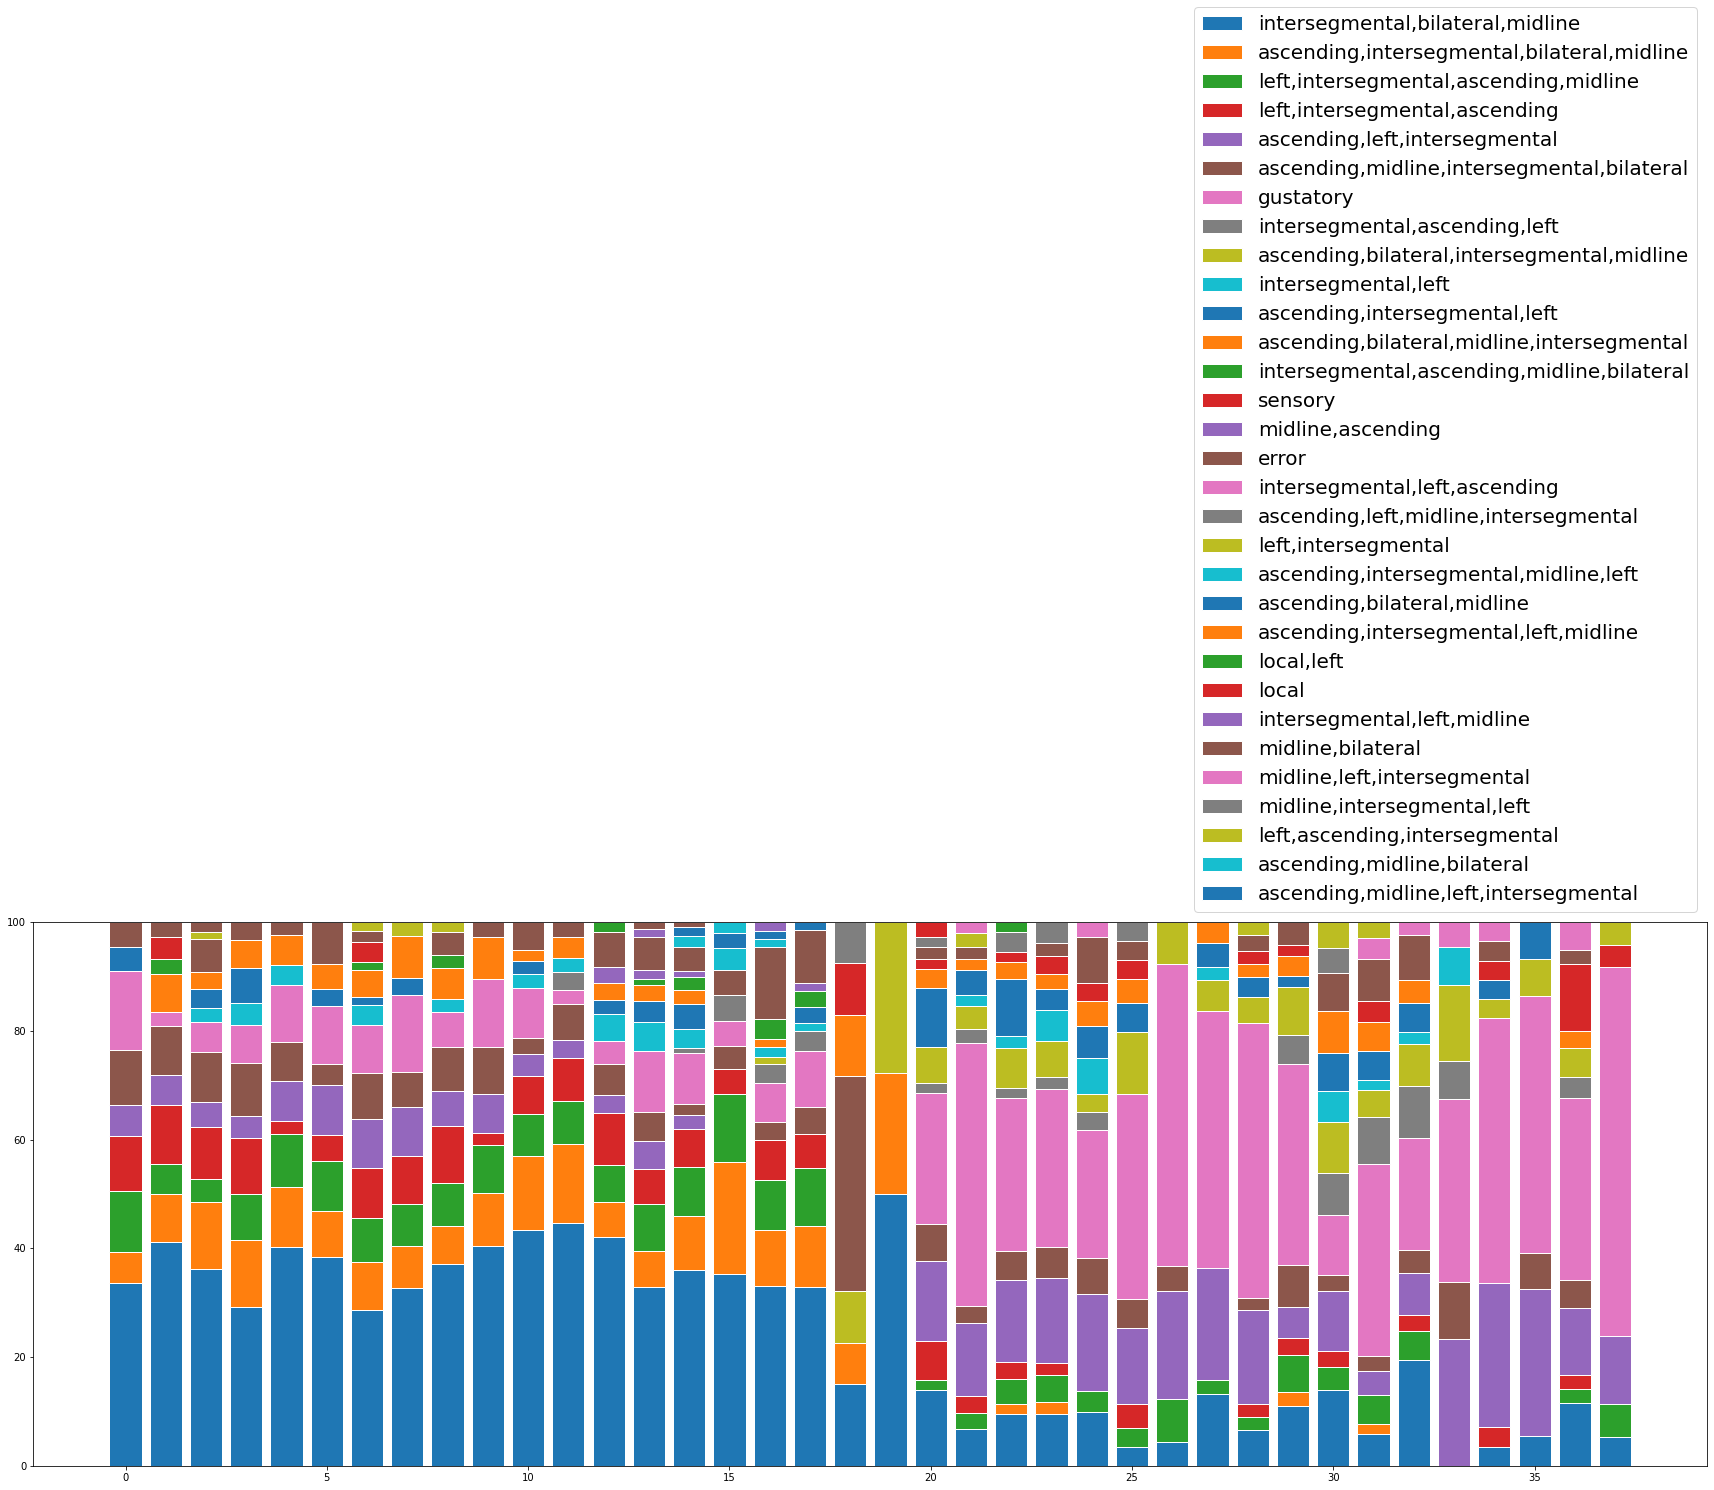

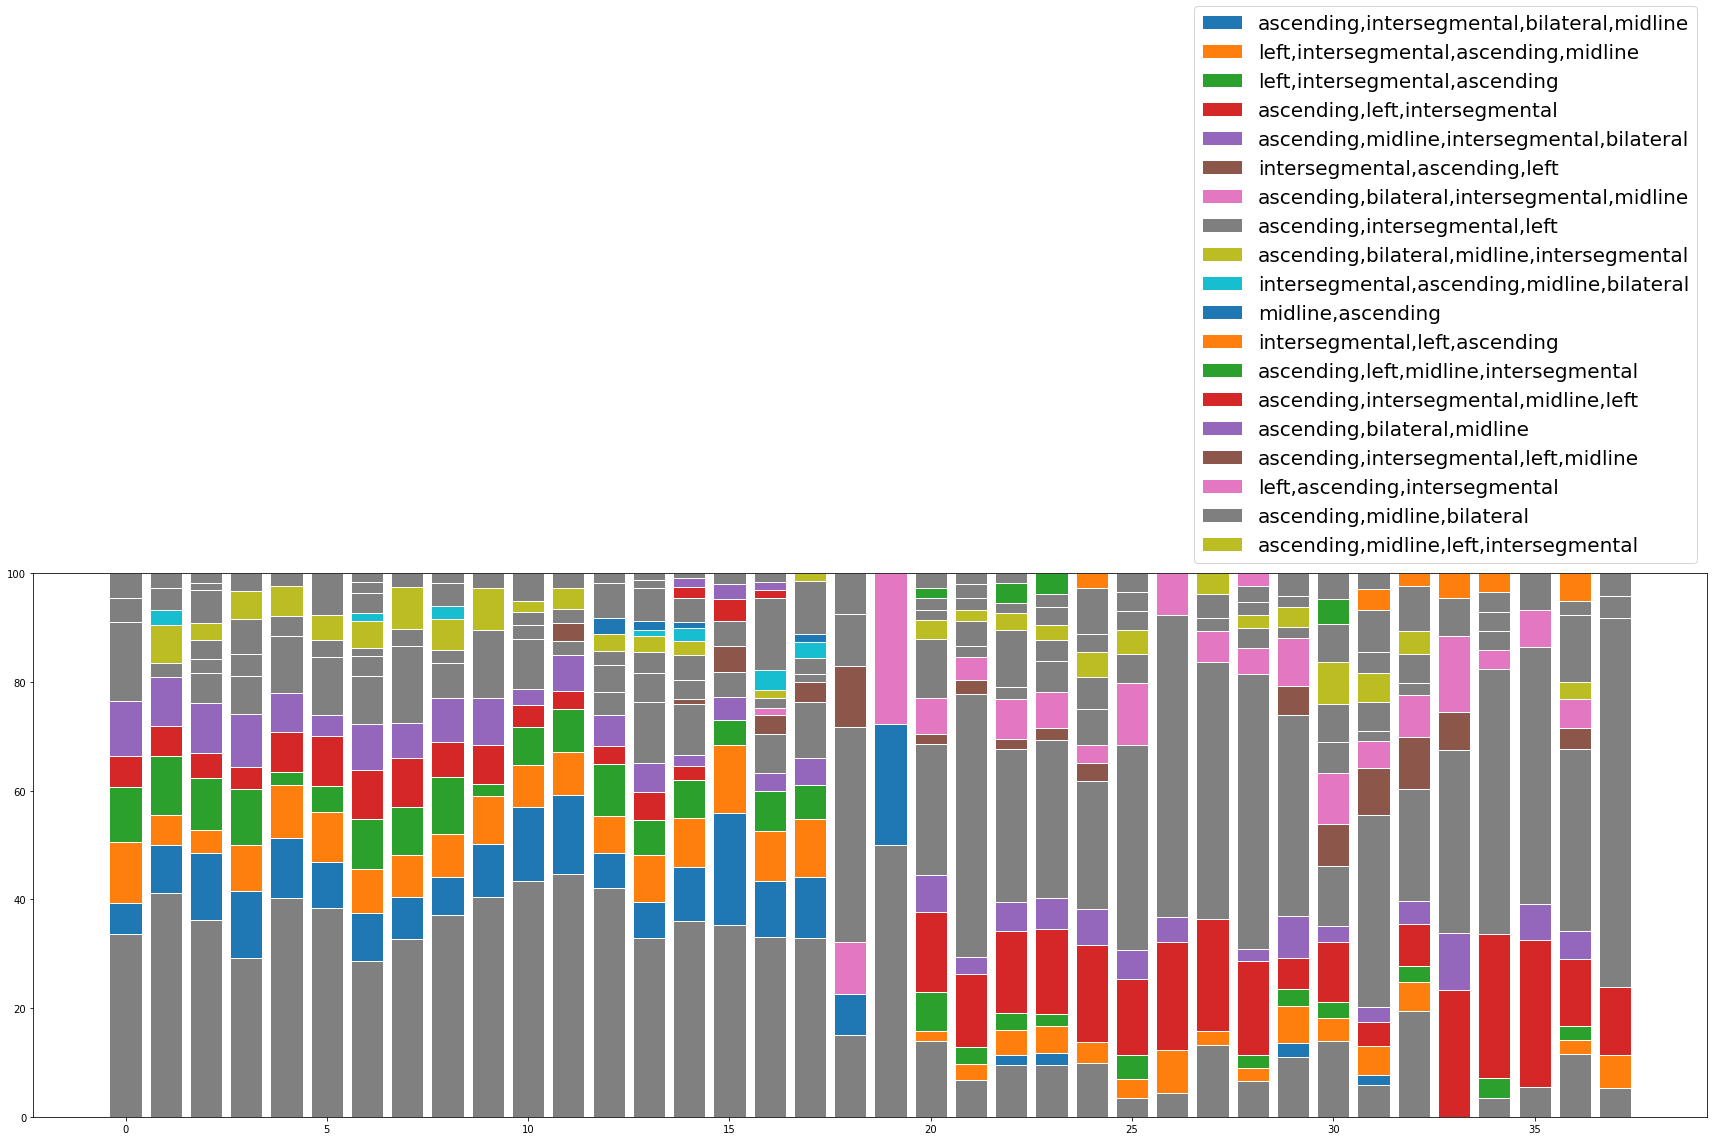

In [57]:
plot_percent_stacked_bar_column(gust_downstream_edge, 'new_class', groupby=['order'])
plot_percent_stacked_bar_column(gust_downstream_edge, 'new_class', groupby=['order'], only=all_ascending)

- Fig (1): everything
- Fig (2): only ascending

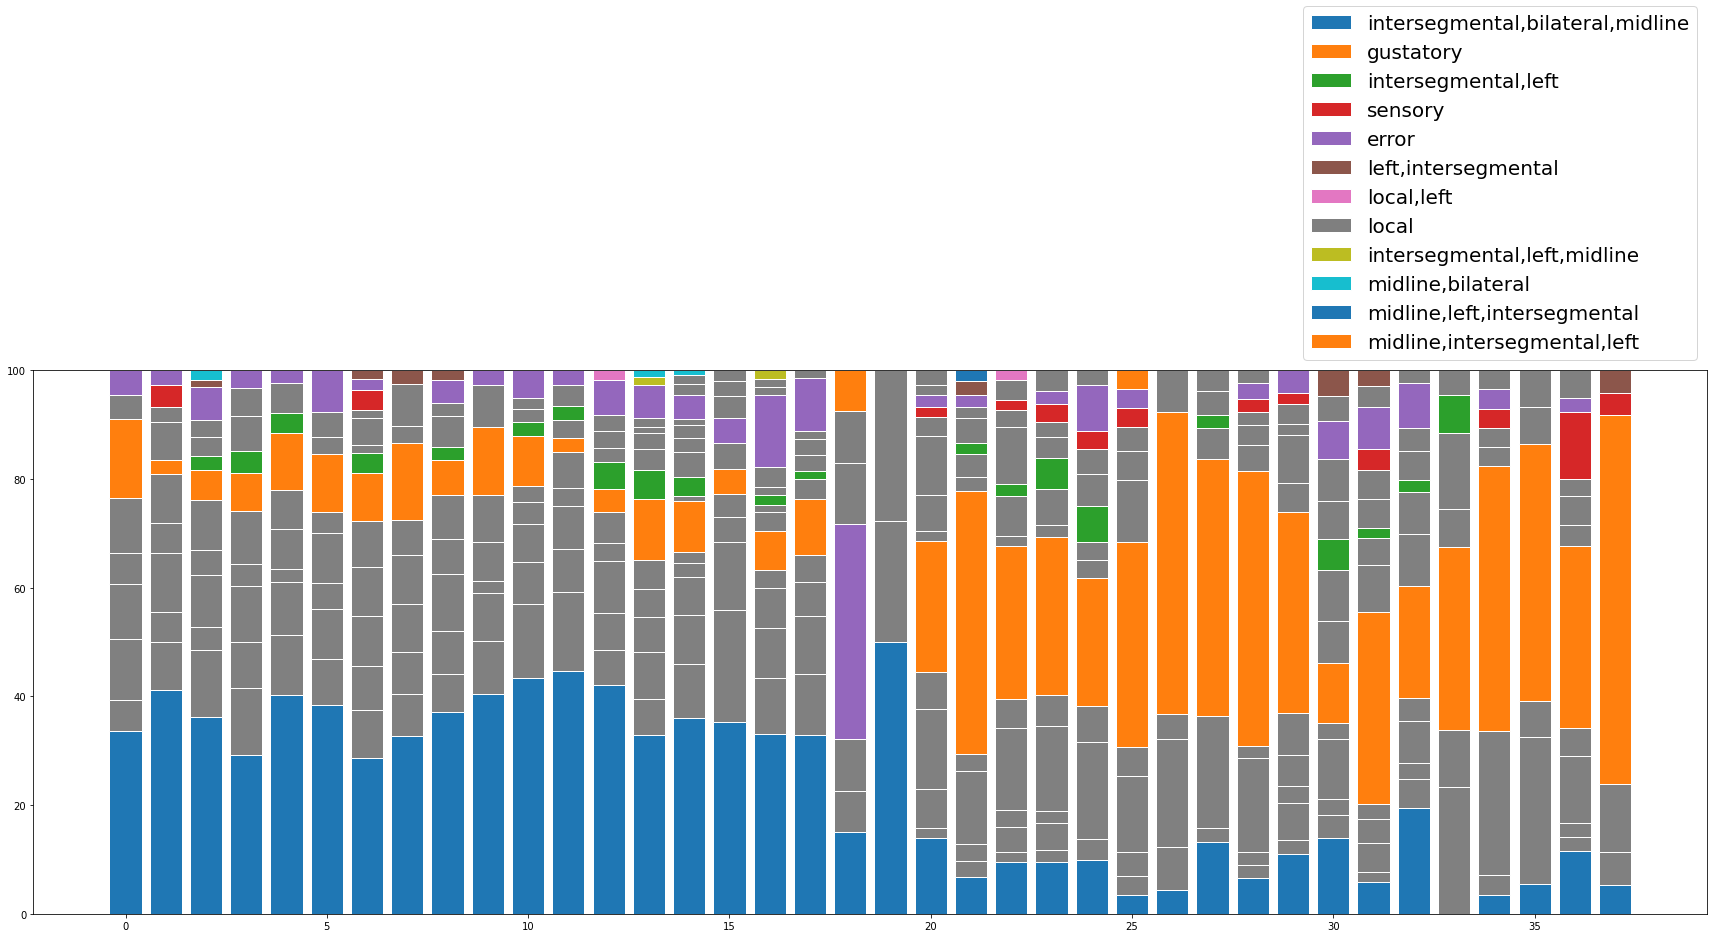

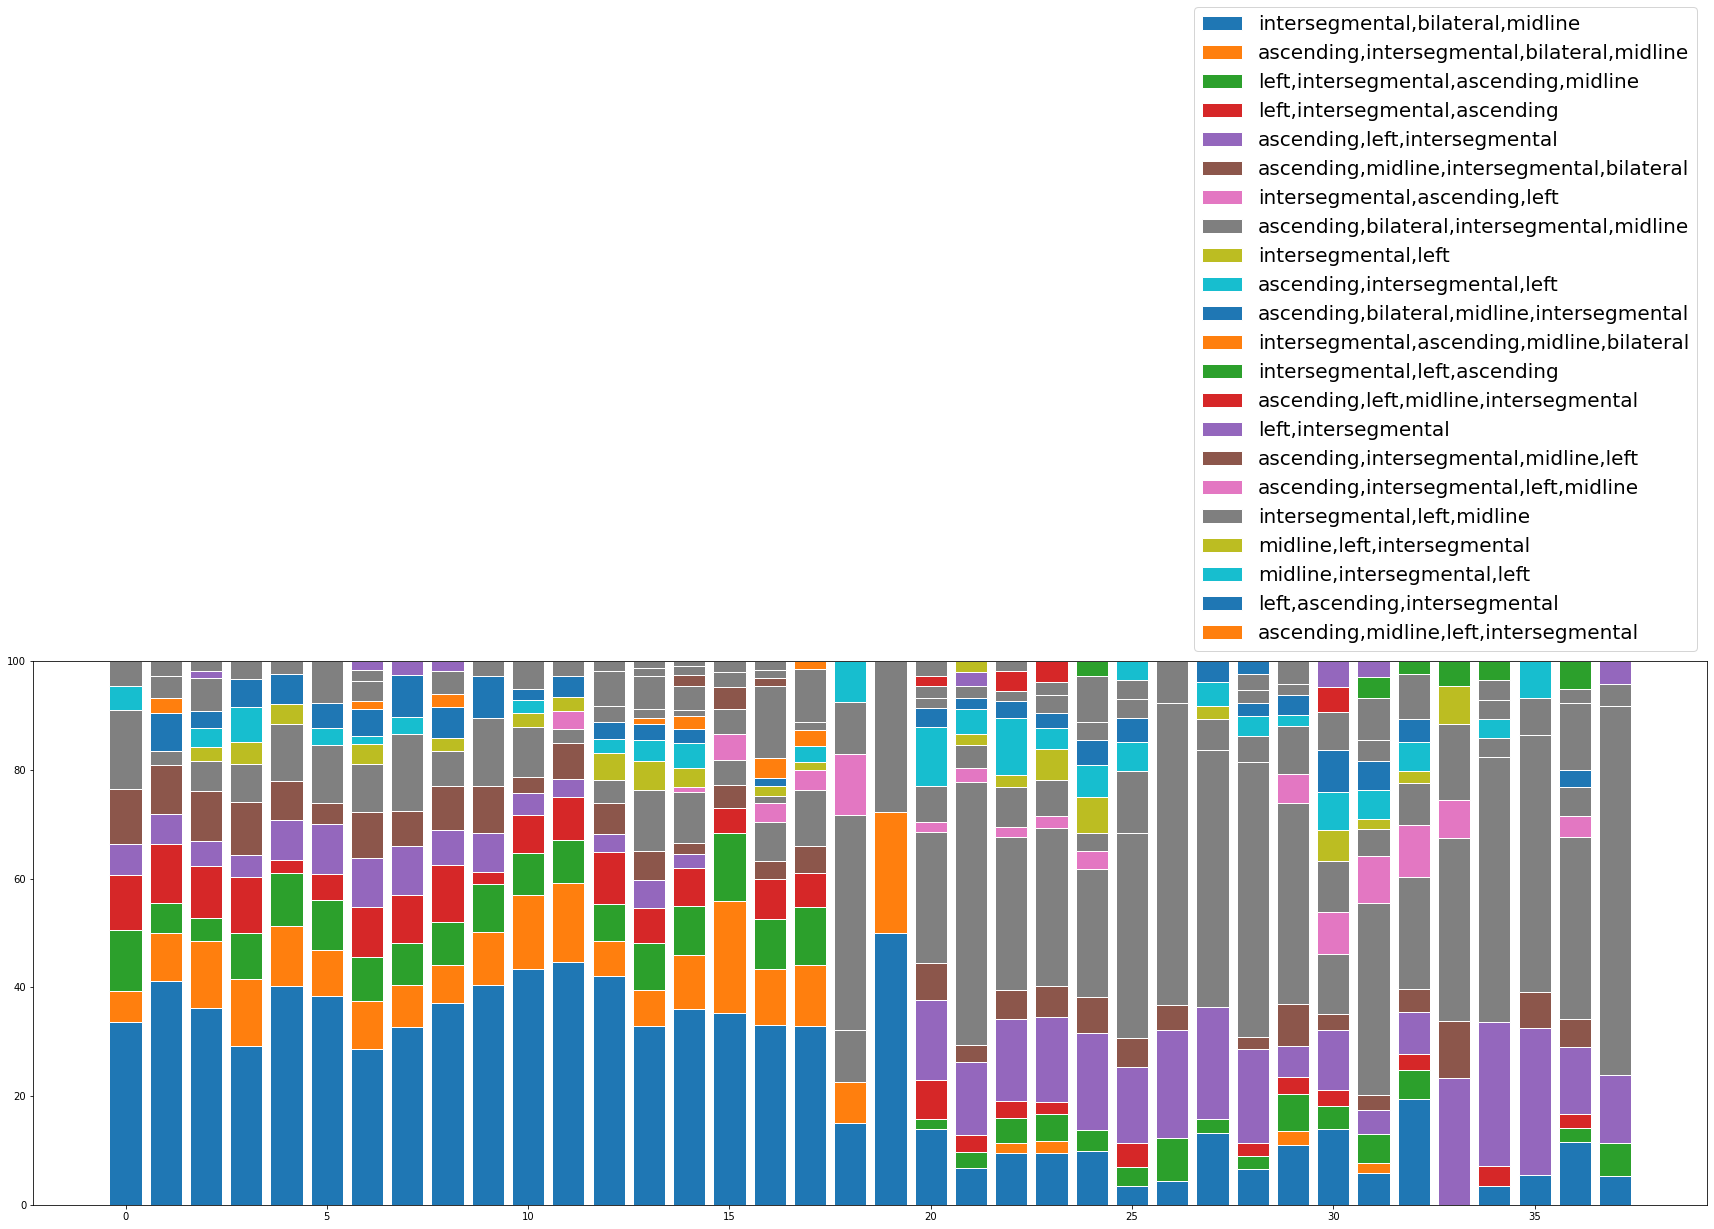

In [58]:
plot_percent_stacked_bar_column(gust_downstream_edge, 'new_class', groupby=['order'], only=not_ascending)
plot_percent_stacked_bar_column(gust_downstream_edge, 'new_class', groupby=['order'], only=intersegmental)

- Fig (3): any non-ascending
- Fig (4): only intersegmental

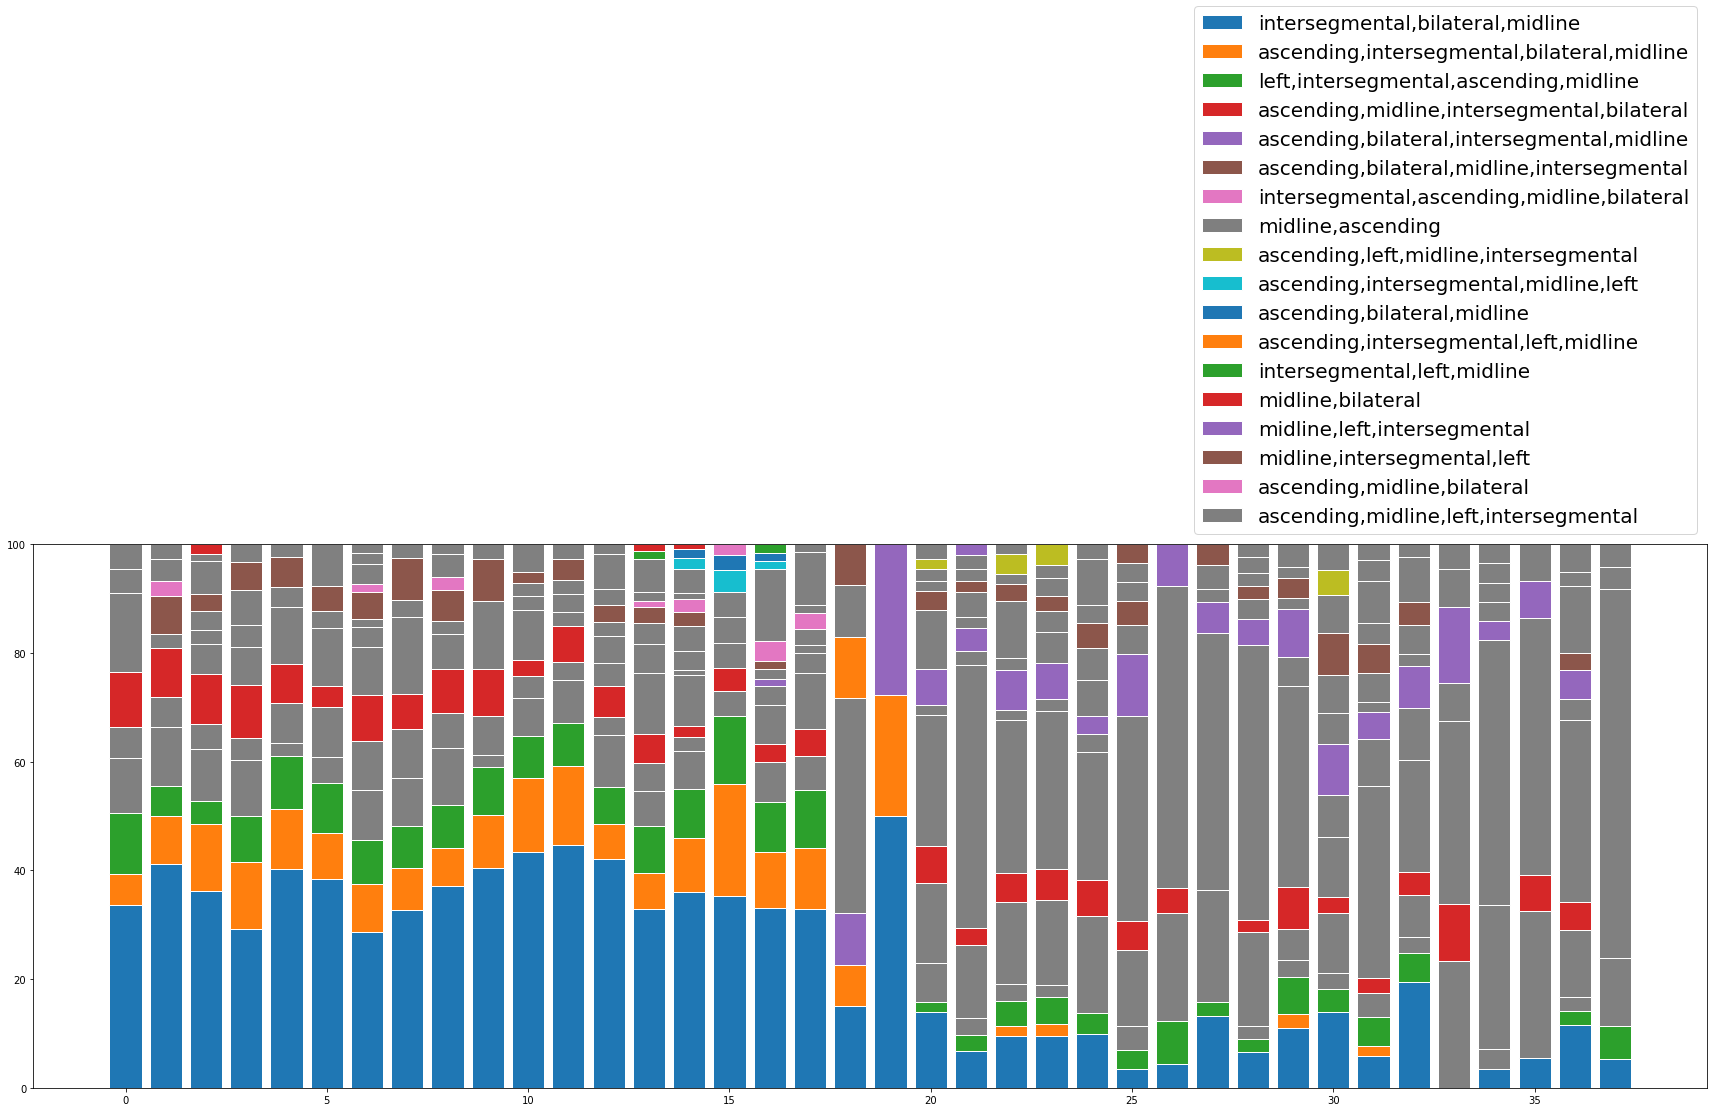

In [59]:
plot_percent_stacked_bar_column(gust_downstream_edge, 'new_class', groupby=['order'], only=midline)

- Fig (5): only midline

#### Conclusion
- 0-18: has left_bilateral_ascending | slightly more left_ascending | --> more towards the left
- 20-37: more intersegmental_ascending (only 1 notable partner) | also more errors | has 1 right ascending (could be error)| slightly more local_midline_ascending --> in general, more intersegmental --> more contained within the volume
- 19: only intersegmental and bilateral_ascending
- (there are some labeling errors, there's 1 labeled bilateral_ascending whereas it's only bilateral_intersegmental)

## ENDING

## Gust_gust connectivity

(38, 38)


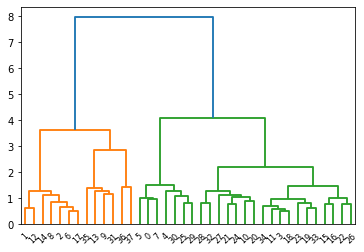

In [60]:
ids_map_gust_gust, conn_mat, clustered_order = connectivity_sort(gust_only_edge, reverted=True)
gust_only_edge['pre_order'] = gust_only_edge['pre_pt_root_id'].map(ids_map_gust_gust)
gust_only_edge['post_order'] = gust_only_edge['post_pt_root_id'].map(ids_map_gust_gust)

In [61]:
dct = {}
dct = classify_clusters(clustered_order, range(0,7), 0, dct)
dct = classify_clusters(clustered_order, range(7,13), 1, dct)
dct = classify_clusters(clustered_order, range(13,26), 2, dct)
dct = classify_clusters(clustered_order, range(26,37), 3, dct)
gust_only_edge['category'] = gust_only_edge['pre_order'].map(dct)
gust_id_class = dict(zip(gust_only_edge.pre_pt_root_id, gust_only_edge.category))

In [62]:
gust_only_df['category'] = gust_only_df['pre_pt_root_id'].map(gust_id_class)

array([[134.7663, 469.9857, 155.97  ],
       [135.9875, 468.6871, 155.61  ],
       [135.2135, 469.3665, 155.7   ],
       ...,
       [112.2773, 472.8409, 157.995 ],
       [112.2687, 472.8151, 157.95  ],
       [112.5267, 480.7959, 154.575 ]])

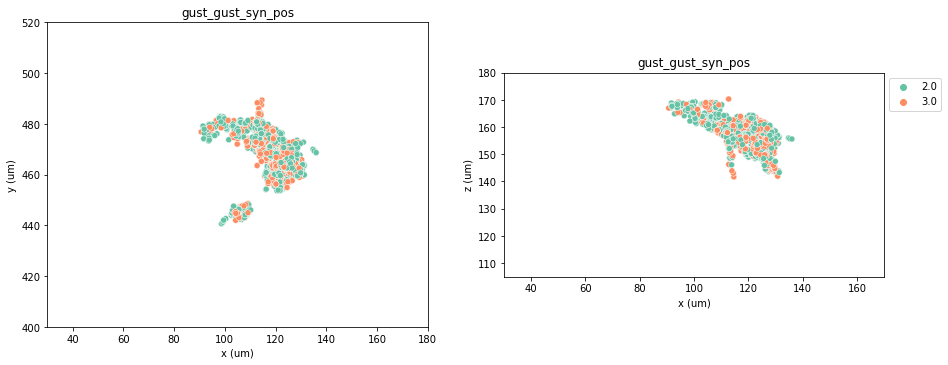

In [63]:
plot_entire(gust_only_df.loc[(gust_only_df.category == 2) | (gust_only_df.category == 3)], "gust_gust_syn_pos", 
            gust_only_df.loc[(gust_only_df.category == 2) | (gust_only_df.category == 3)].category)

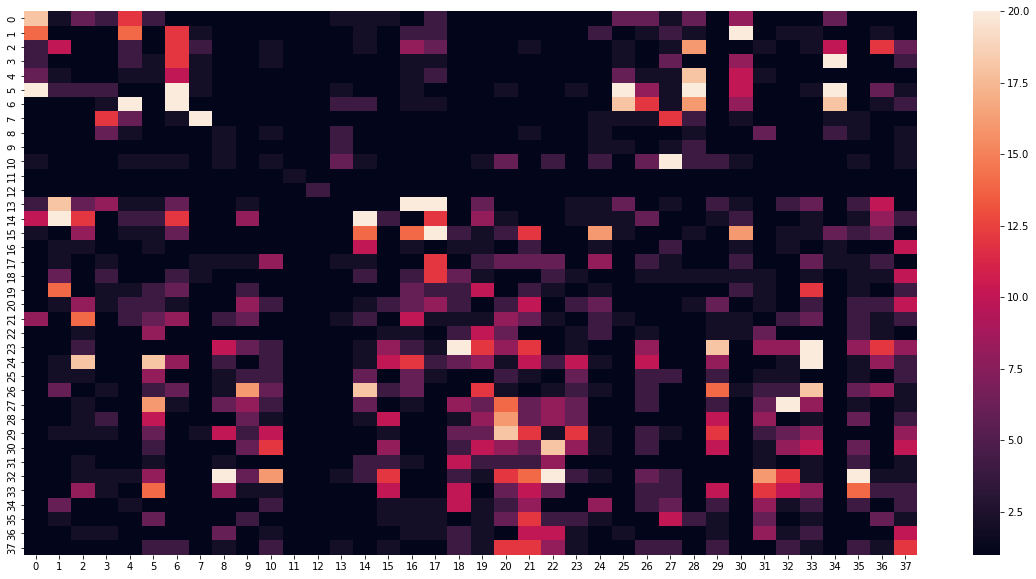

In [64]:
fig = plt.figure(1, figsize =[20,10])

conn_mat_ordered = conn_mat[clustered_order,:]
conn_mat_ordered = conn_mat_ordered[:,clustered_order]

sns.heatmap(conn_mat_ordered, vmin=1, vmax=20)
#f= '../Gust_downstream_syn_connmat_all.png'
#plt.savefig(f)
plt.show()

In [65]:
smth1 = gust_downstream_edge.copy()
dct_smth = dict(zip(gust_only_edge.pre_pt_root_id, gust_only_edge.pre_order))
smth1['gust_gust_order'] = smth1['pre_pt_root_id'].map(dct_smth)

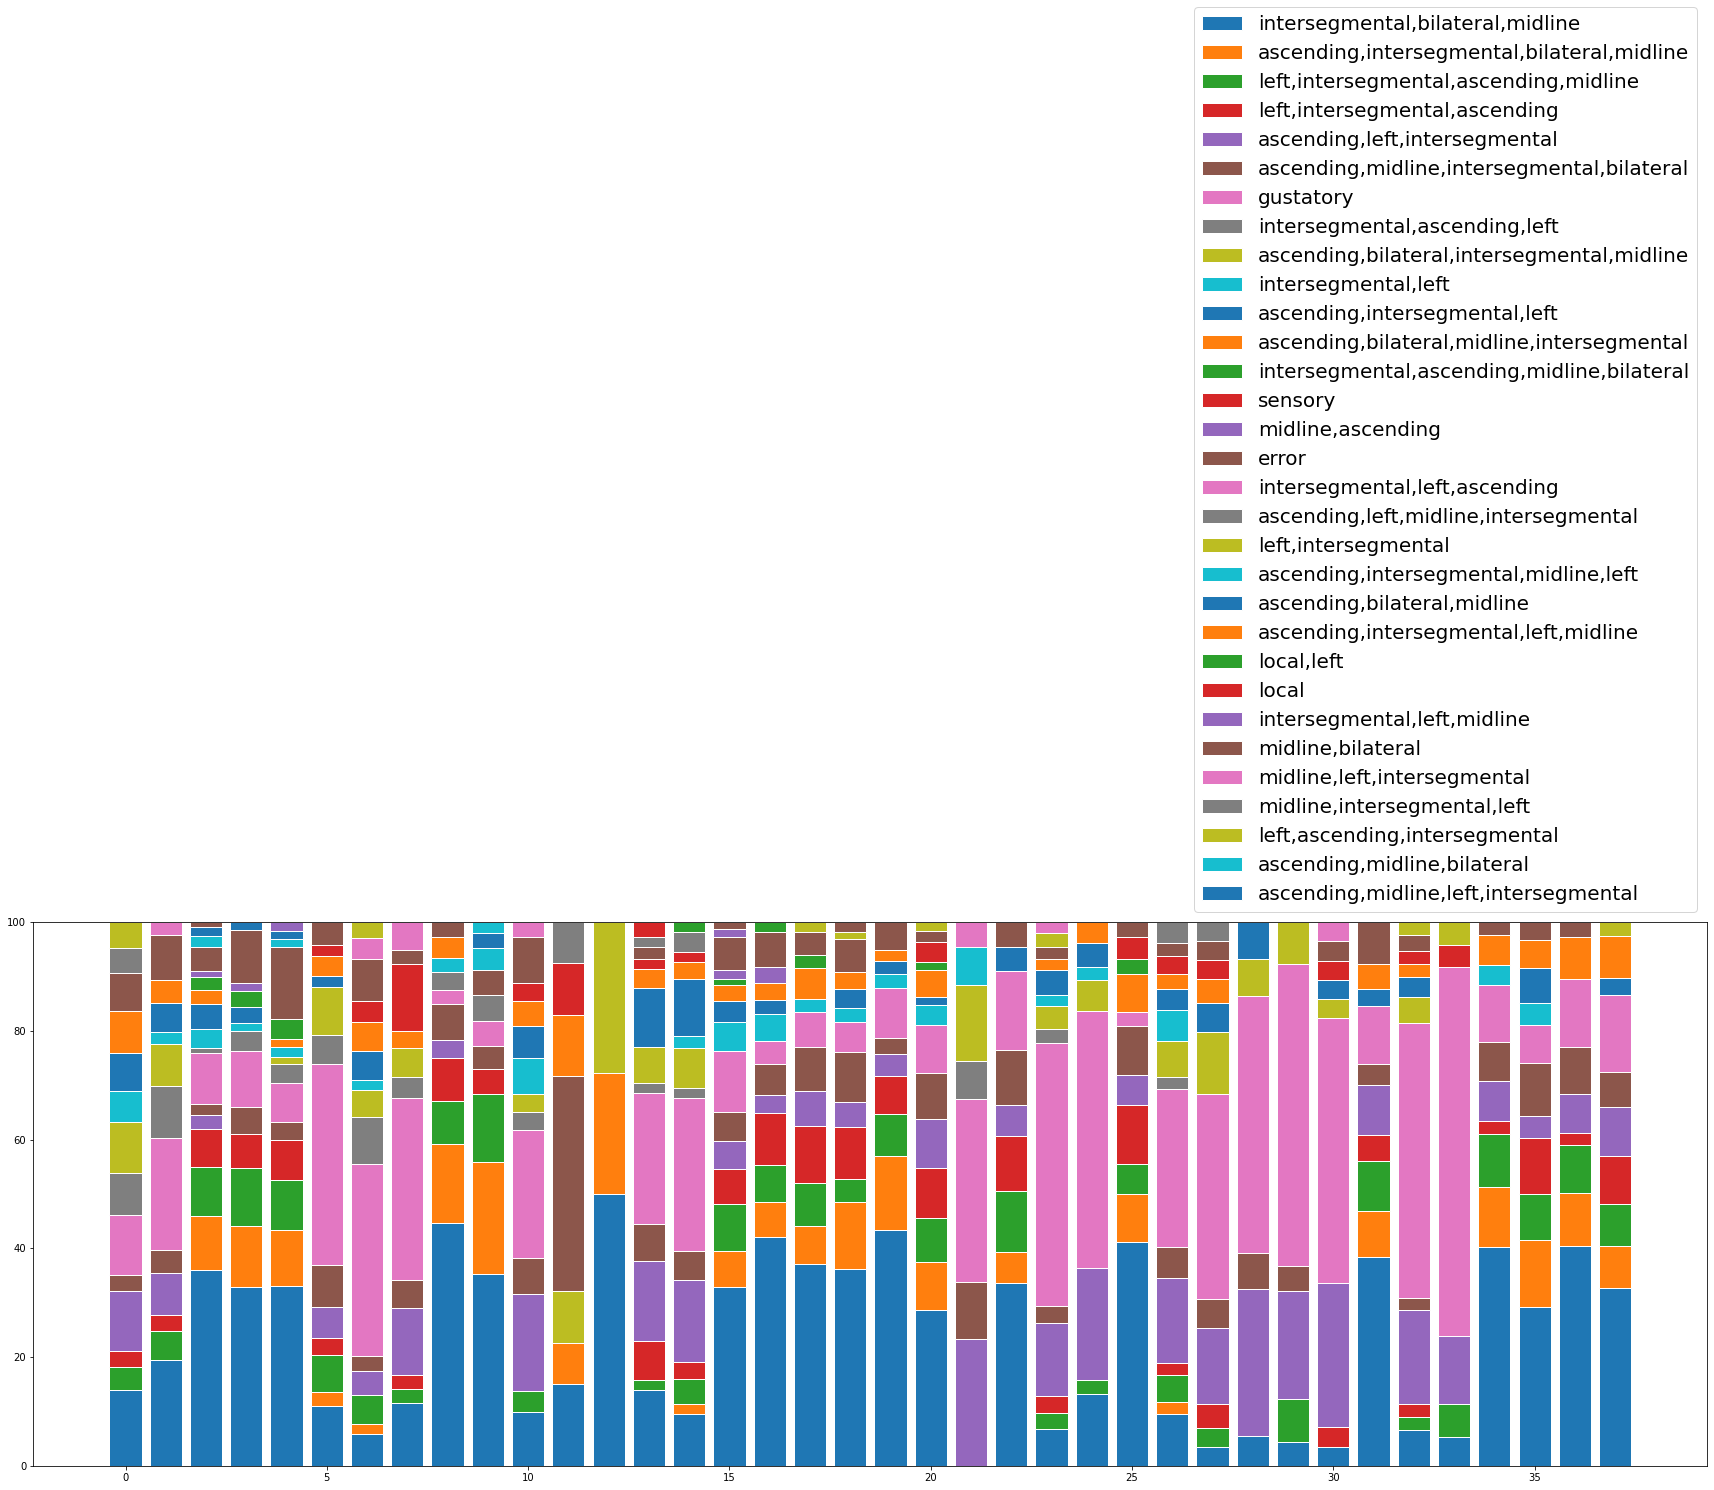

In [66]:
plot_percent_stacked_bar_column(smth1, 'new_class', groupby=['gust_gust_order'])

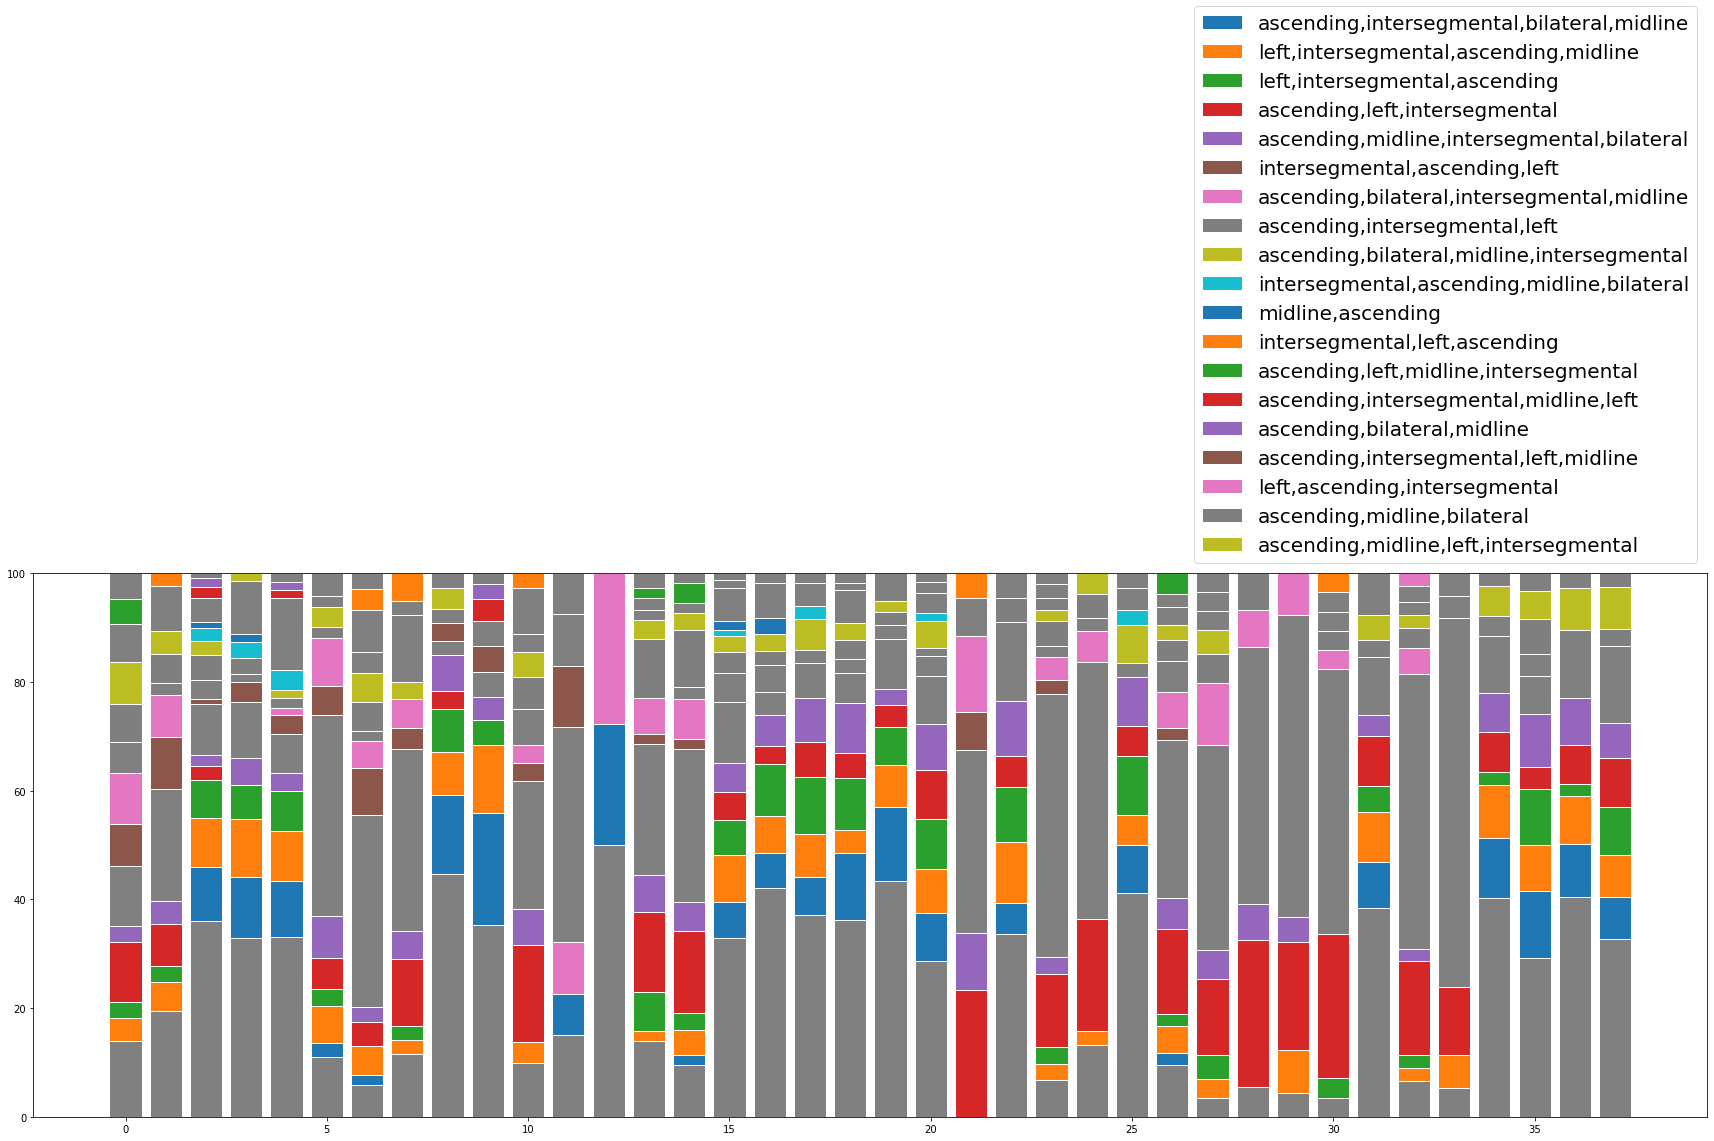

Error in callback <function flush_figures at 0x000001D00951E318> (for post_execute):


KeyboardInterrupt: 

In [67]:
plot_percent_stacked_bar_column(smth1, 'new_class', groupby=['gust_gust_order'], only=all_ascending)
plot_percent_stacked_bar_column(smth1, 'new_class', groupby=['gust_gust_order'], only=intersegmental)
plot_percent_stacked_bar_column(smth1, 'new_class', groupby=['gust_gust_order'], only=not_ascending)
plot_percent_stacked_bar_column(smth1, 'new_class', groupby=['gust_gust_order'], only=midline)

In [68]:
dct1 = dict(zip(gust_downstream_edge.pre_pt_root_id,gust_downstream_edge.order))
dct2 = dict(zip(gust_only_edge.pre_pt_root_id,gust_only_edge.pre_order))

In [69]:
gust_gust_group = {}
for i in range(13):
    gust_gust_group[i] = '1'
for i in range(13,37):
    gust_gust_group[i] = '2'

In [70]:
df_gust_group = pd.DataFrame(index=dct1.keys(), columns=['gust_downstream_order'], data=dct1.values()).reset_index()
df_gust_group = df_gust_group.rename({'index':'pre_pt_root_id'}, axis='columns')
df_gust_group['gust_downstream_group'] = df_gust_group['gust_downstream_order'].map(gust_downstream_group)
df_gust_group['gust_gust_order'] = df_gust_group['pre_pt_root_id'].map(dct2)
df_gust_group['gust_gust_group'] = df_gust_group['gust_gust_order'].map(gust_gust_group)

In [71]:
df_gust_group_edge = df_gust_group.groupby(['gust_downstream_group','gust_gust_group'],
             dropna=True).size().sort_values(ascending=False).reset_index(name='count')

<AxesSubplot:xlabel='gust_downstream_group', ylabel='Proportion'>

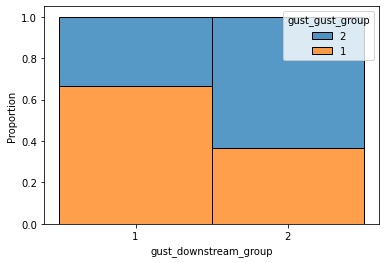

In [72]:
sns.histplot(df_gust_group[df_gust_group.gust_downstream_group=='1'], x='gust_downstream_group', 
             stat='proportion', hue='gust_gust_group',multiple='stack', hue_order=["1","2"])
sns.histplot(df_gust_group[df_gust_group.gust_downstream_group=='2'], x='gust_downstream_group', 
             stat='proportion', hue='gust_gust_group',multiple='stack')

<AxesSubplot:xlabel='gust_gust_group', ylabel='Proportion'>

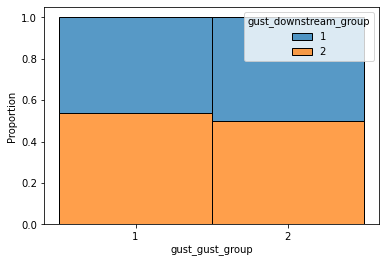

In [73]:
sns.histplot(df_gust_group[df_gust_group.gust_gust_group=='1'], x='gust_gust_group', 
             stat='proportion', hue='gust_downstream_group',multiple='stack', hue_order=["1","2"])
sns.histplot(df_gust_group[df_gust_group.gust_gust_group=='2'], x='gust_gust_group', 
             stat='proportion', hue='gust_downstream_group',multiple='stack',hue_order=["1","2"])

## Characterizing each gust from gust_gust based on gust connectivity to other gust

In [74]:
# how to pick between different classes? (Ward linkage)
## label them on VNC with different colors?
## checks to see (the most common) downstream partners each group is connected to

# Question: the argument is that there is high connectivity within one subclass of GRNs, then the downstream partners of GRNs
# should not be relevant (or rather, each subclass of GRNs could connect to the same class of downstream partner or different 
# classes of downstream partners equally)? Then, why should we look for the most common downstream partner of each subclass? 

Text(0, 0.5, 'Number of Connections')

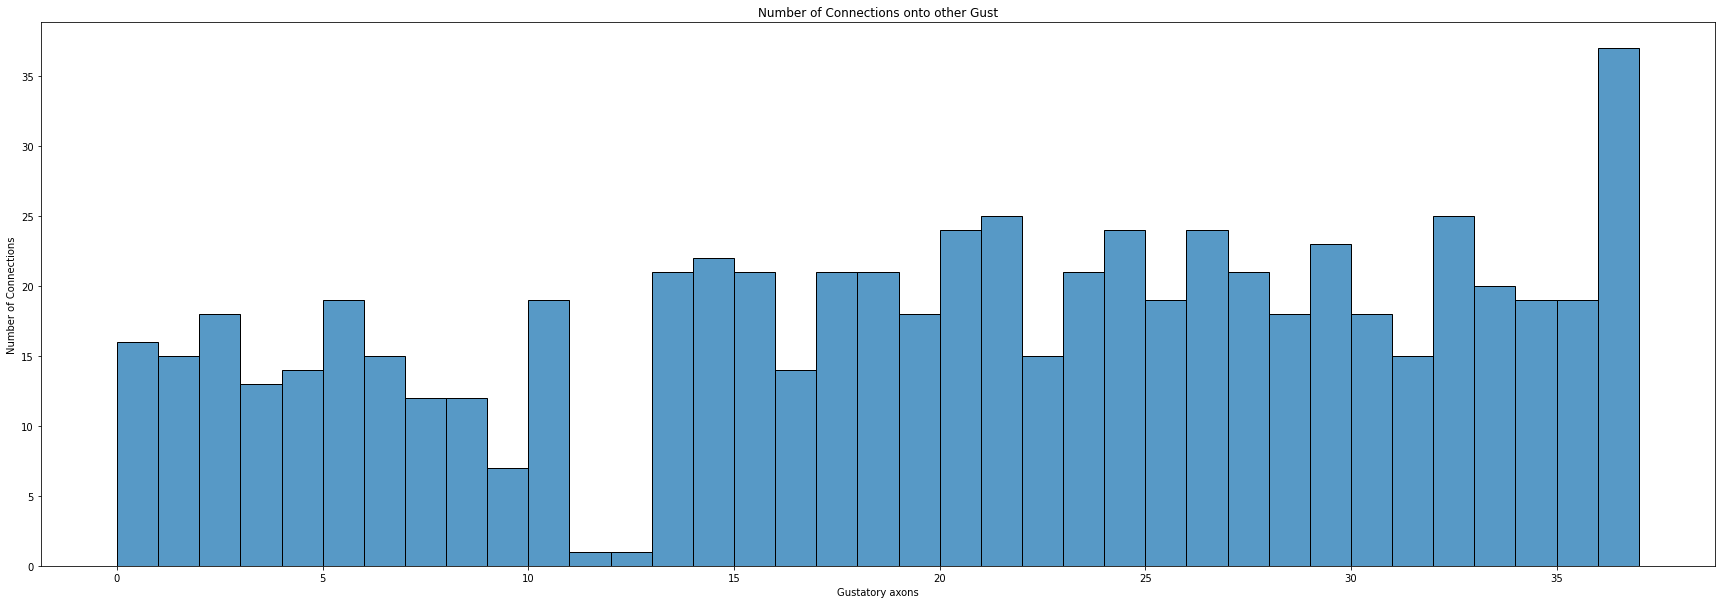

In [75]:
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)

sns.histplot(data=gust_only_edge, ax=ax,
             x="pre_order", bins = 37,
             palette="Paired", 
             element="bars", legend=True)
ax.set_title("Number of Connections onto other Gust")
ax.set_xlabel("Gustatory axons")
ax.set_ylabel("Number of Connections") # number of partners connected to
# sns.move_legend(ax, "upper right",frameon=False,bbox_to_anchor=(1.15, 1))

In [76]:
gust_syn = gust_only_edge.groupby(['pre_order']).sum().reset_index()

Text(0, 0.5, 'Number of Connections')

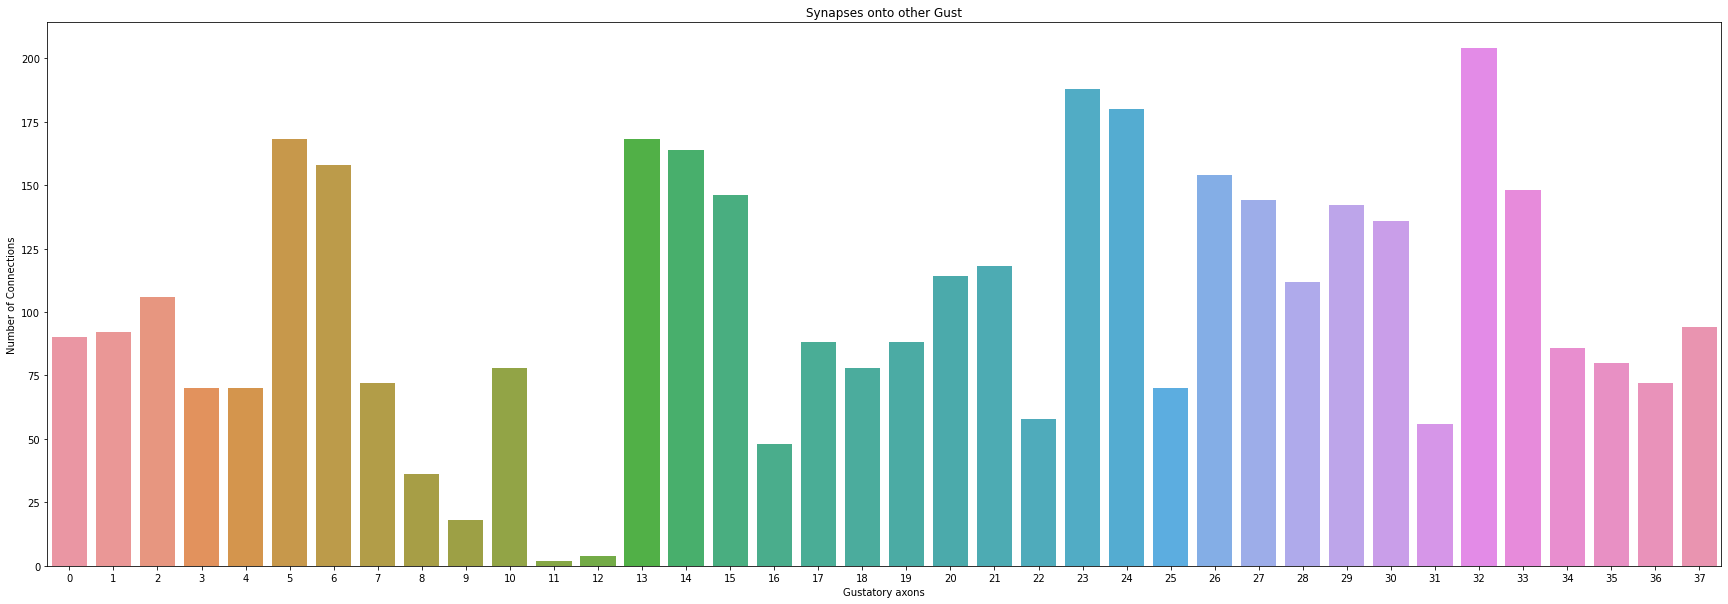

In [77]:
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)

sns.barplot(data=gust_syn, x="pre_order",y="count",ax=ax)
ax.set_title("Synapses onto other Gust")
ax.set_xlabel("Gustatory axons")
ax.set_ylabel("Number of Connections") # number of partners connected to
# sns.move_legend(ax, "upper right",frameon=False,bbox_to_anchor=(1.15, 1))

In [78]:
# barplots of "Number of Synapses onto other Gust of a Gust"
def barplot_a_gust(pre_order, df, normalized = True):
    if normalized:
        f = plt.figure(figsize=(30,10))
        ax = f.add_subplot(1,1,1)
        df = df[df.pre_order == pre_order]
        sns.barplot(data=df, x="post_order", y="count",ax=ax)
        ax.set_title(f"Synapses onto other Gust of {pre_order}")
        ax.set_xlabel("Gustatory axon")
        ax.set_ylabel("Number of Connections") # number of partners connected to
        plt.ylim(0, 30)
    else:
        f = plt.figure(figsize=(30,10))
        ax = f.add_subplot(1,1,1)
        df = df[df.pre_order == pre_order]
        sns.barplot(data=df, x="post_order", y="count",ax=ax)
        ax.set_title(f"Synapses onto other Gust of {pre_order}")
        ax.set_xlabel("Gustatory axon")
        ax.set_ylabel("Number of Connections") # number of partners connected to

In [79]:
def get_full_edge(df, ids_map):
    pre_order_lst = [*df.pre_order.unique()]
    post_order_lst = [*df.post_order.unique()]
    for i in pre_order_lst:
        for j in post_order_lst:
            if df.loc[(df.pre_order == i) & (df.post_order == j)]['count'].size < 1:
                df2 = pd.DataFrame(np.array([[[g for g in ids_map if ids_map[g]==i], 
                                              [g for g in ids_map if ids_map[g]==j],
                                               0, i, j]]), 
                                   columns=['pre_pt_root_id', 'post_pt_root_id', 'count', 'pre_order', 'post_order'])
                df = pd.concat([df, df2])
    return df

In [80]:
edge_with_zeros = get_full_edge(gust_only_edge, ids_map_gust_gust)

C:\Users\trnan\anaconda3\envs\micronsbinder\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


In [81]:
edge_with_zeros

,pre_pt_root_id,post_pt_root_id,count,pre_order,post_order,category
0,648518346500687795,648518346496828461,44,13,14,1
1,648518346512198702,648518346520556598,38,6,0,0
2,648518346483328588,648518346511221557,28,5,4,2
3,648518346481688735,648518346517576040,28,32,29,2
4,648518346500687795,648518346490221320,28,13,16,1
...,...,...,...,...,...,...
0,[648518346467148526],[648518346493968782],0,11,21,NaN
0,[648518346467148526],[648518346477699735],0,11,33,NaN
0,[648518346467148526],[648518346467006190],0,11,27,NaN
0,[648518346467148526],[648518346487789524],0,11,7,NaN


C:\Users\trnan\anaconda3\envs\micronsbinder\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


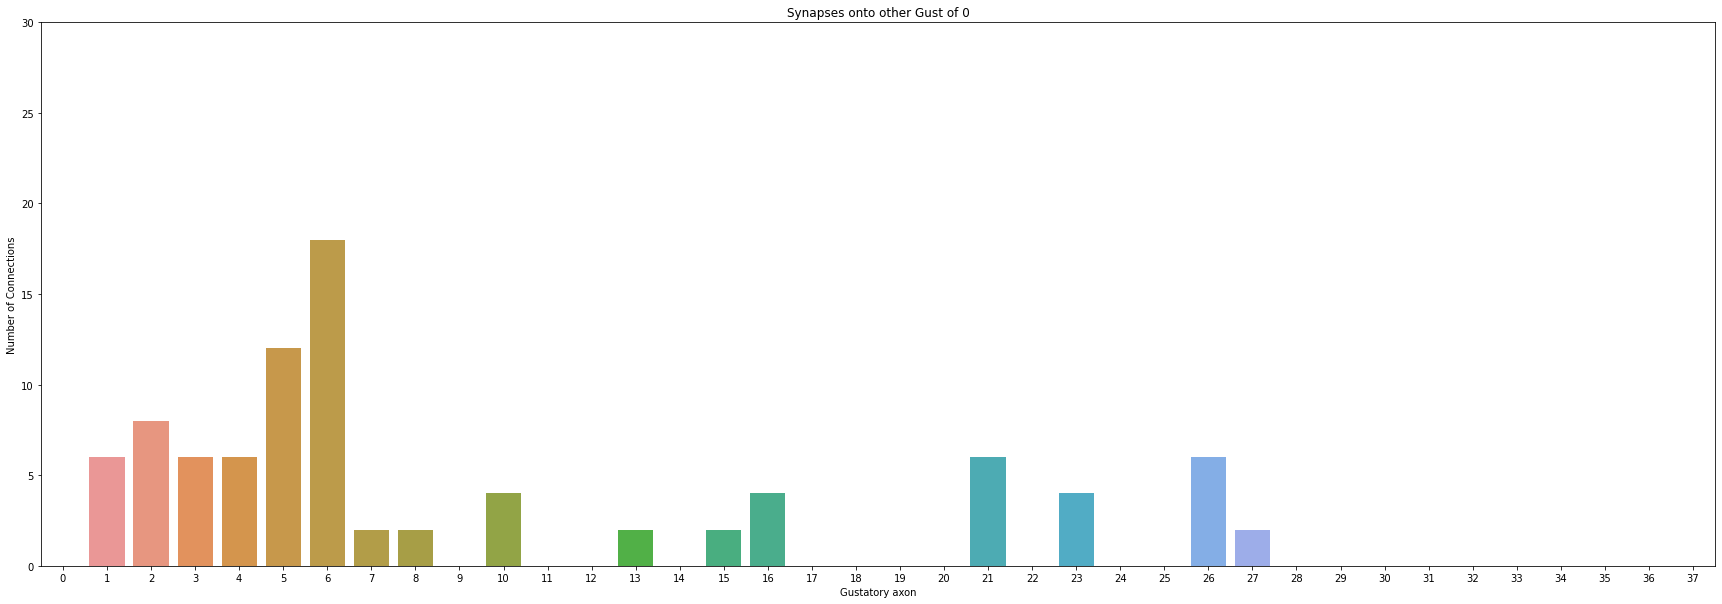

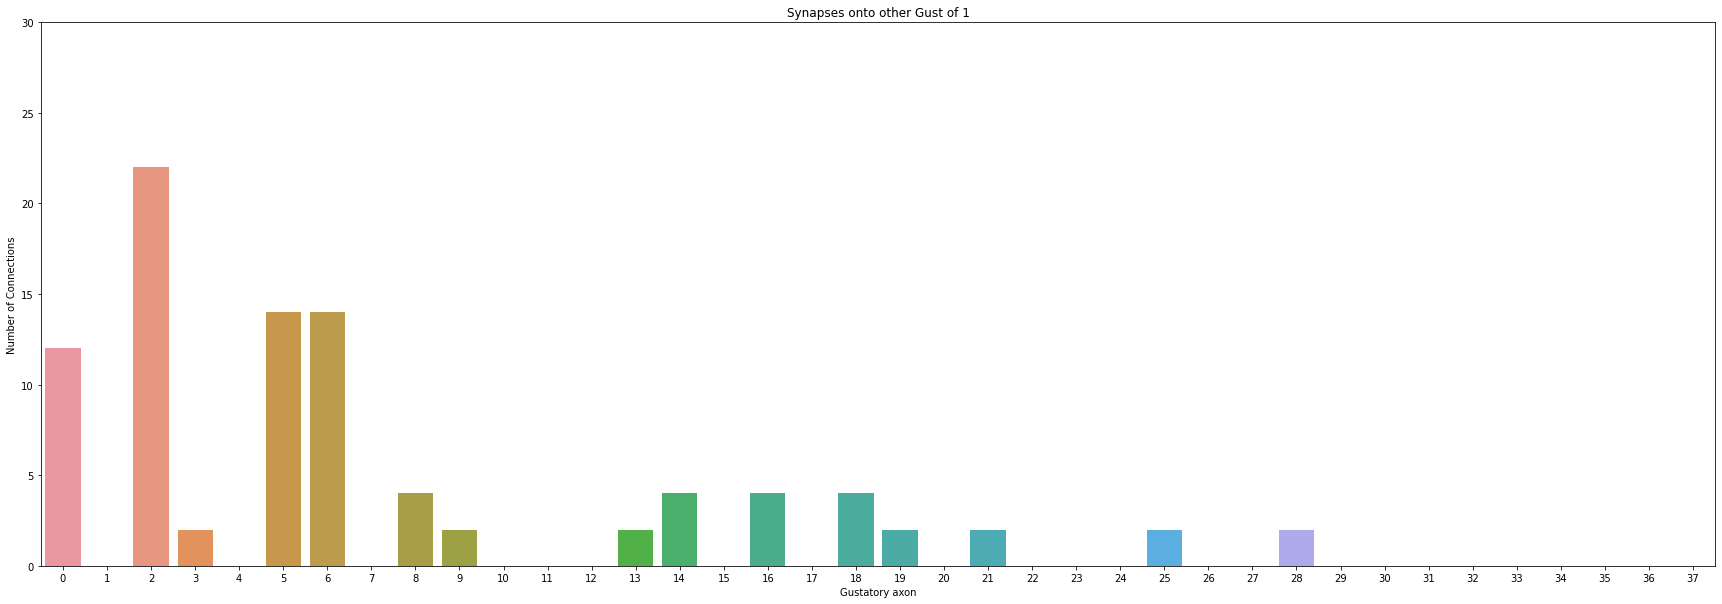

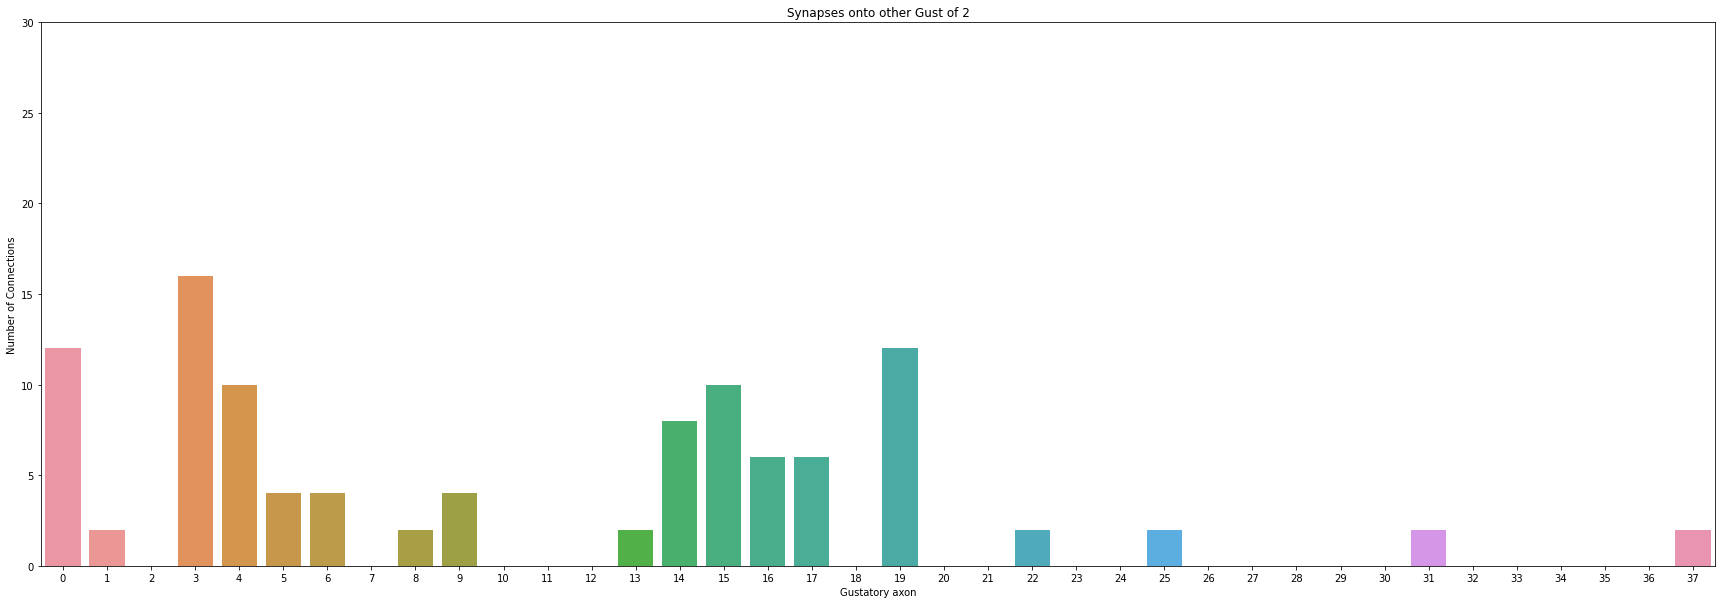

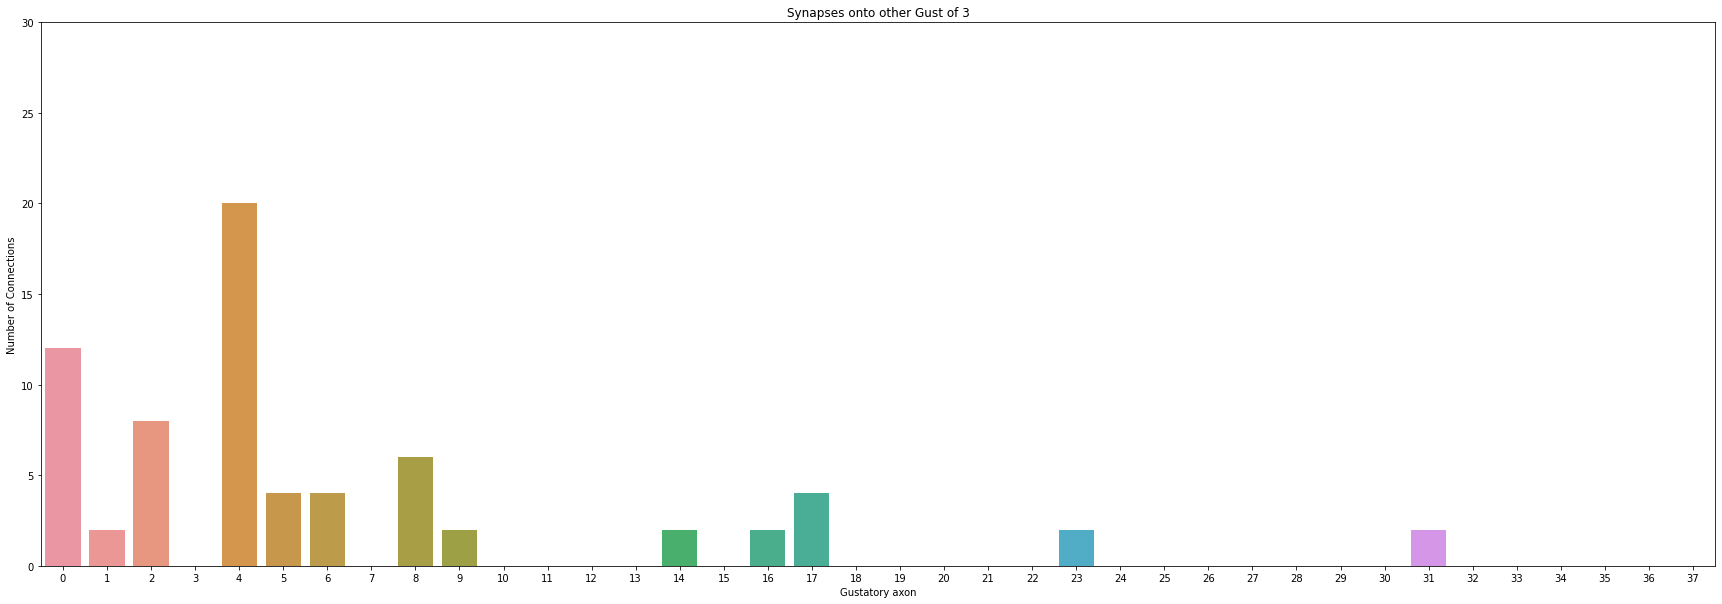

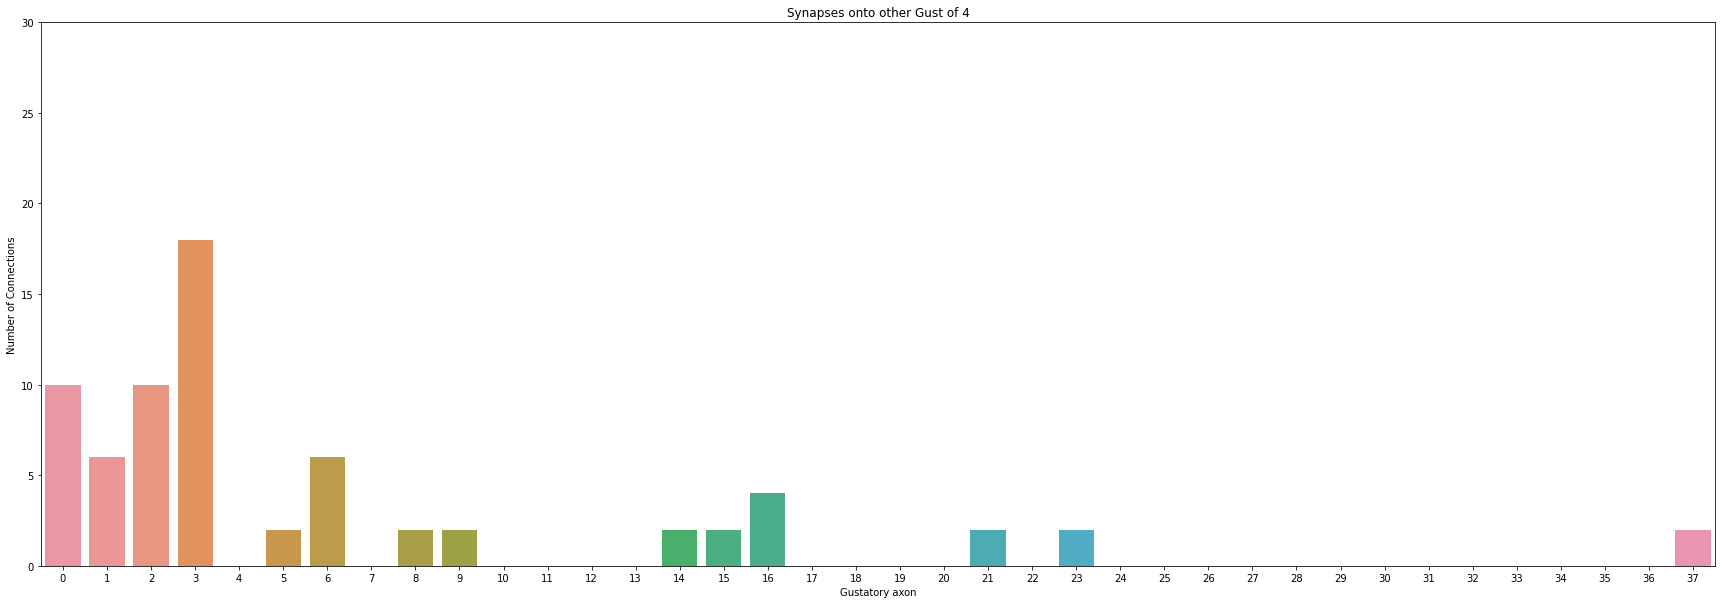

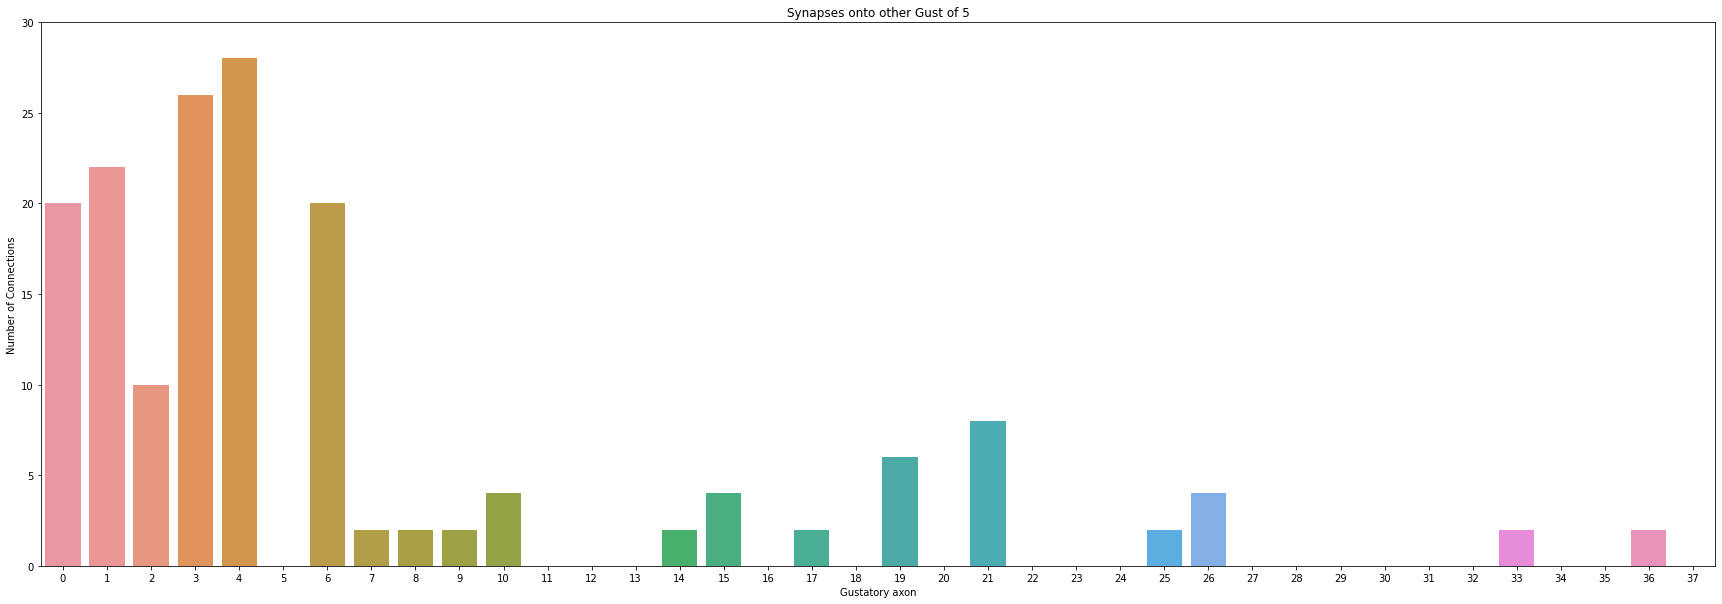

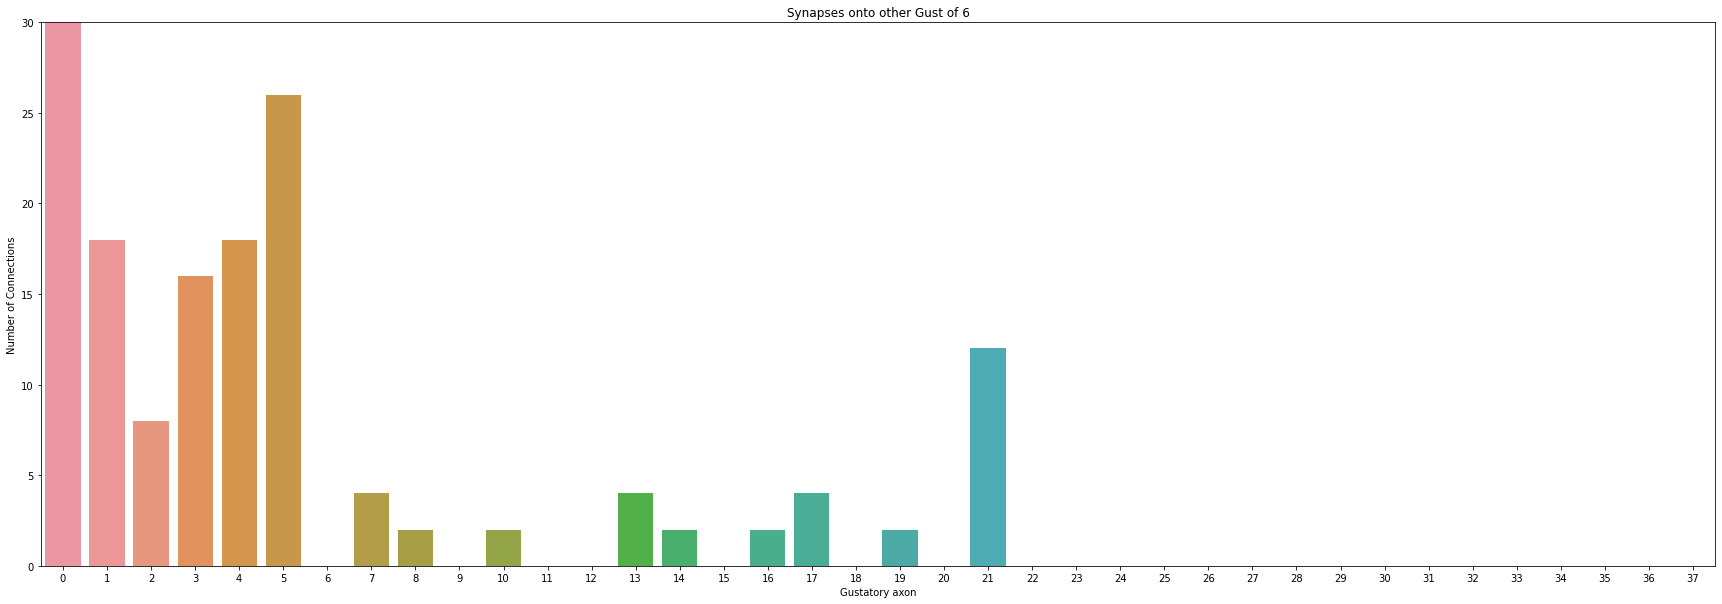

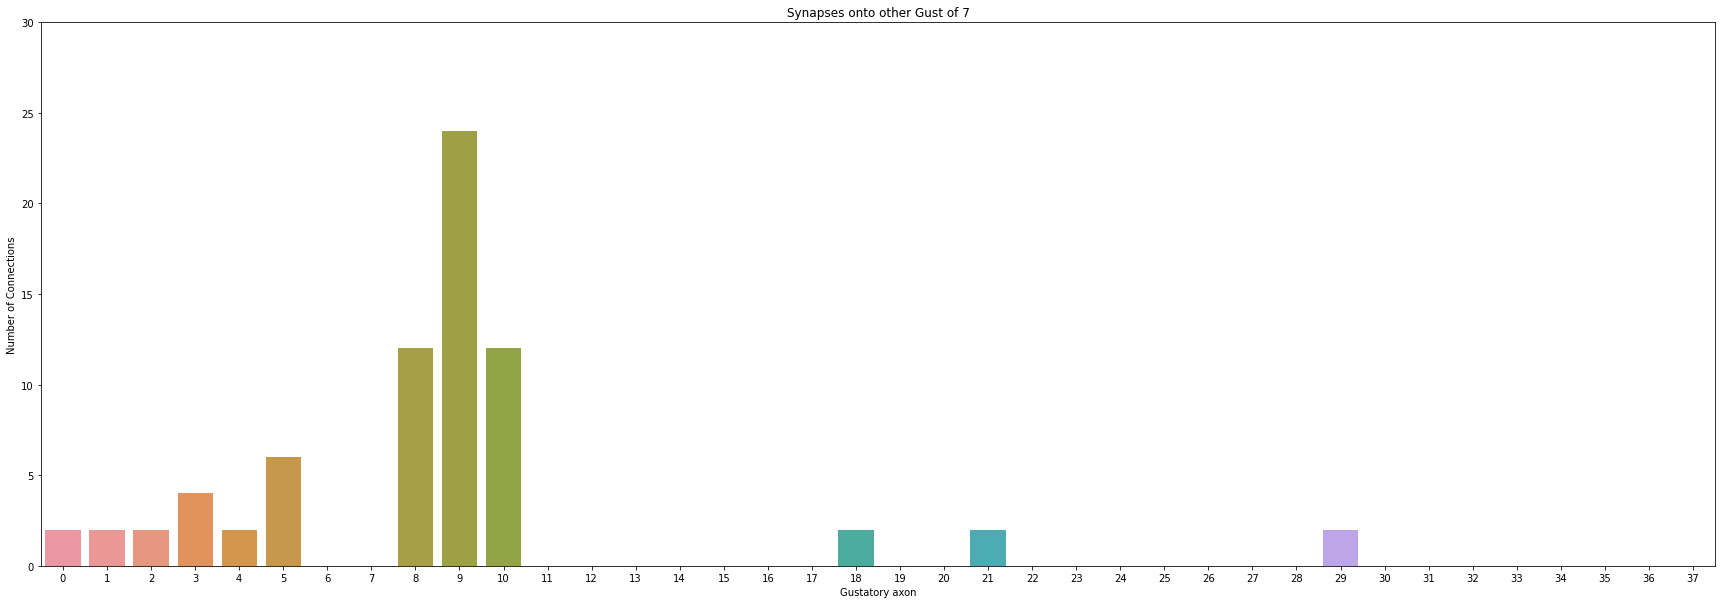

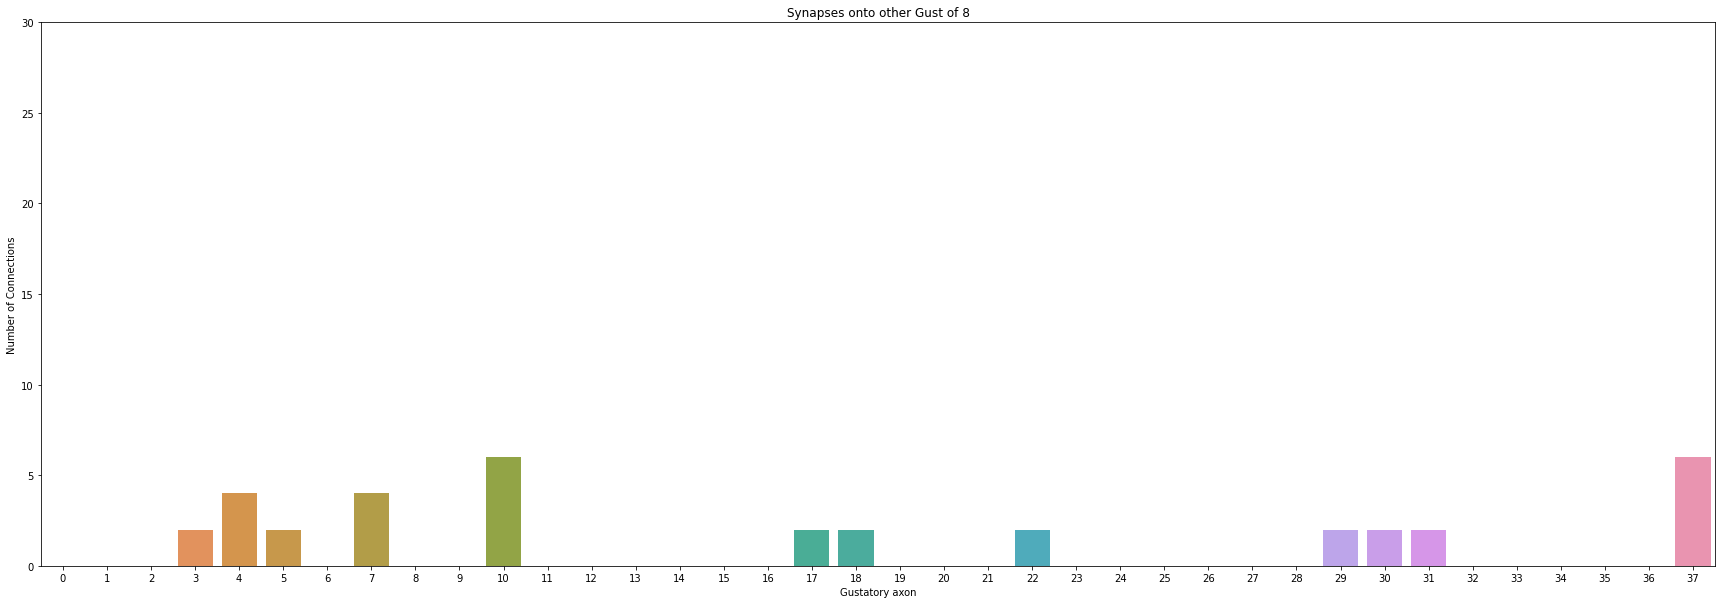

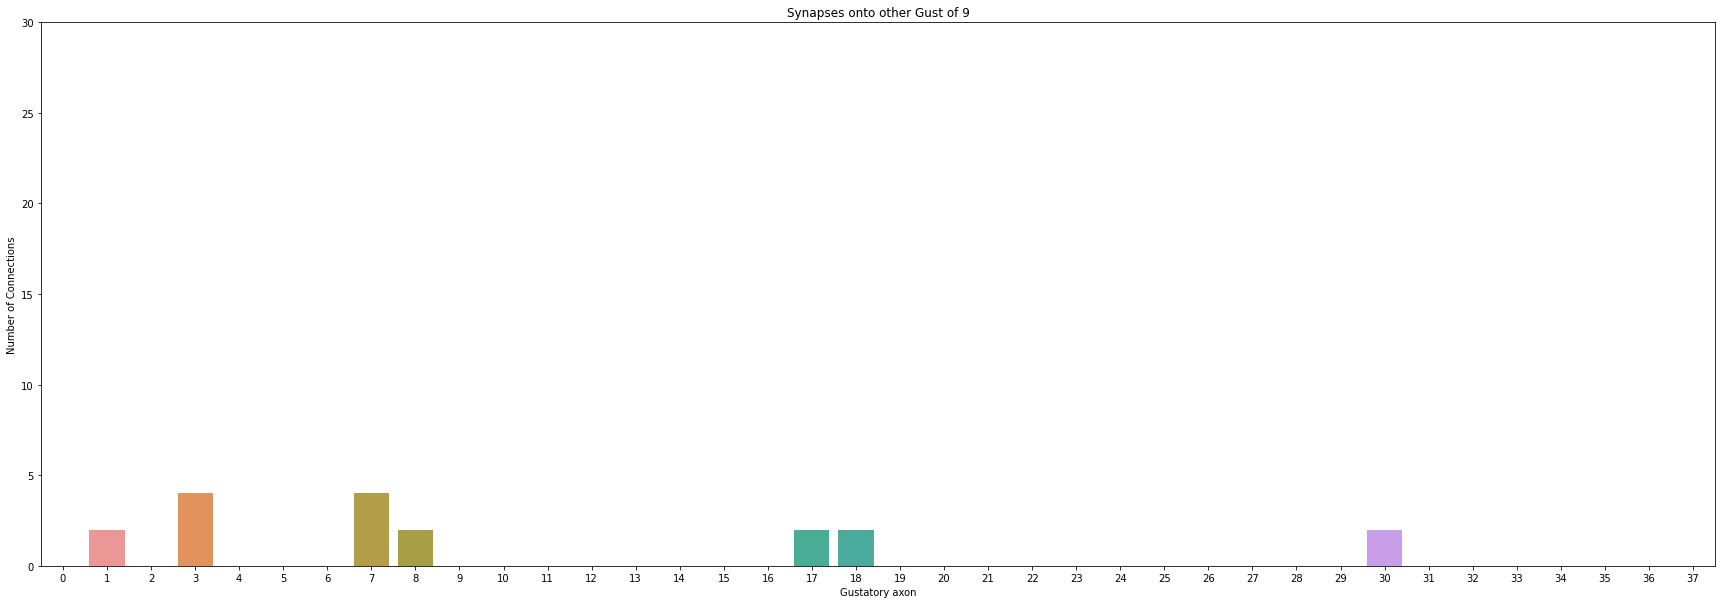

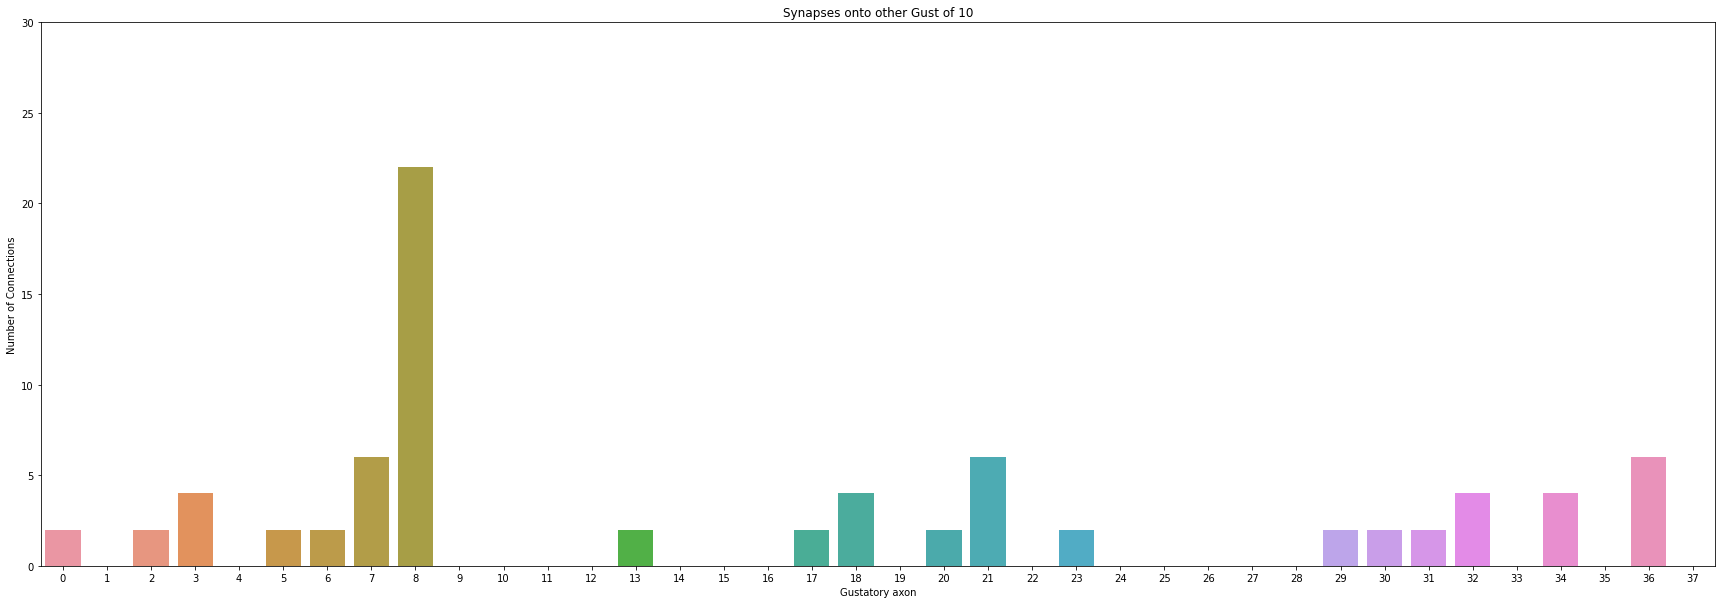

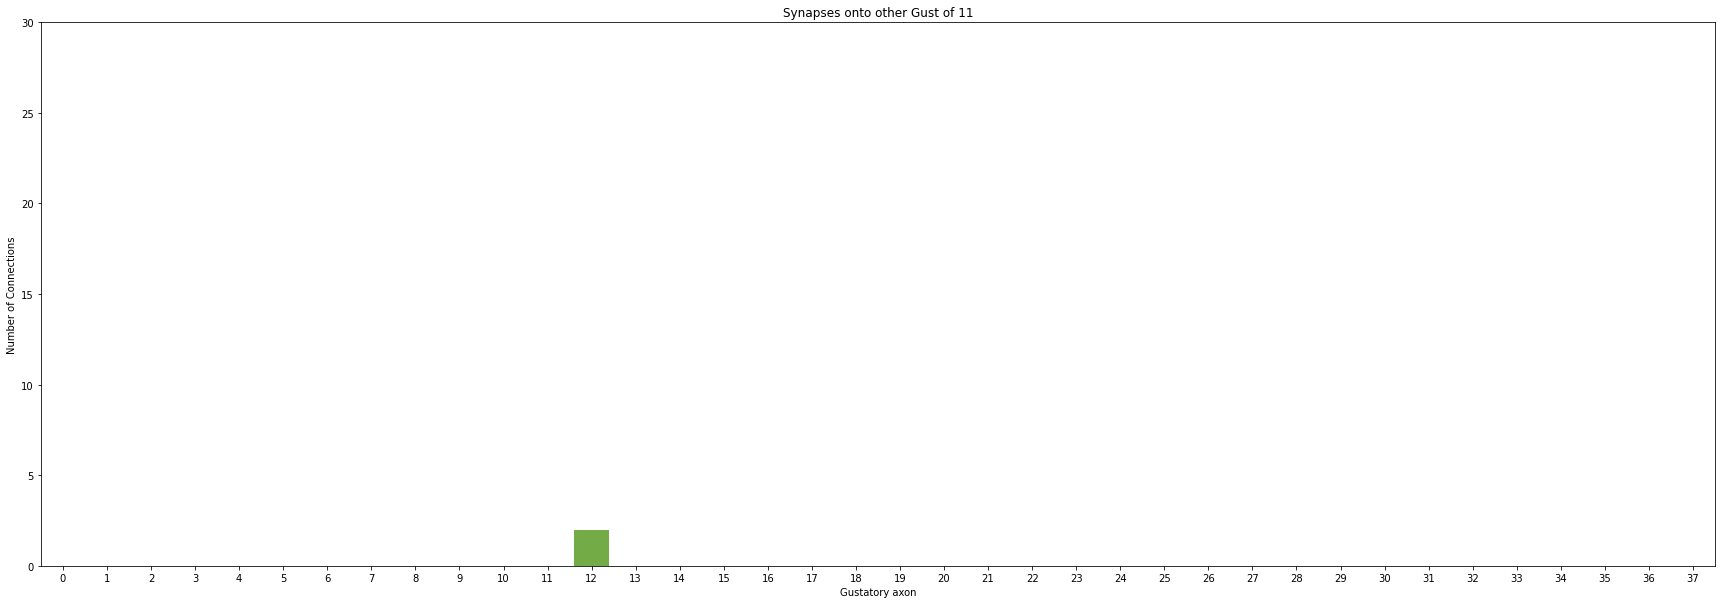

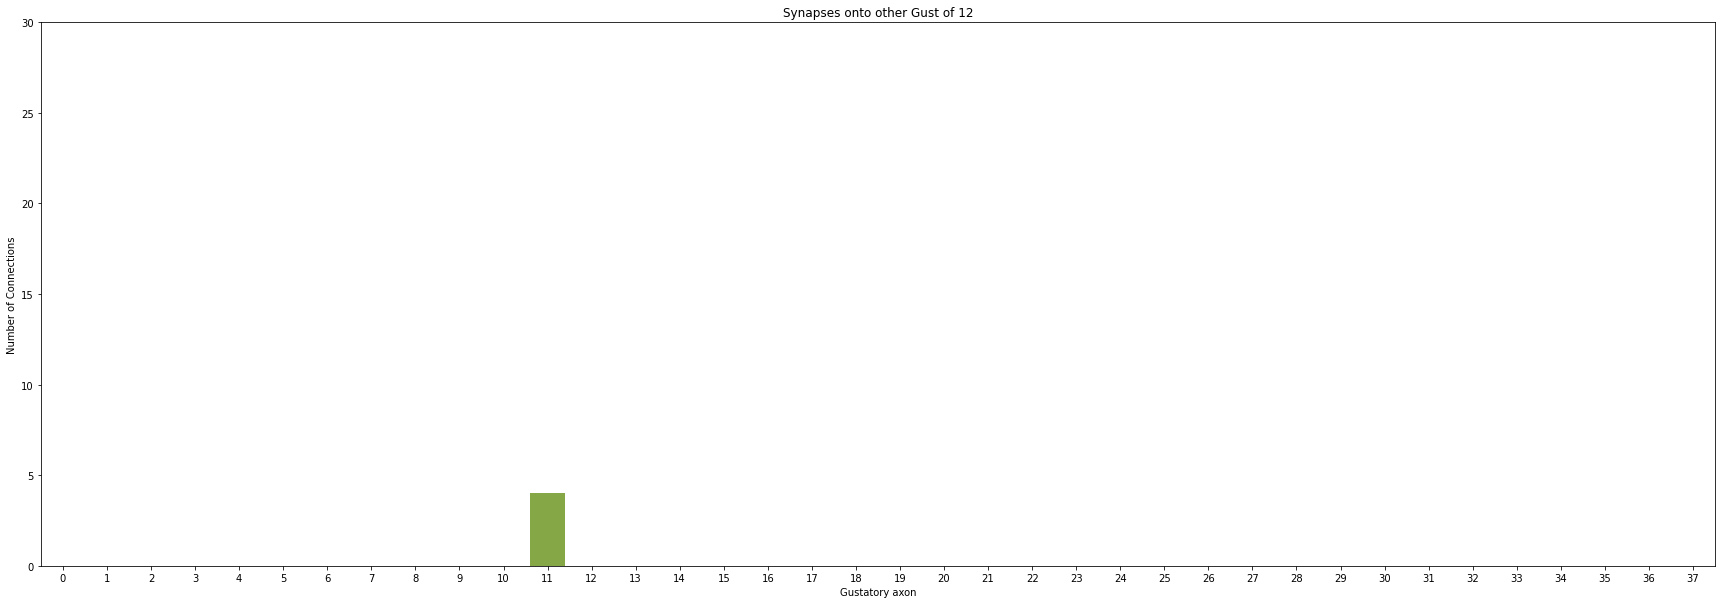

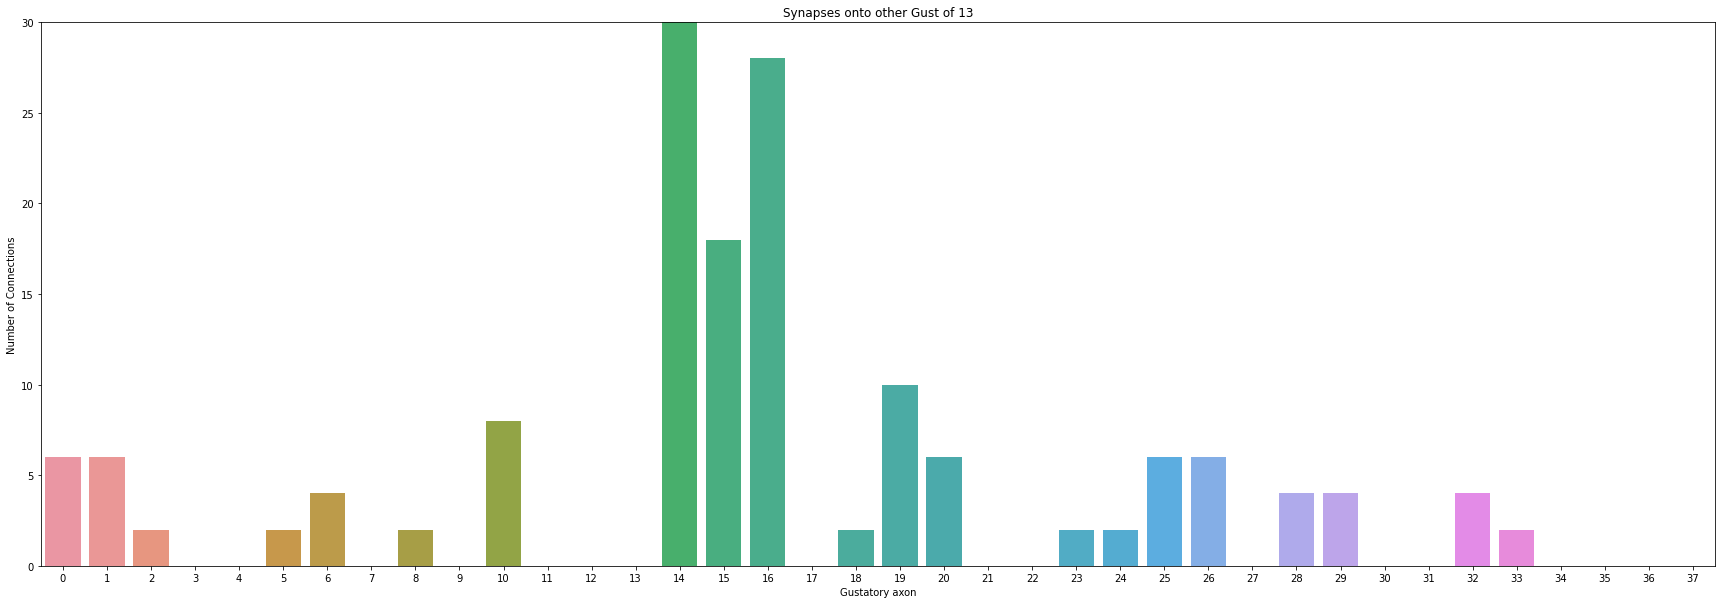

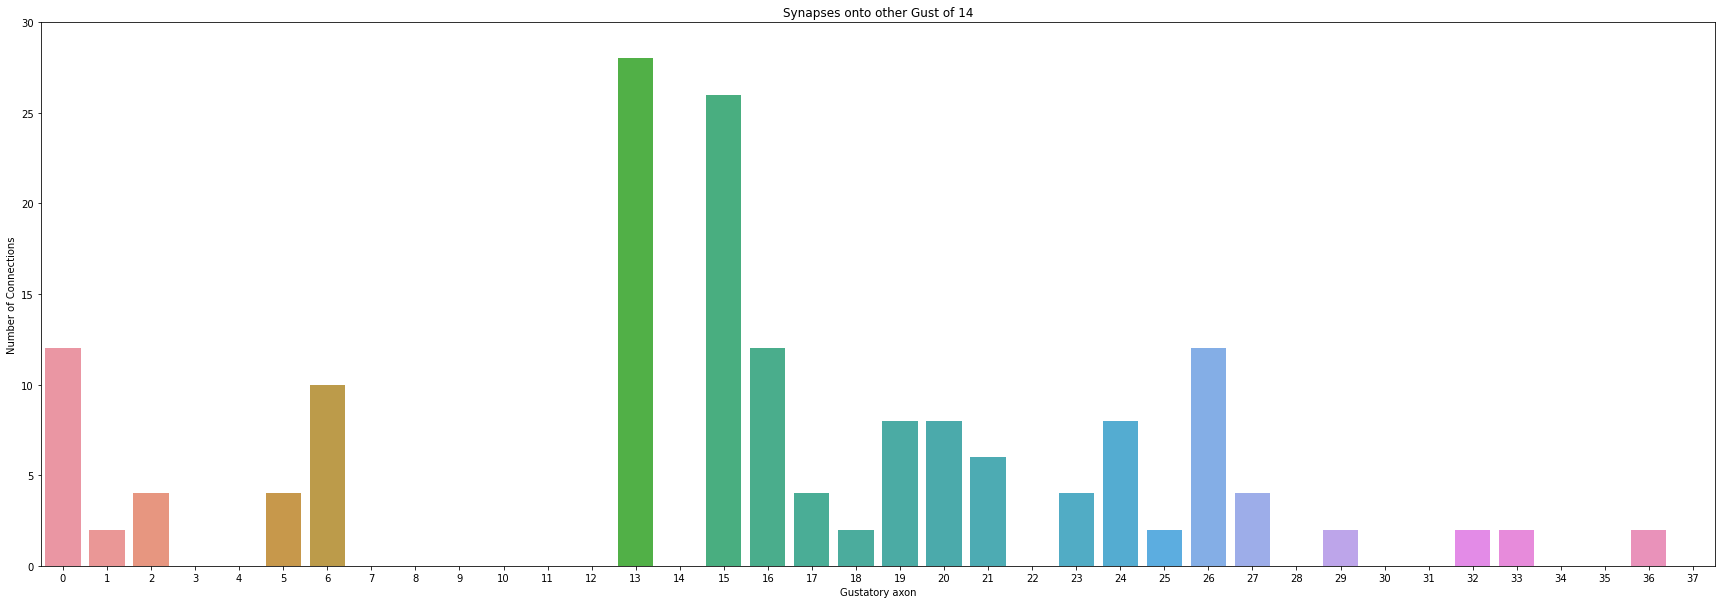

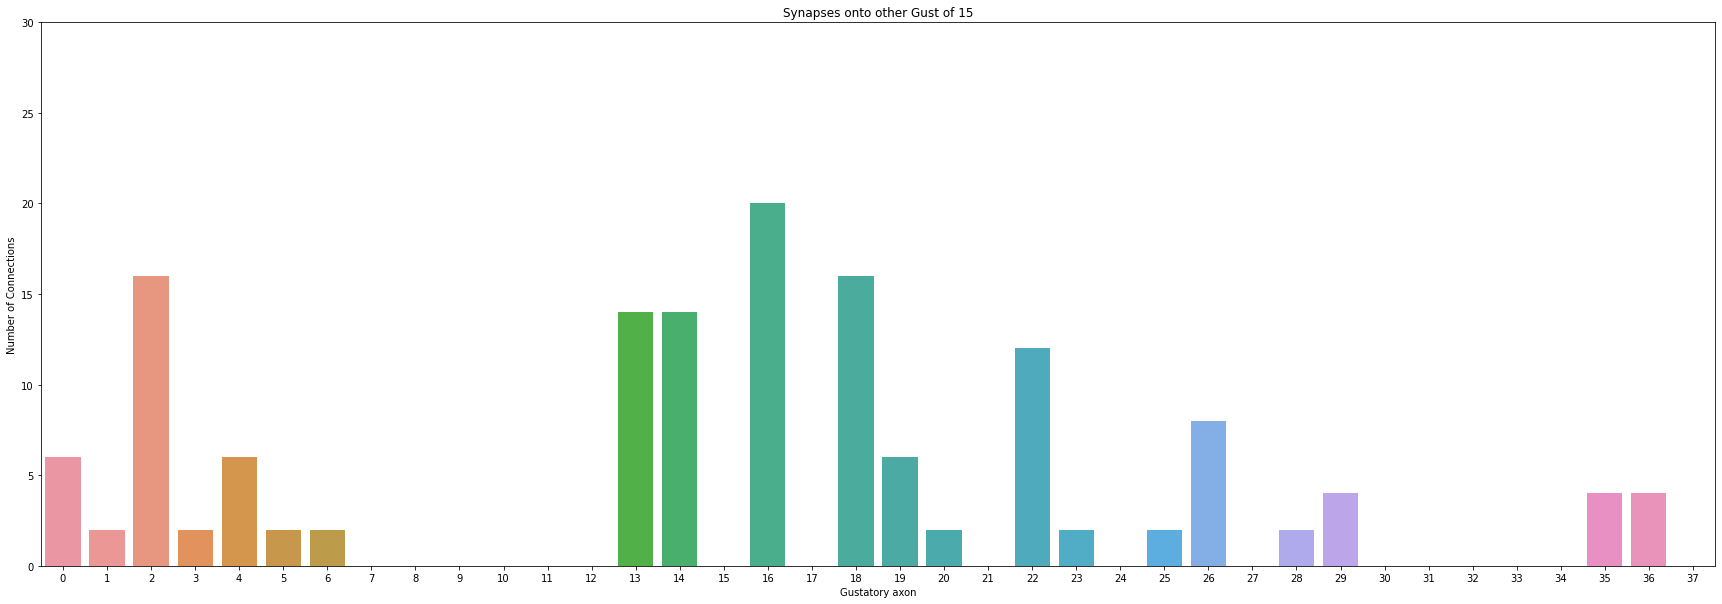

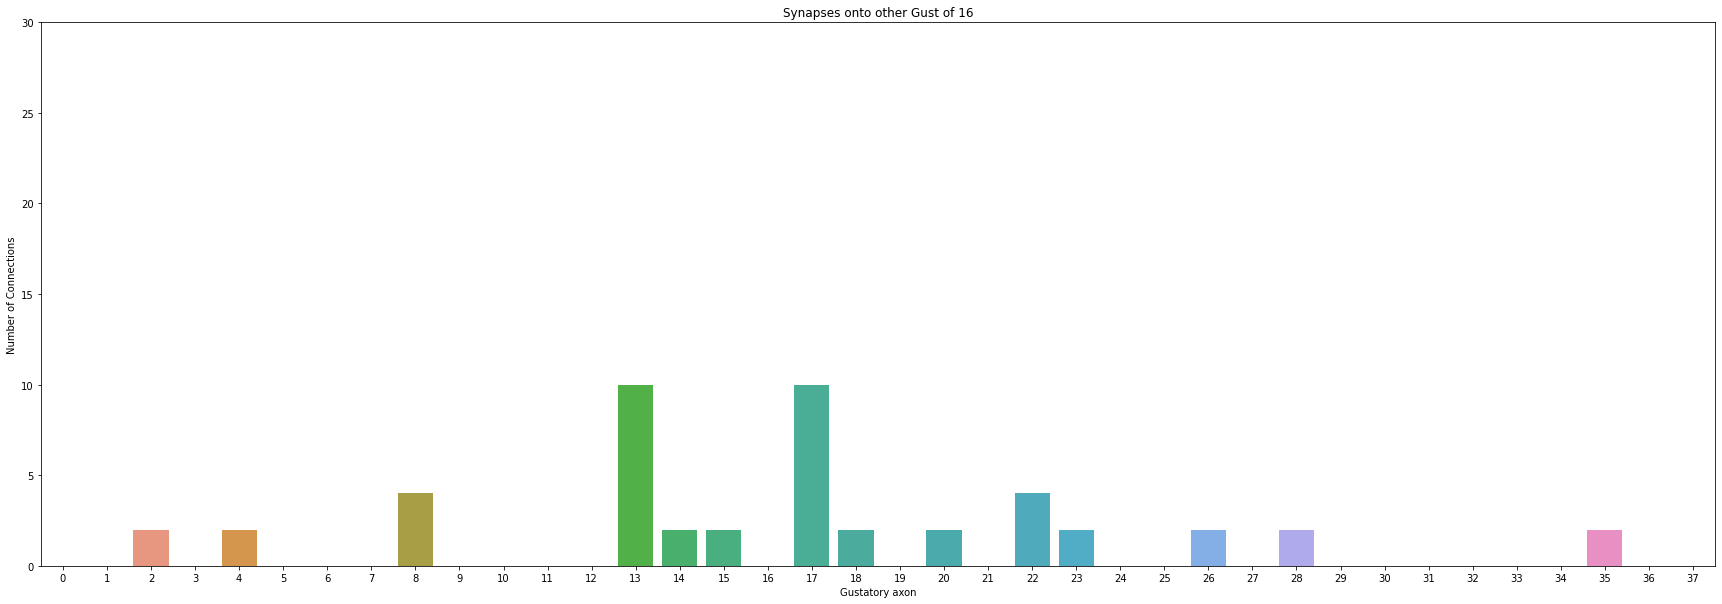

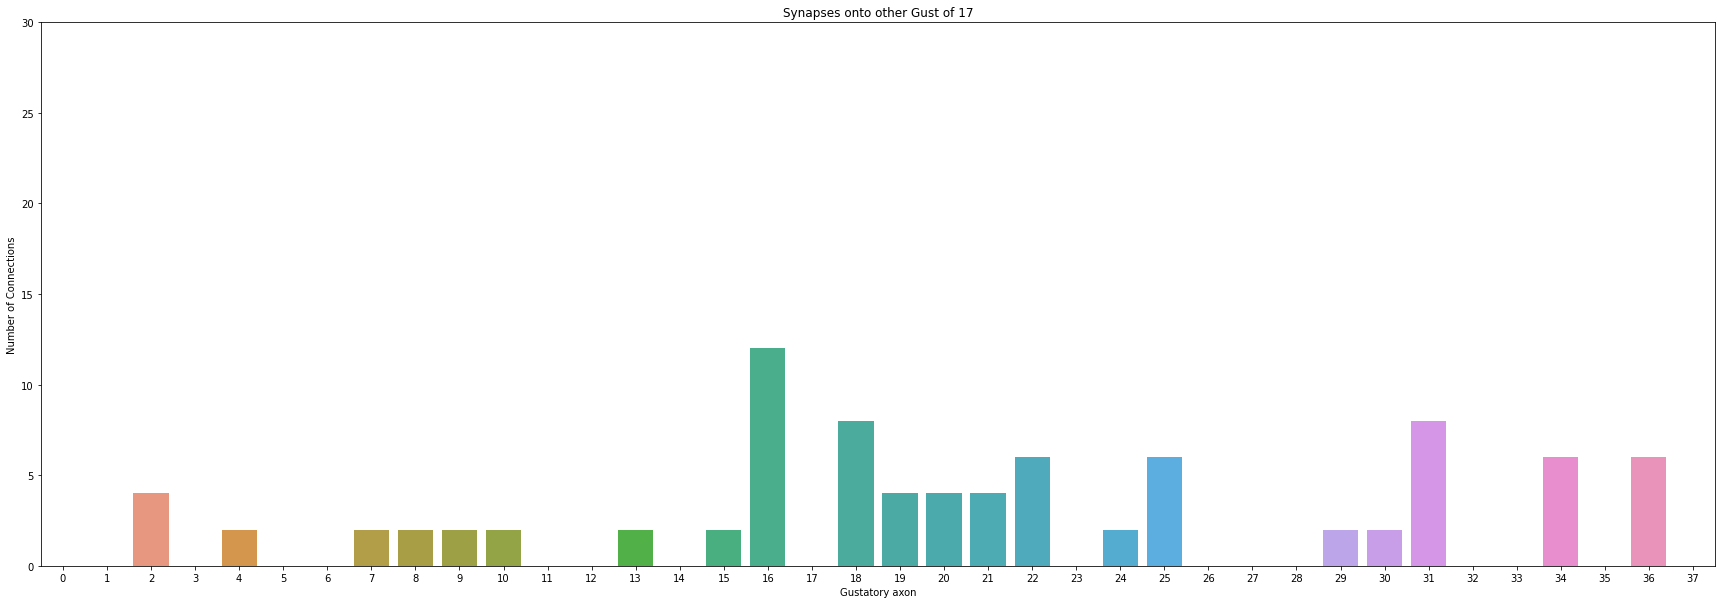

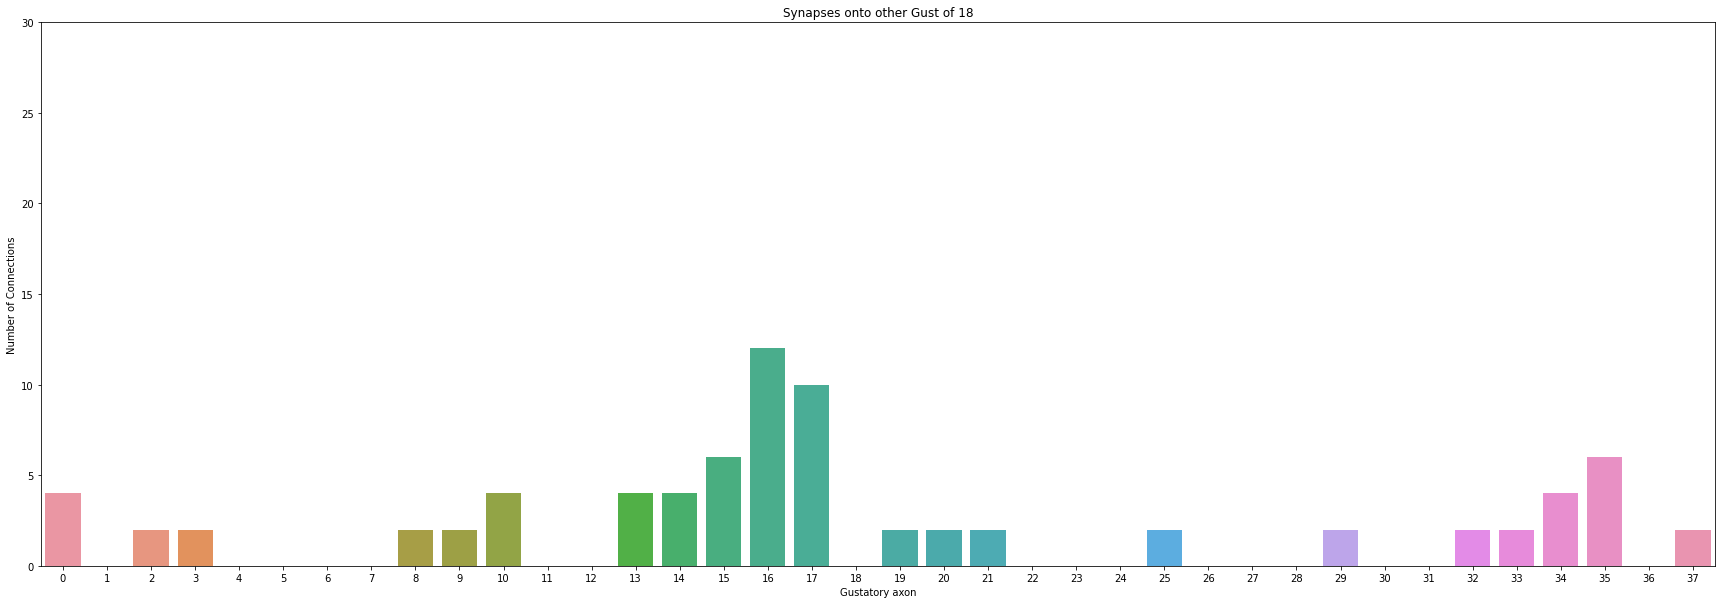

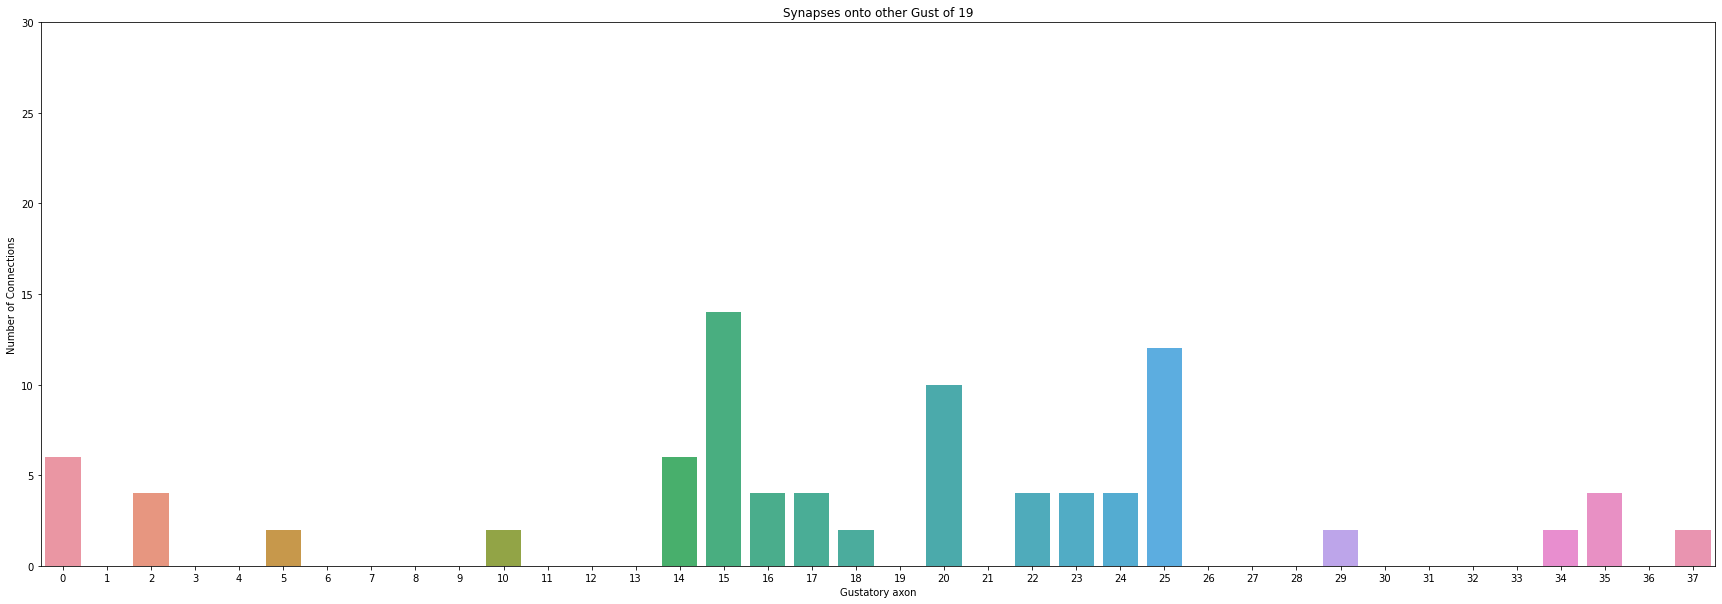

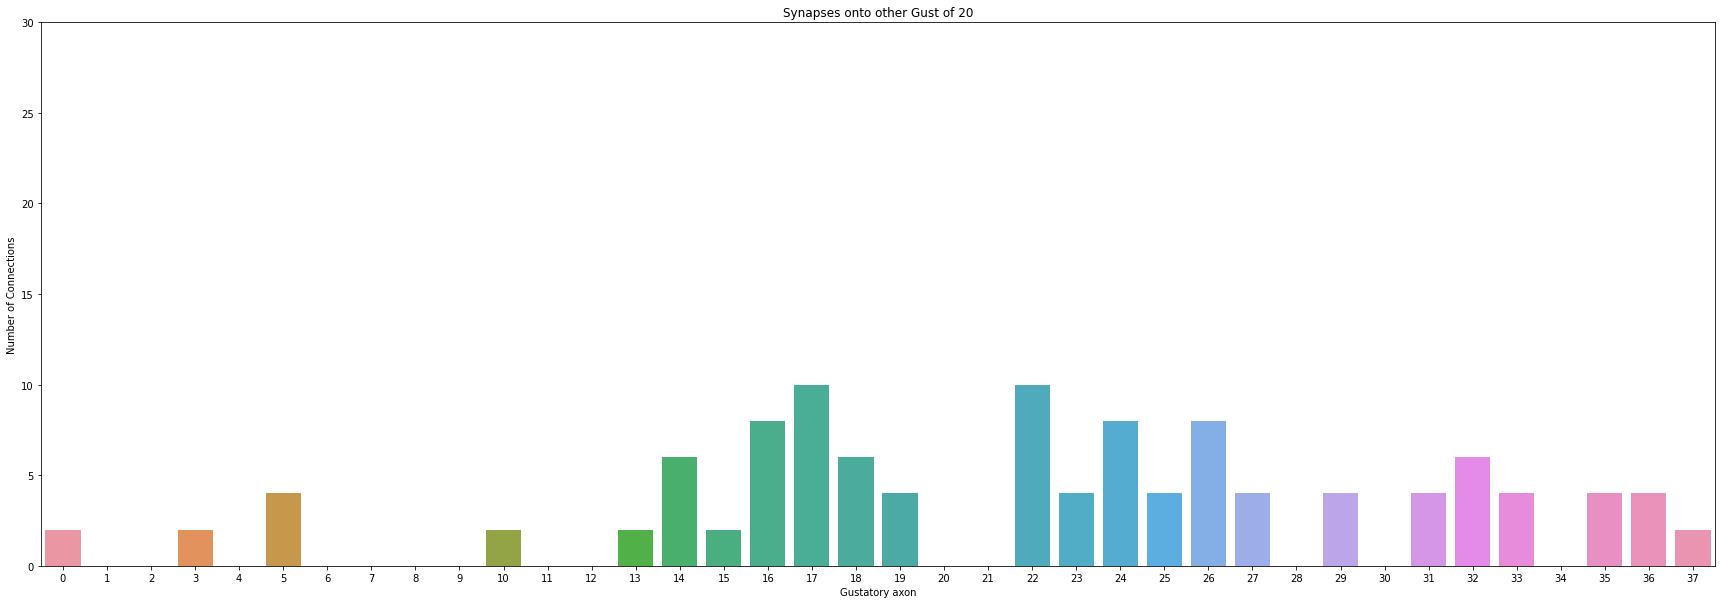

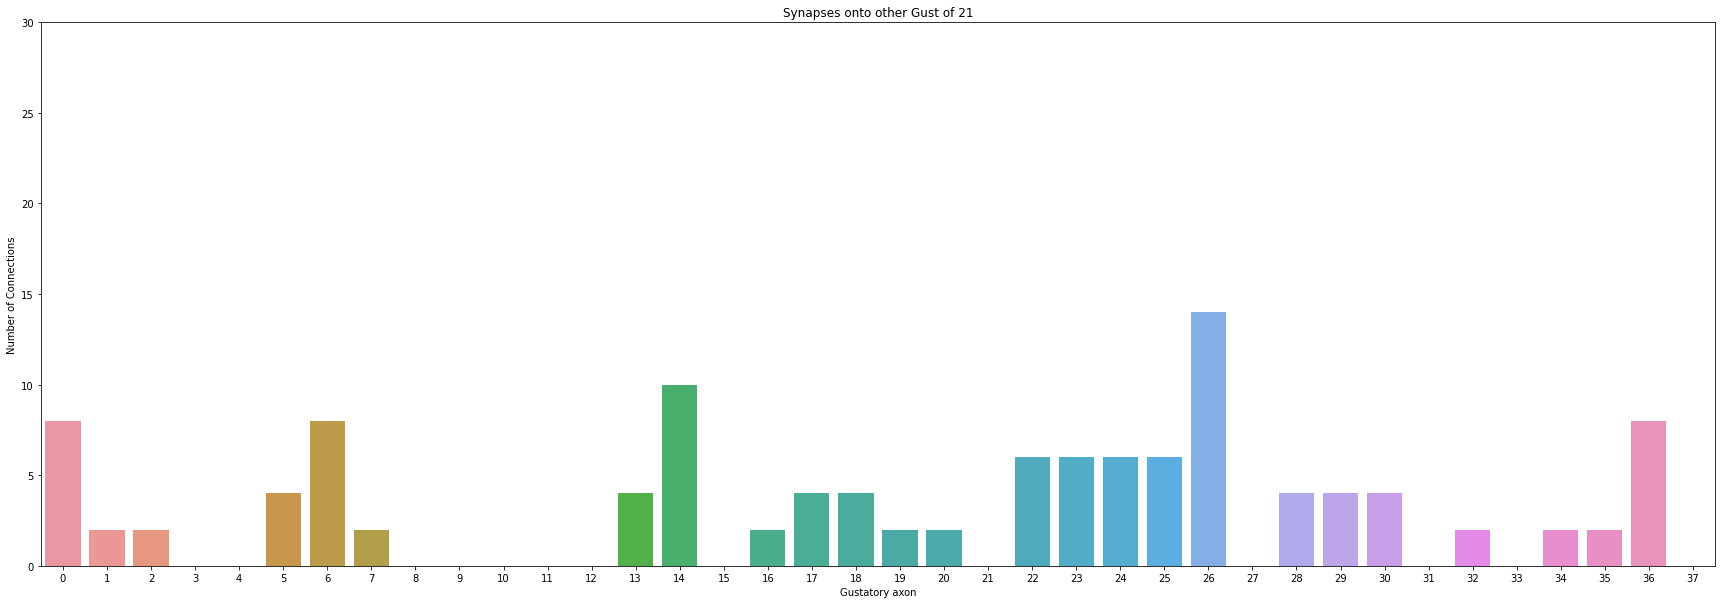

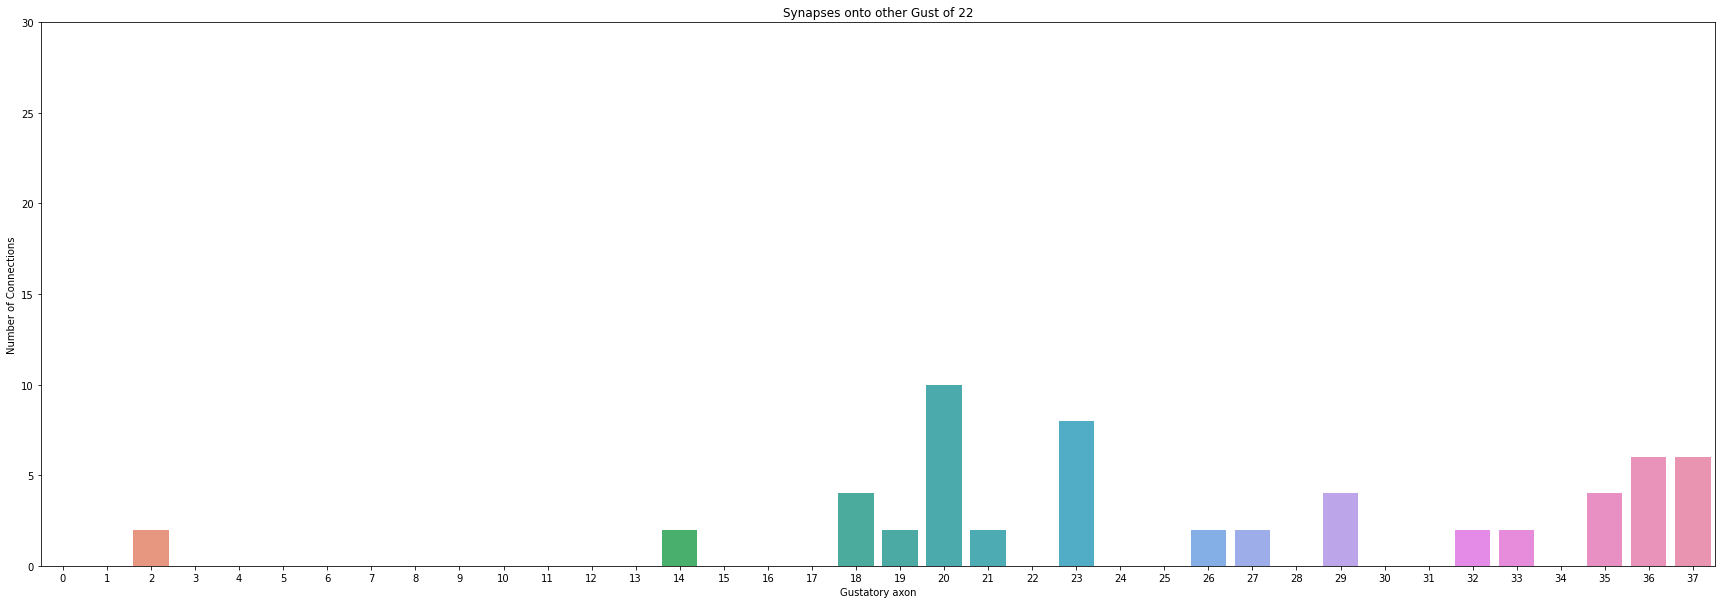

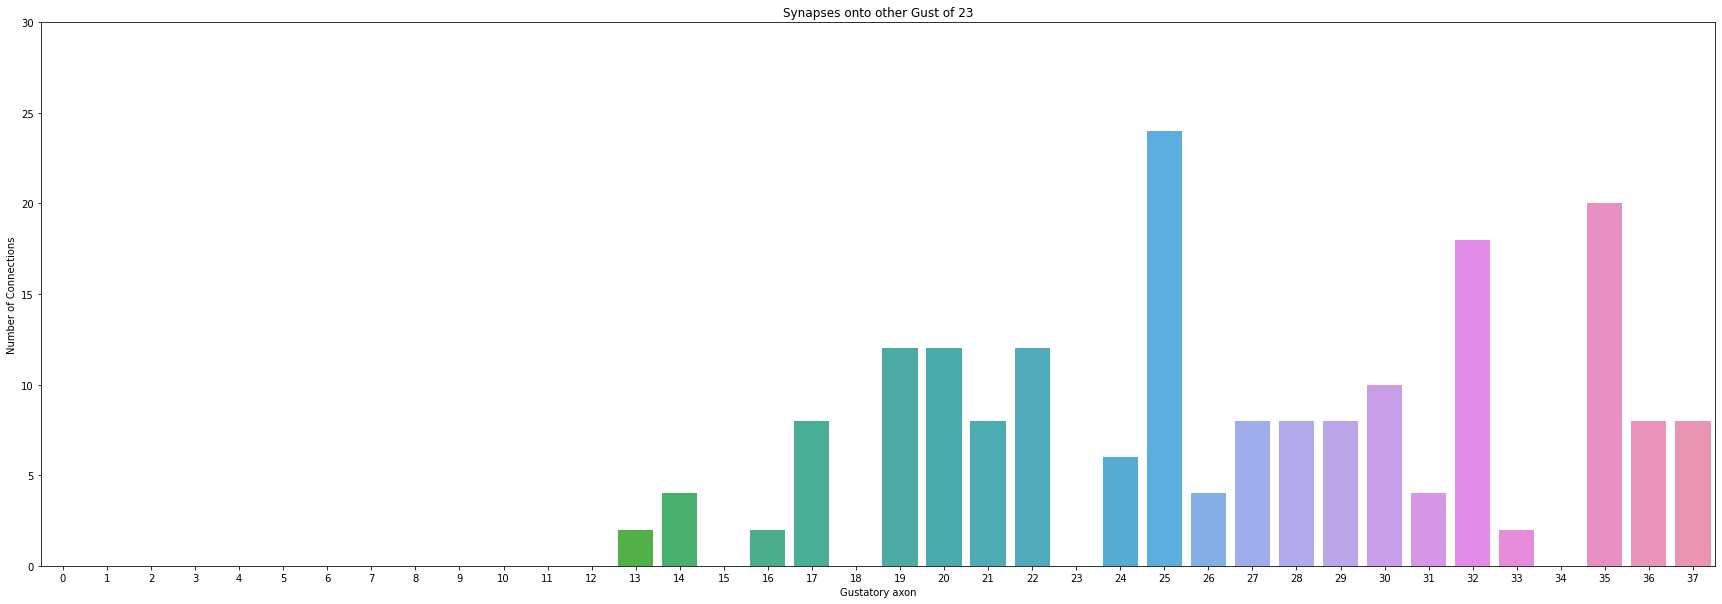

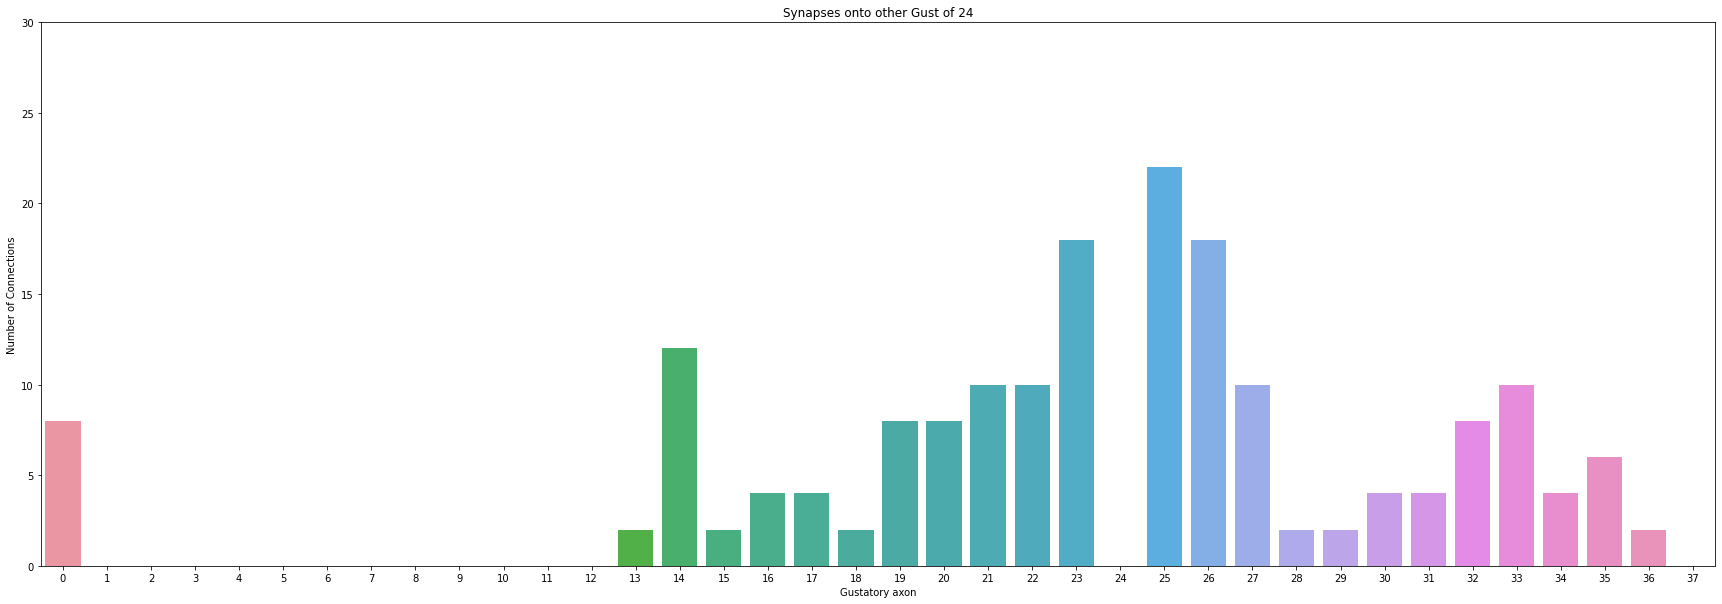

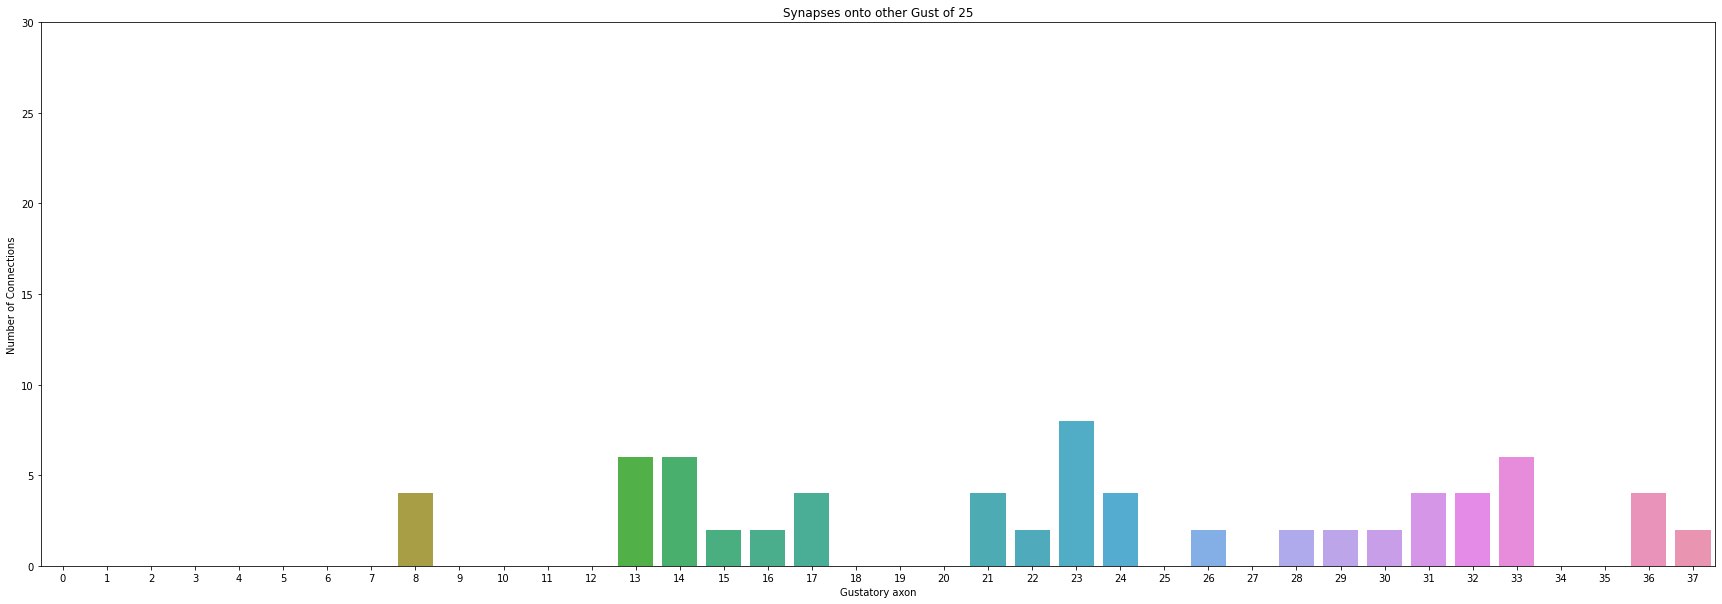

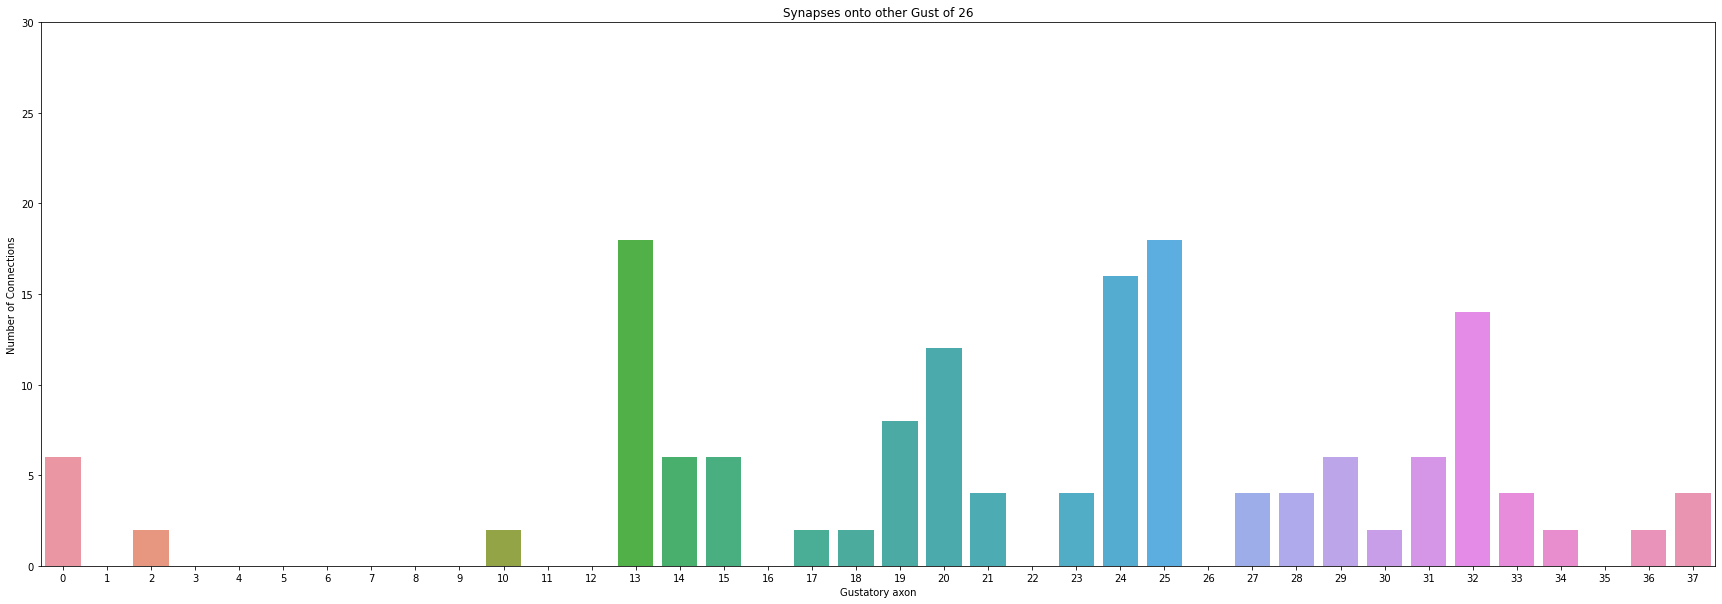

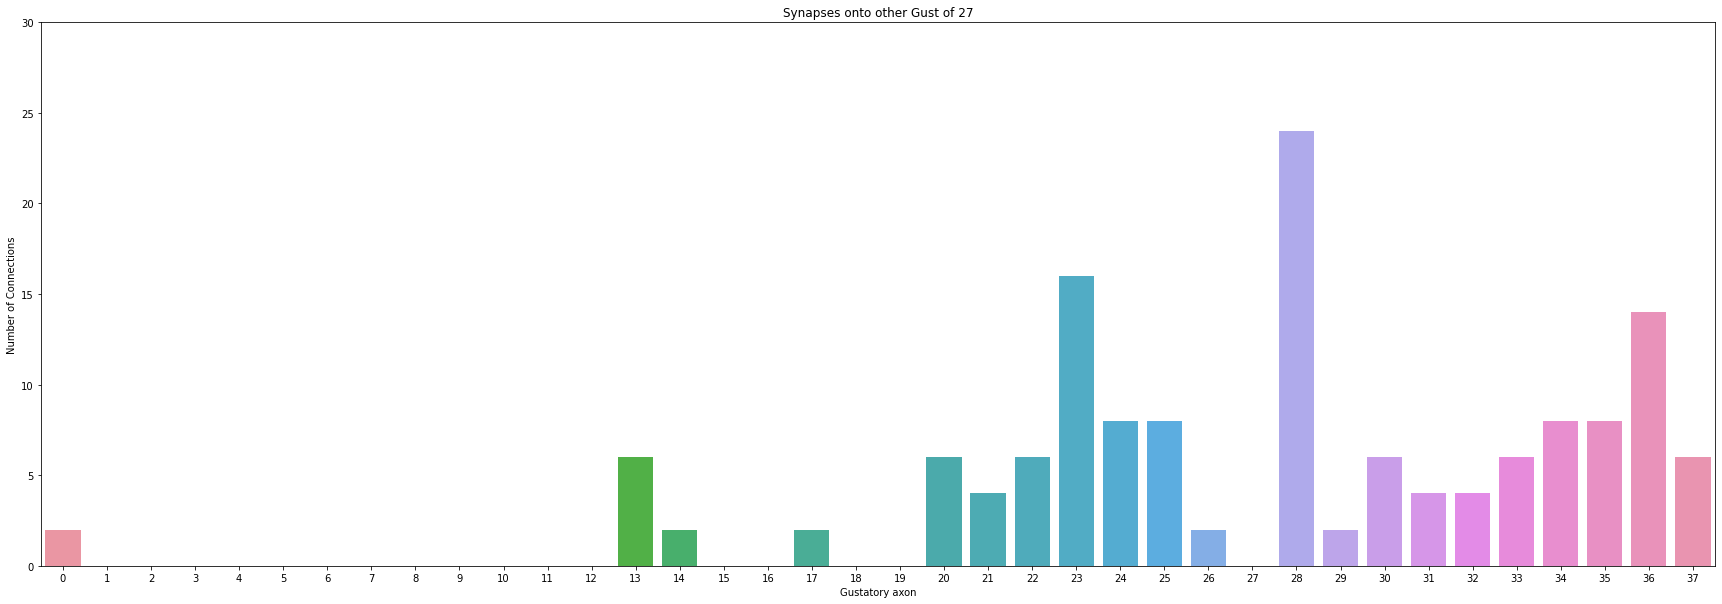

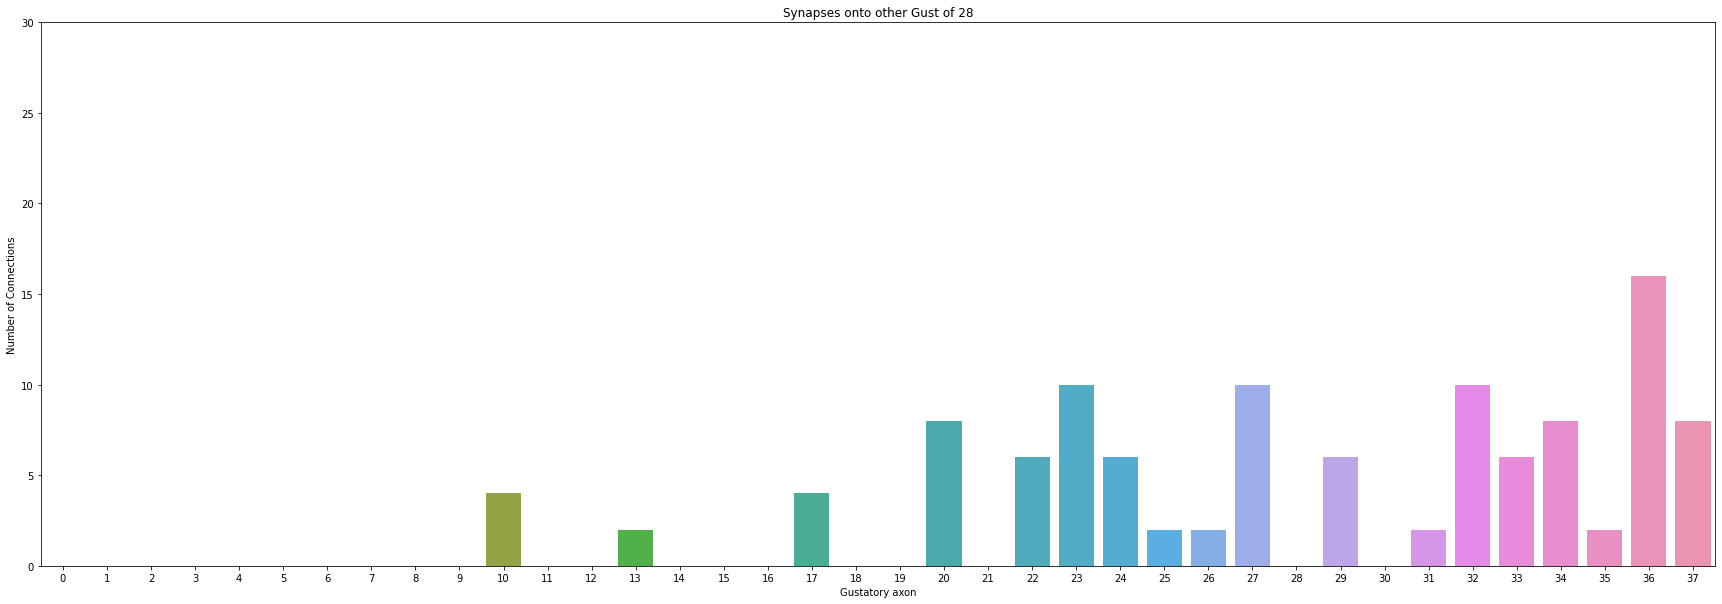

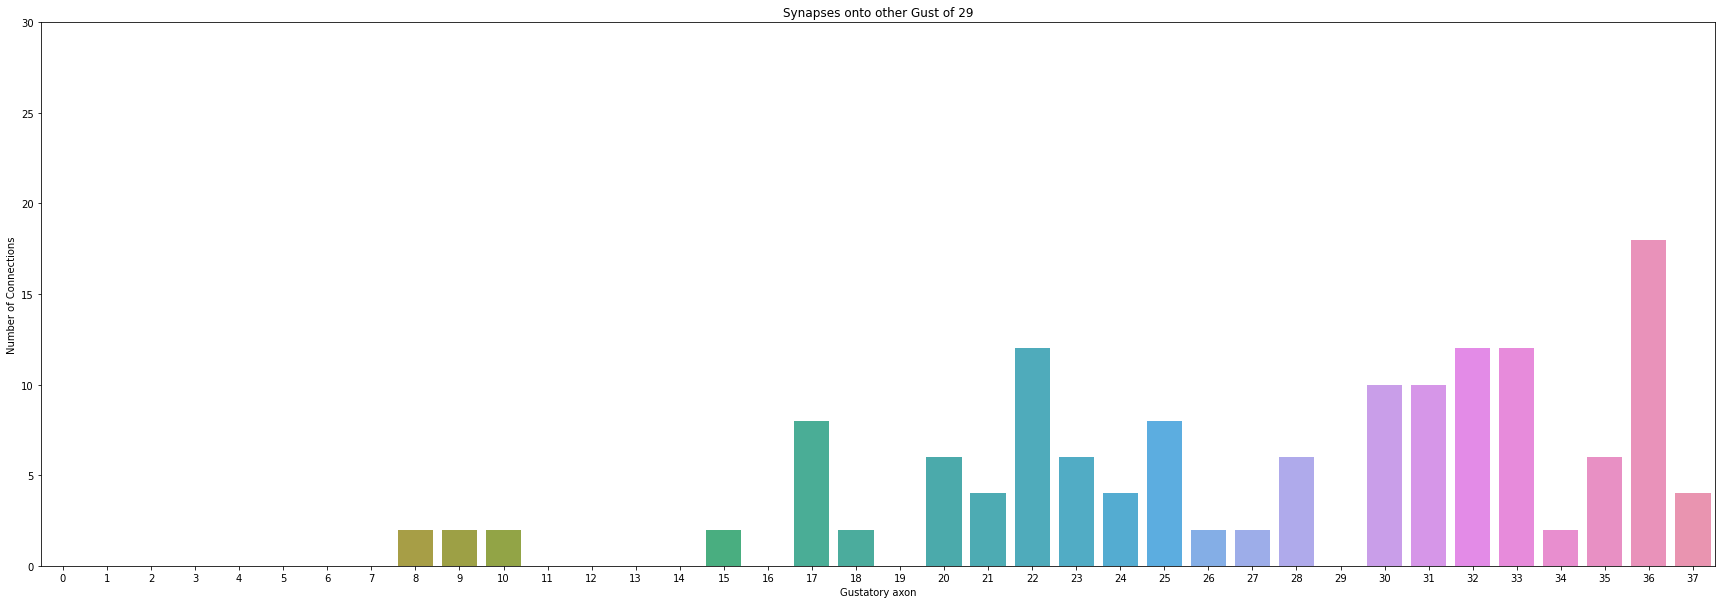

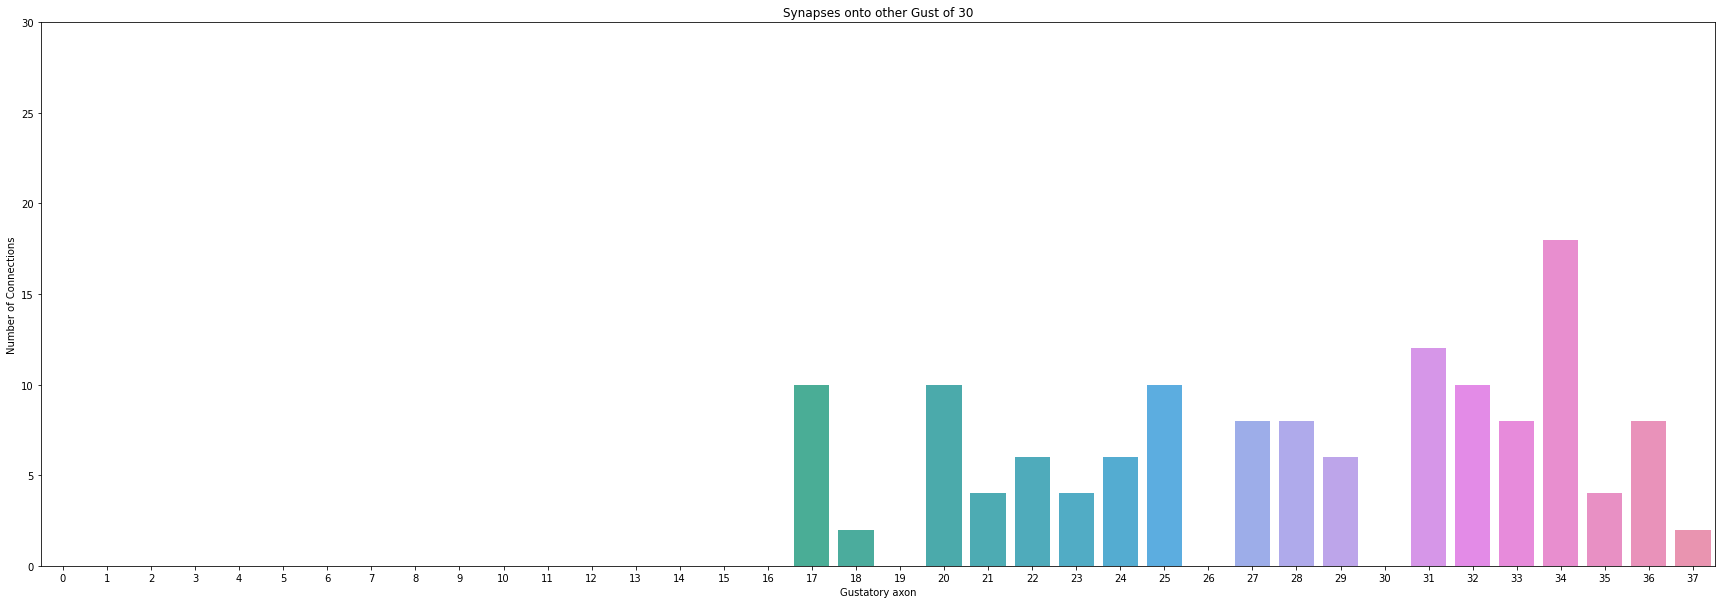

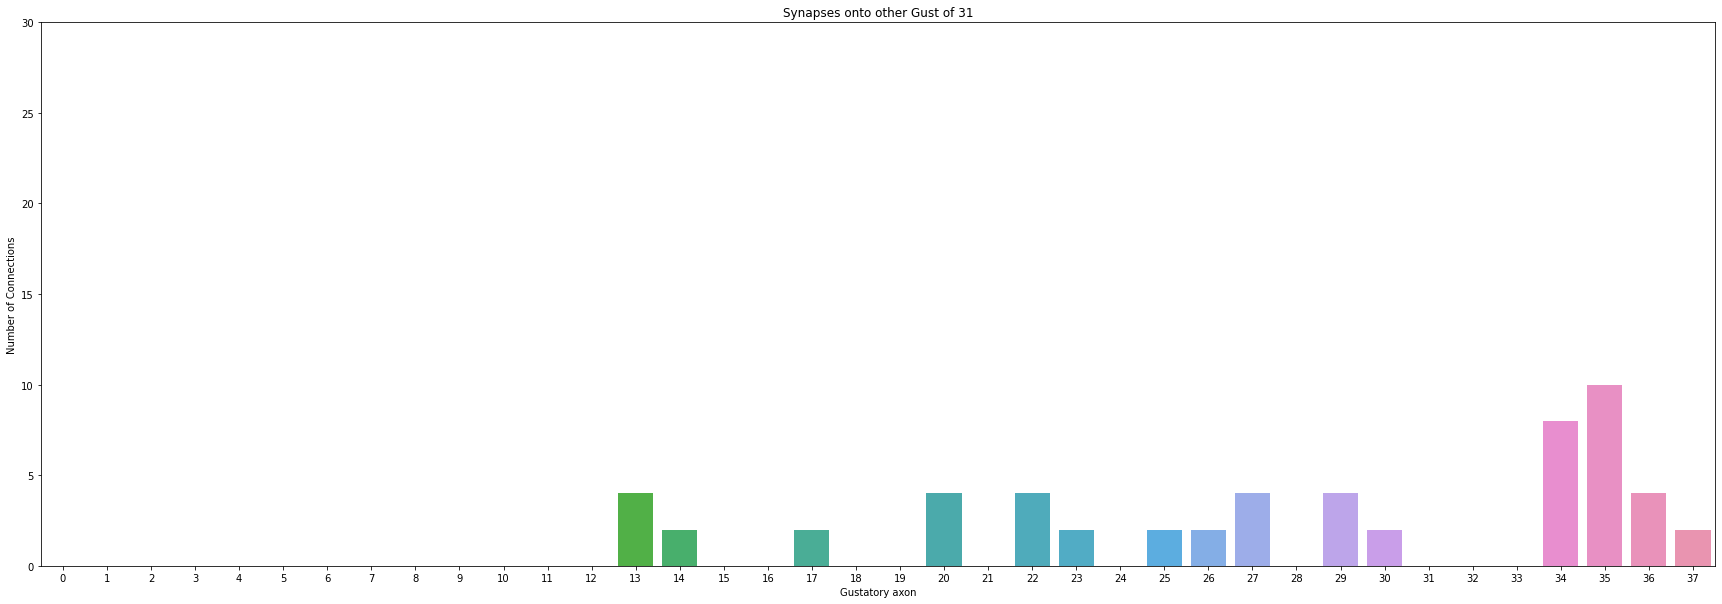

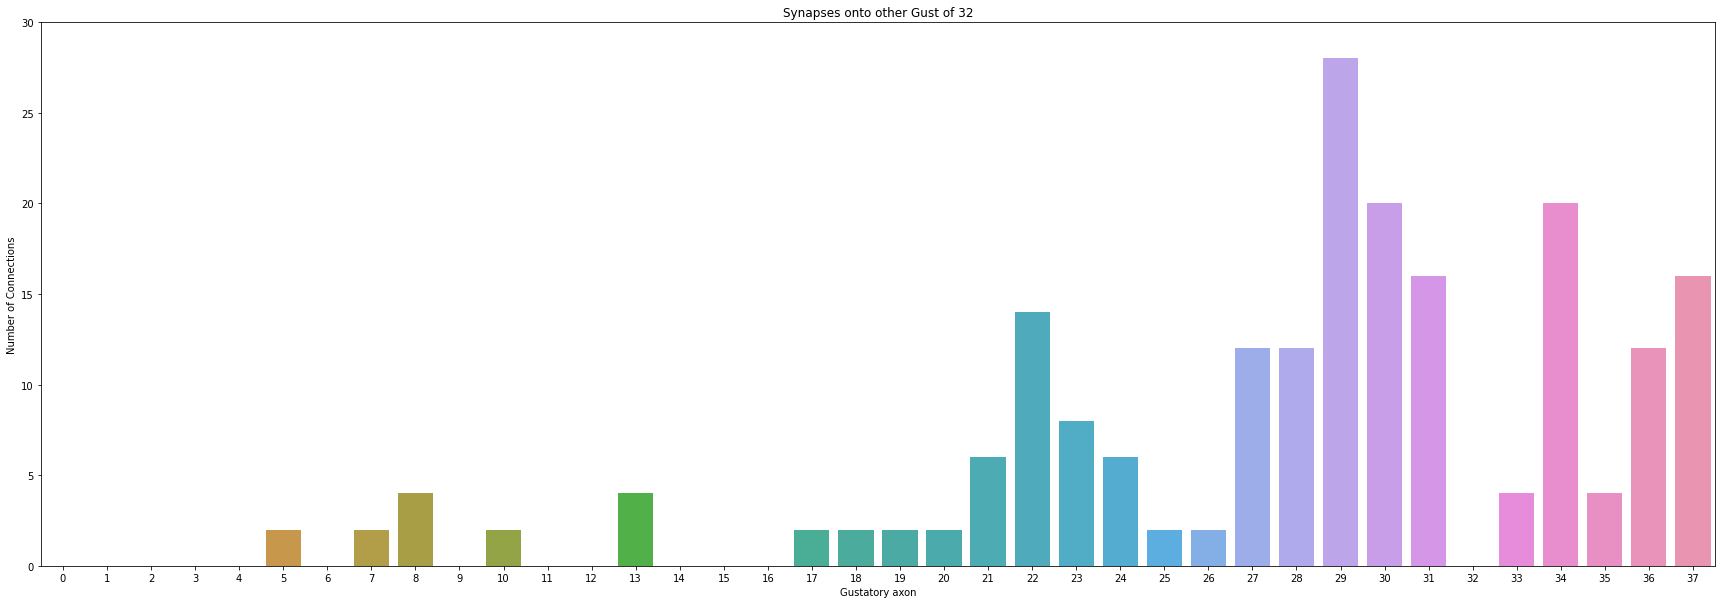

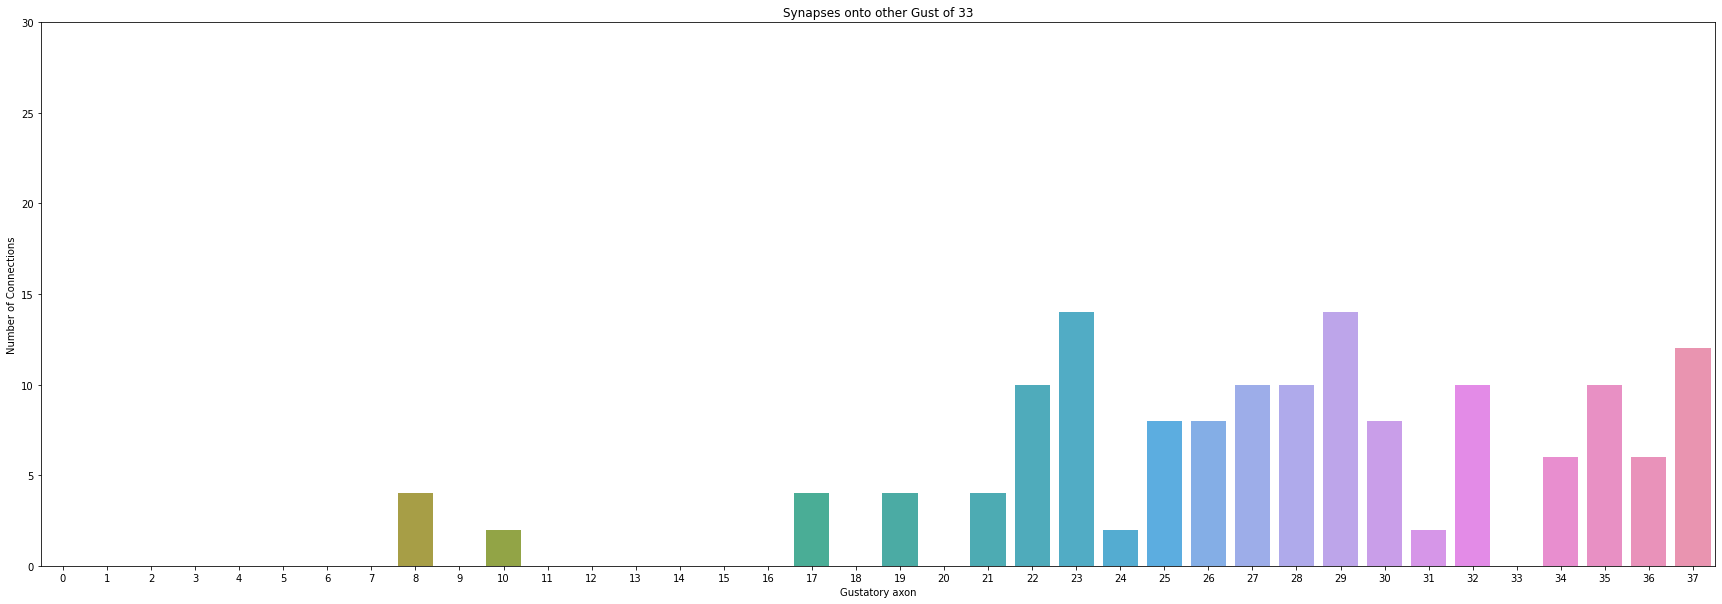

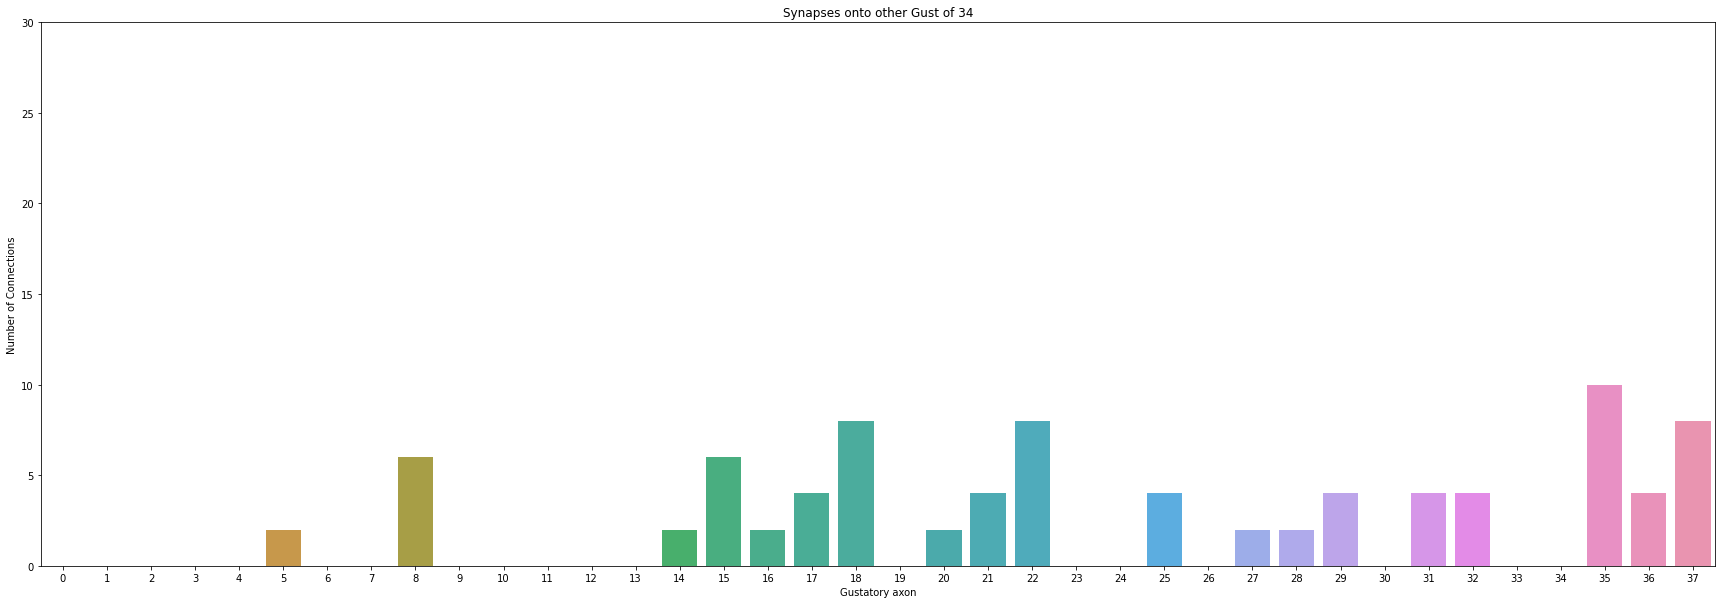

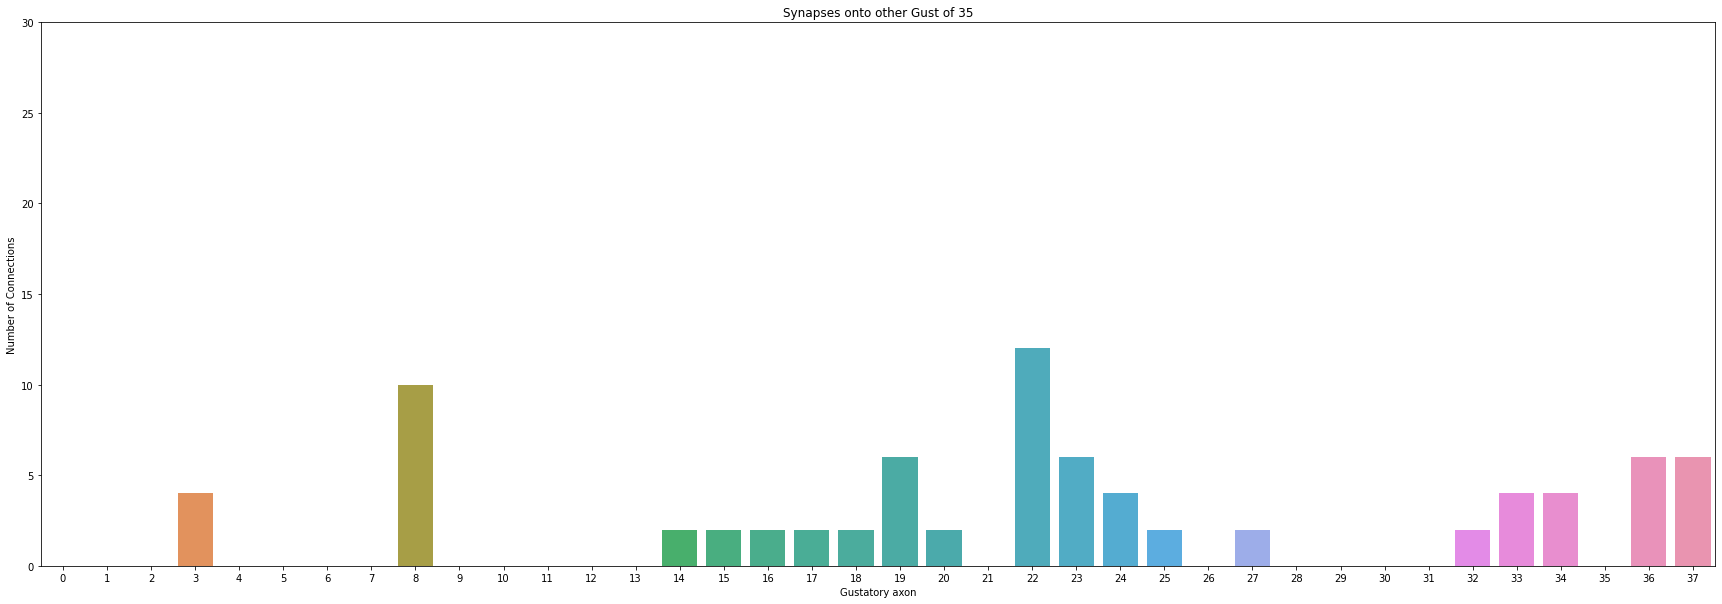

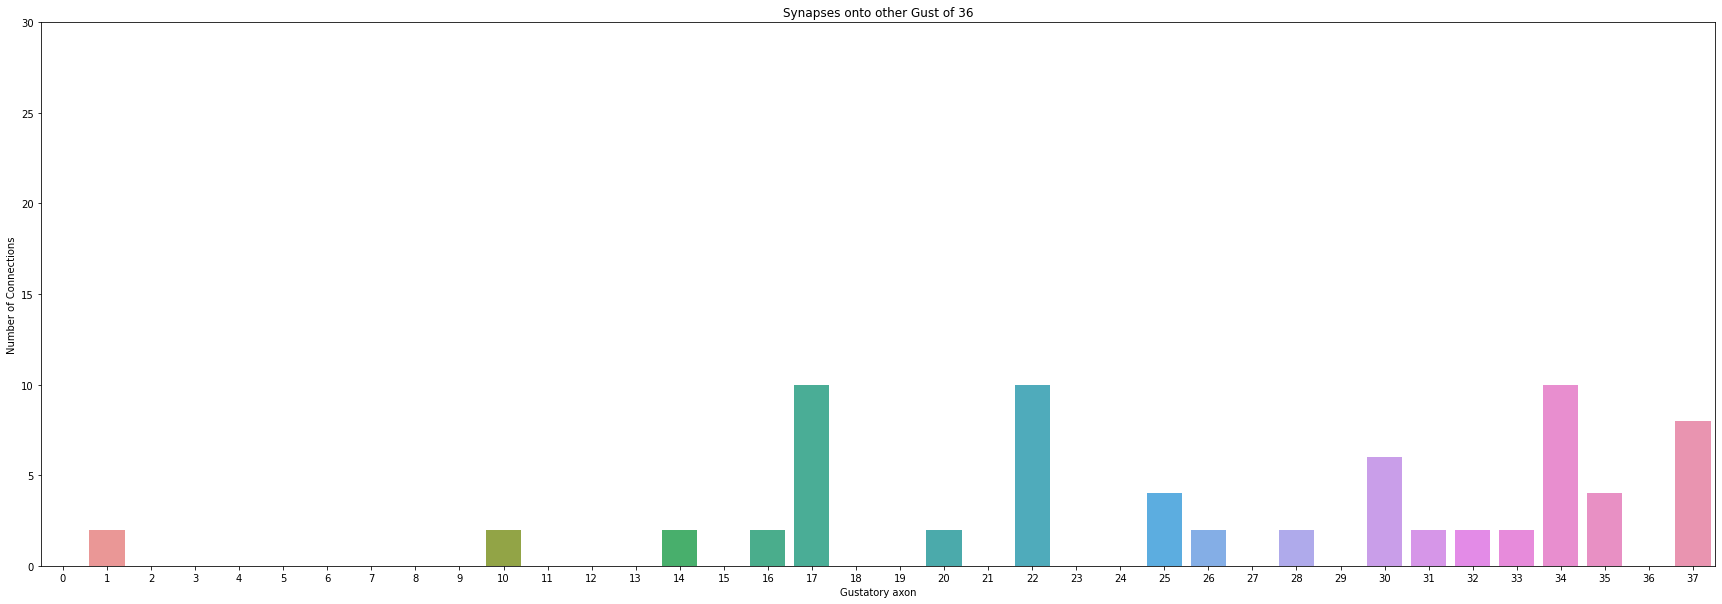

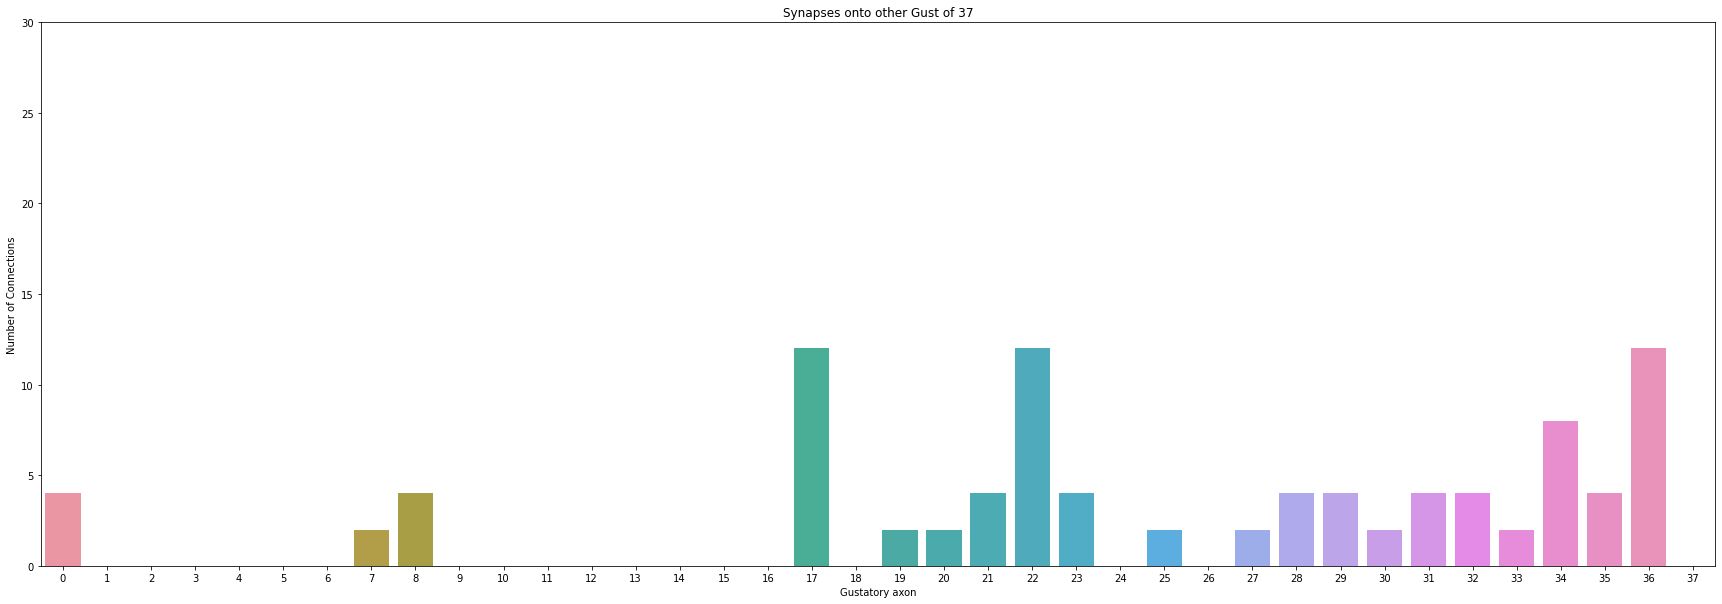

In [82]:
for i in range(0,len(ids_map_gust_gust)):
    barplot_a_gust(i, edge_with_zeros, normalized = True)

C:\Users\trnan\anaconda3\envs\micronsbinder\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


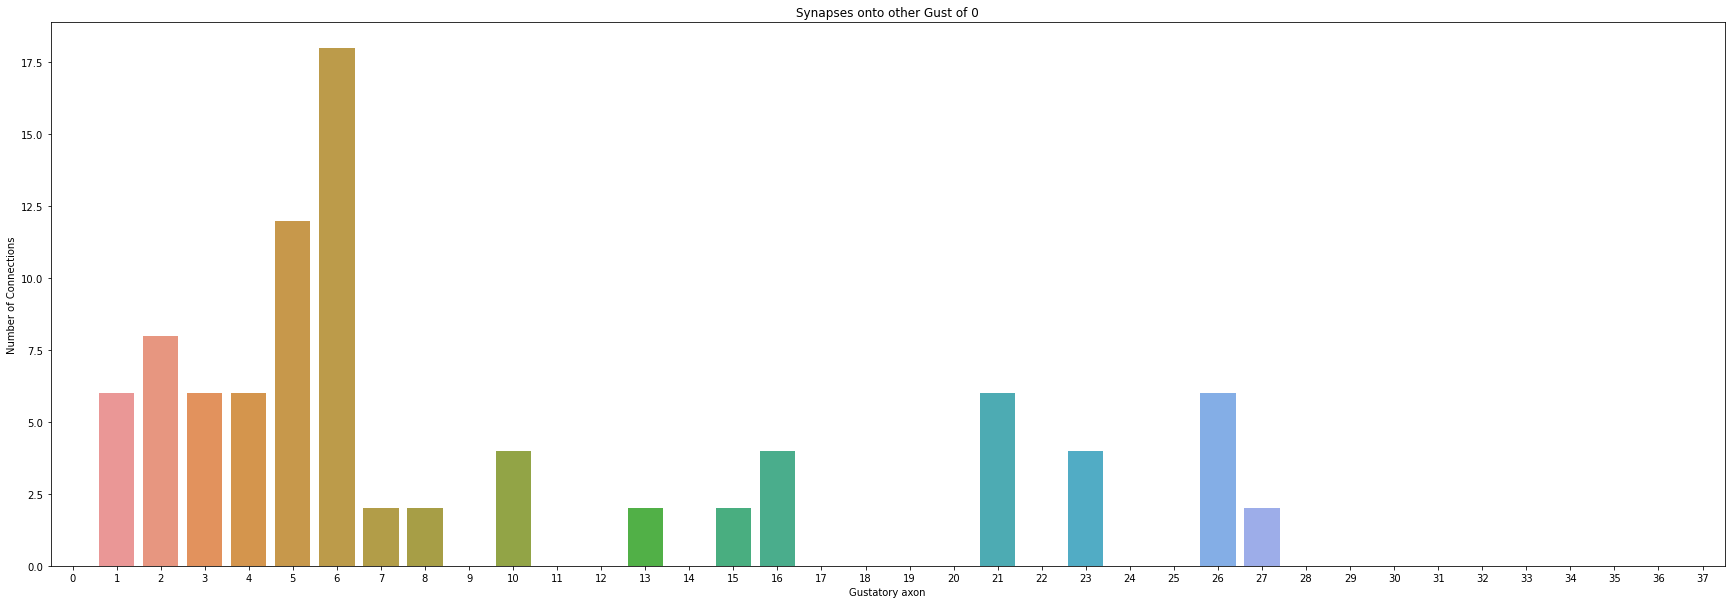

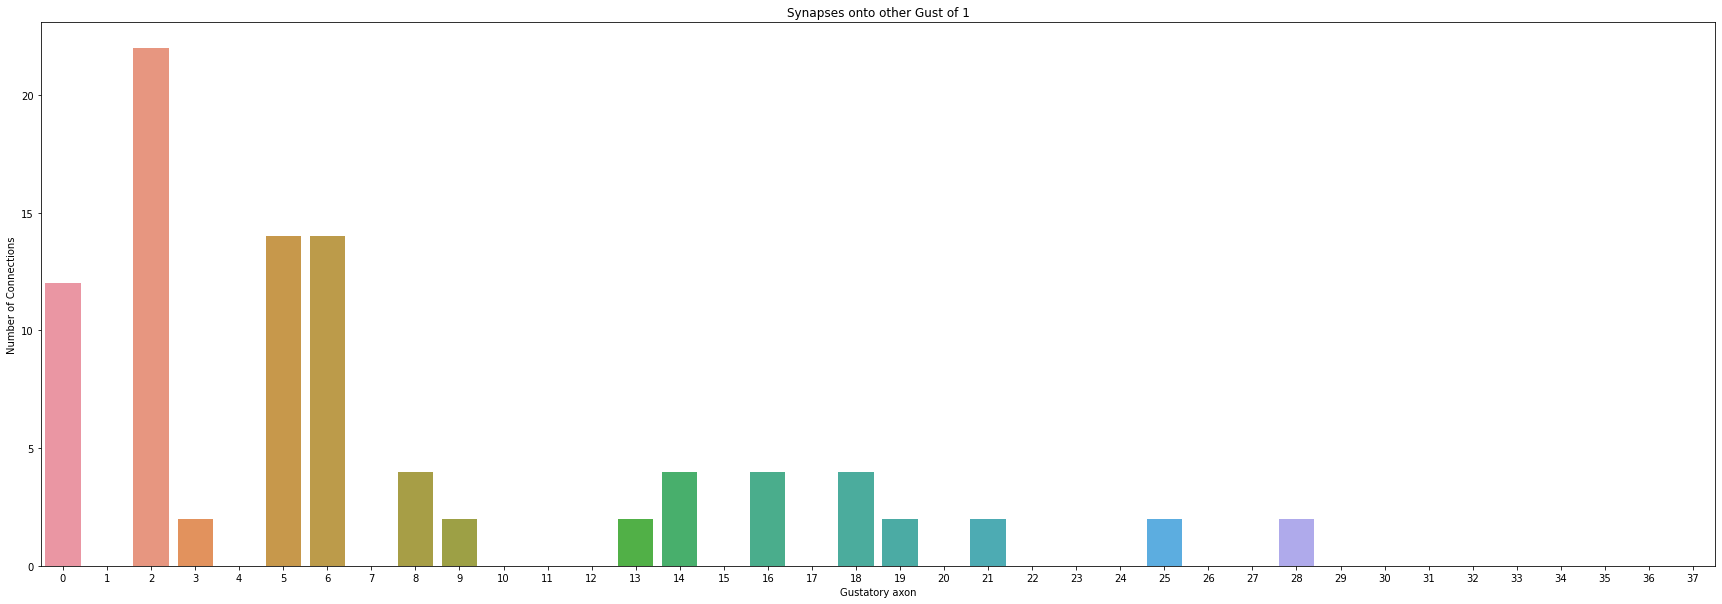

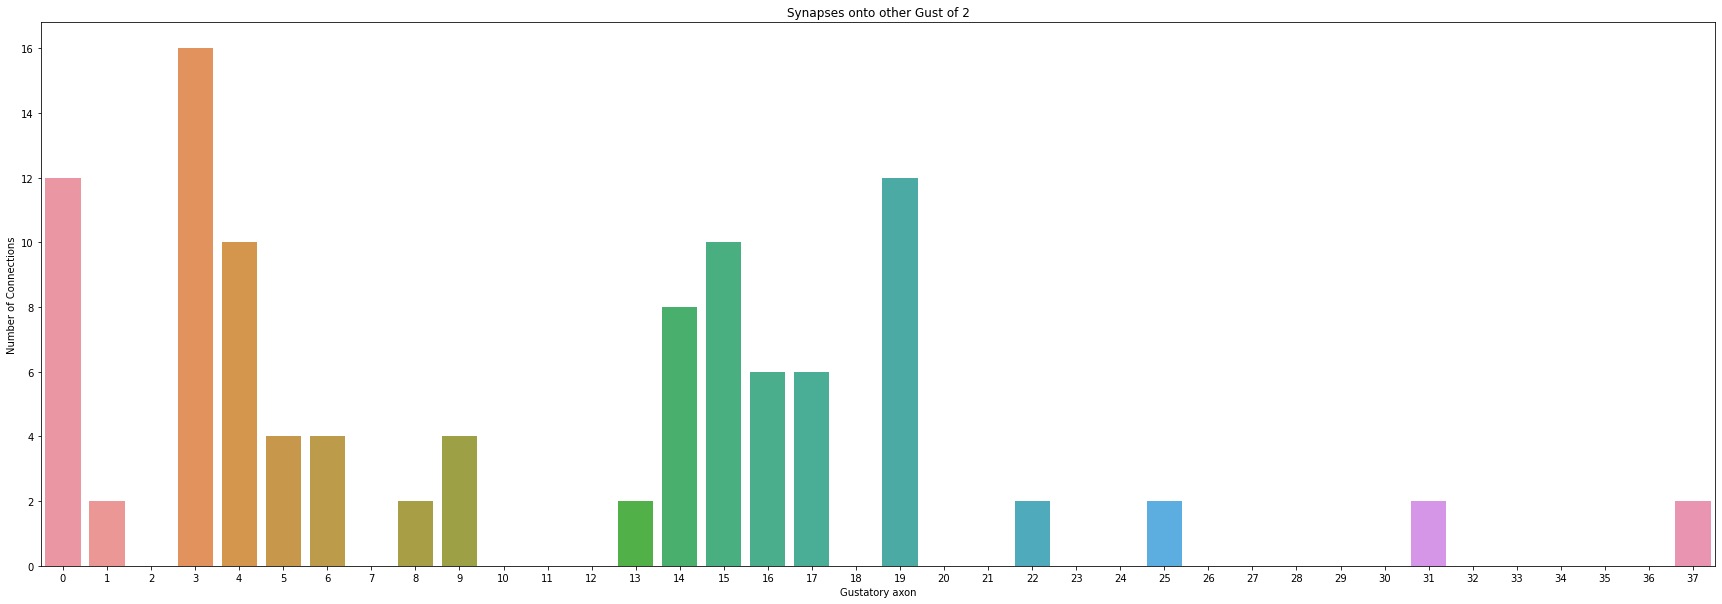

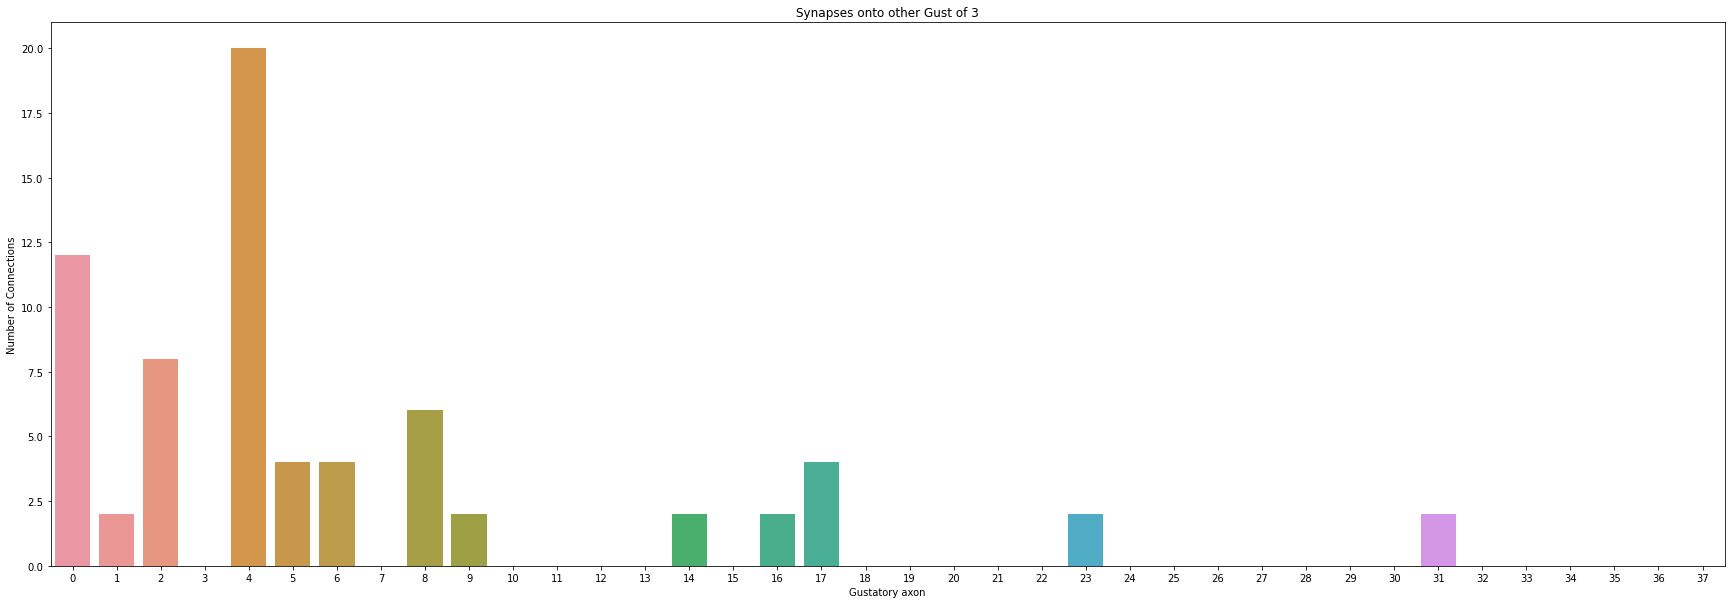

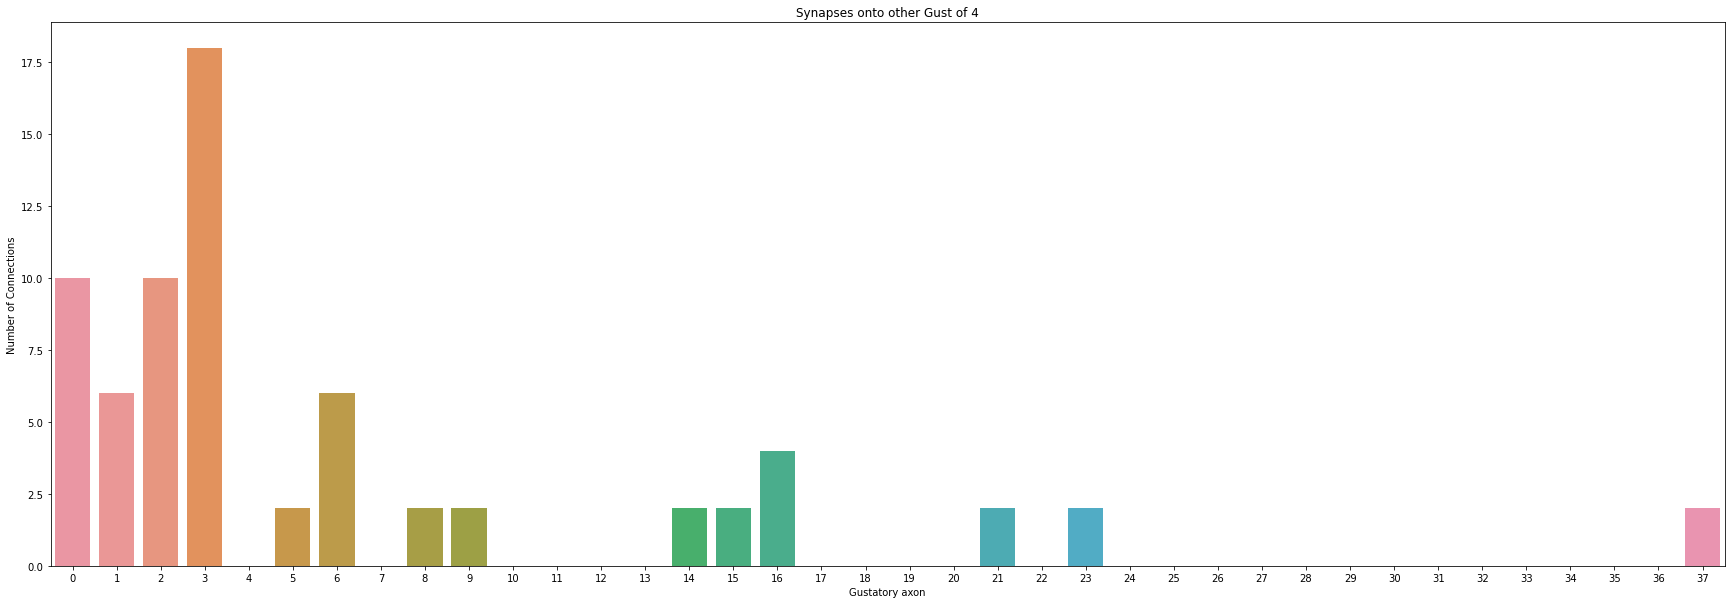

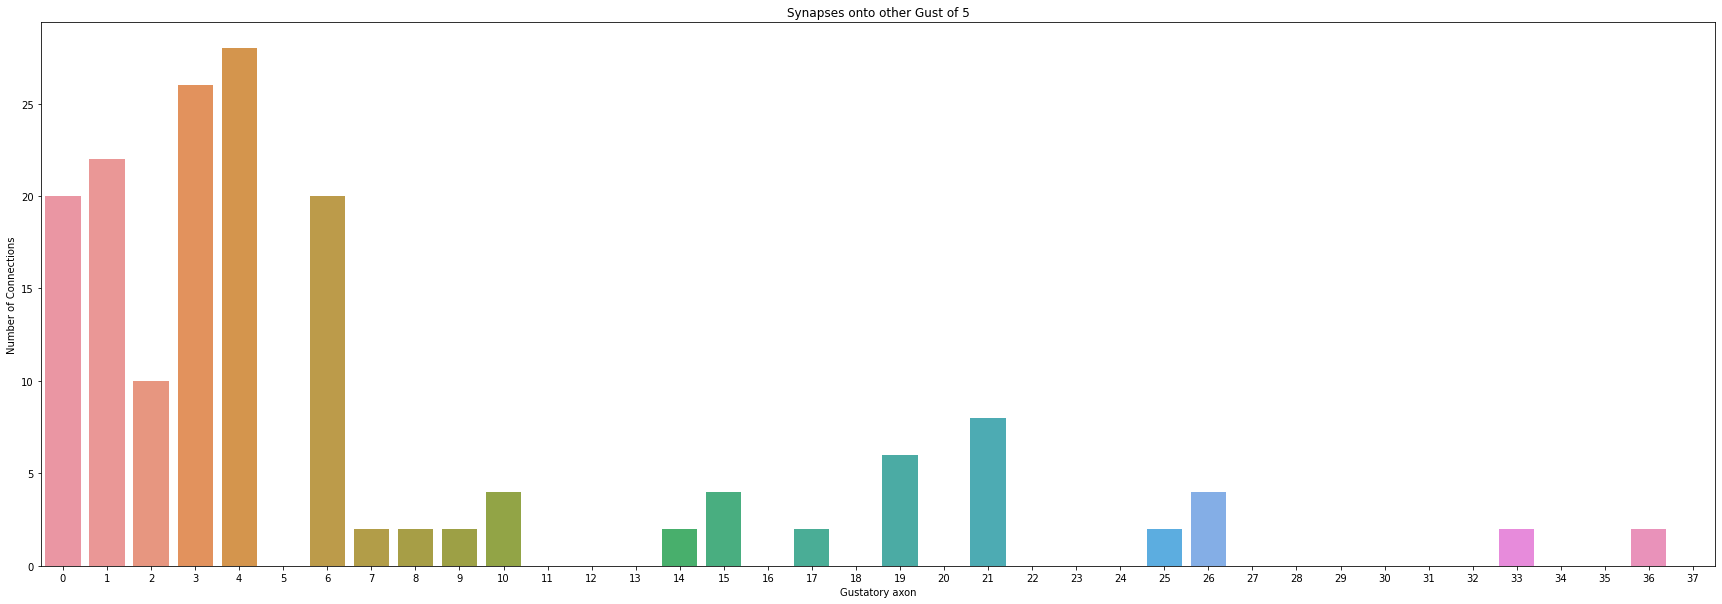

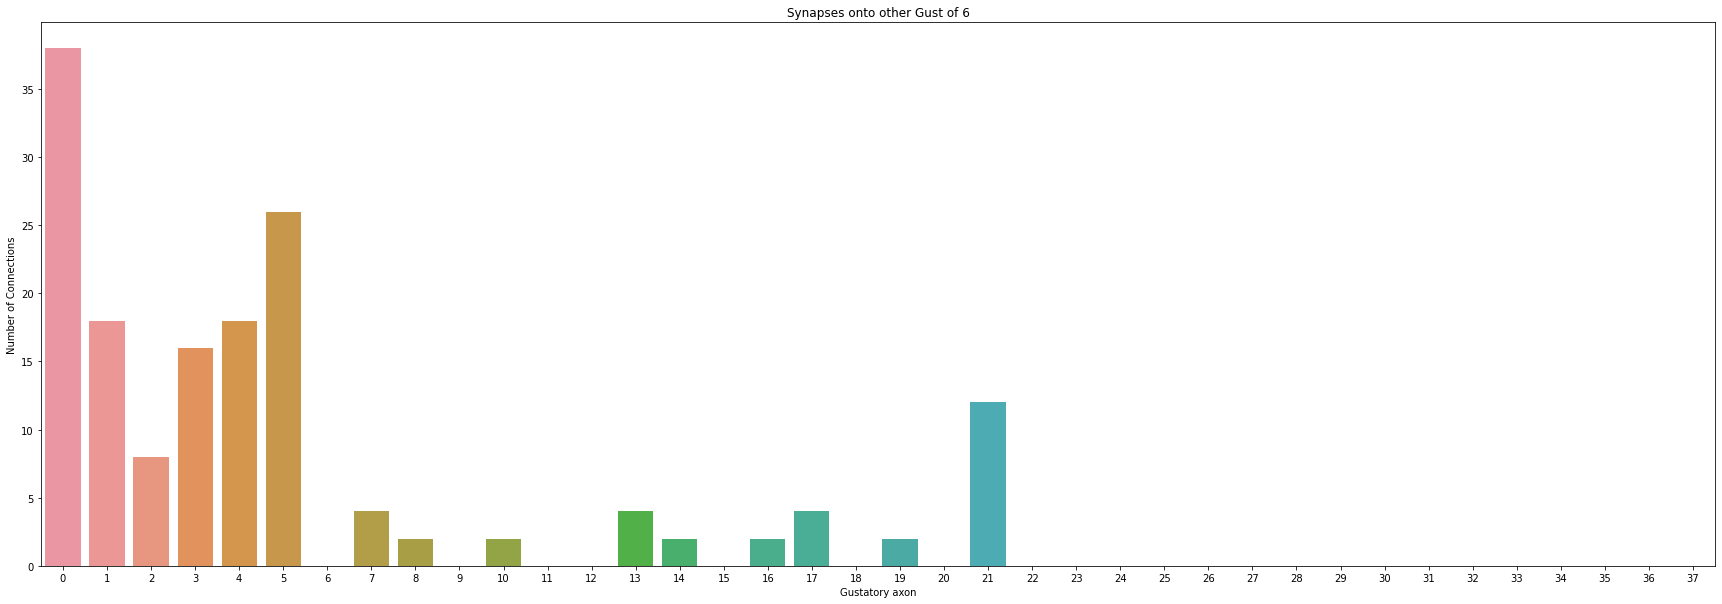

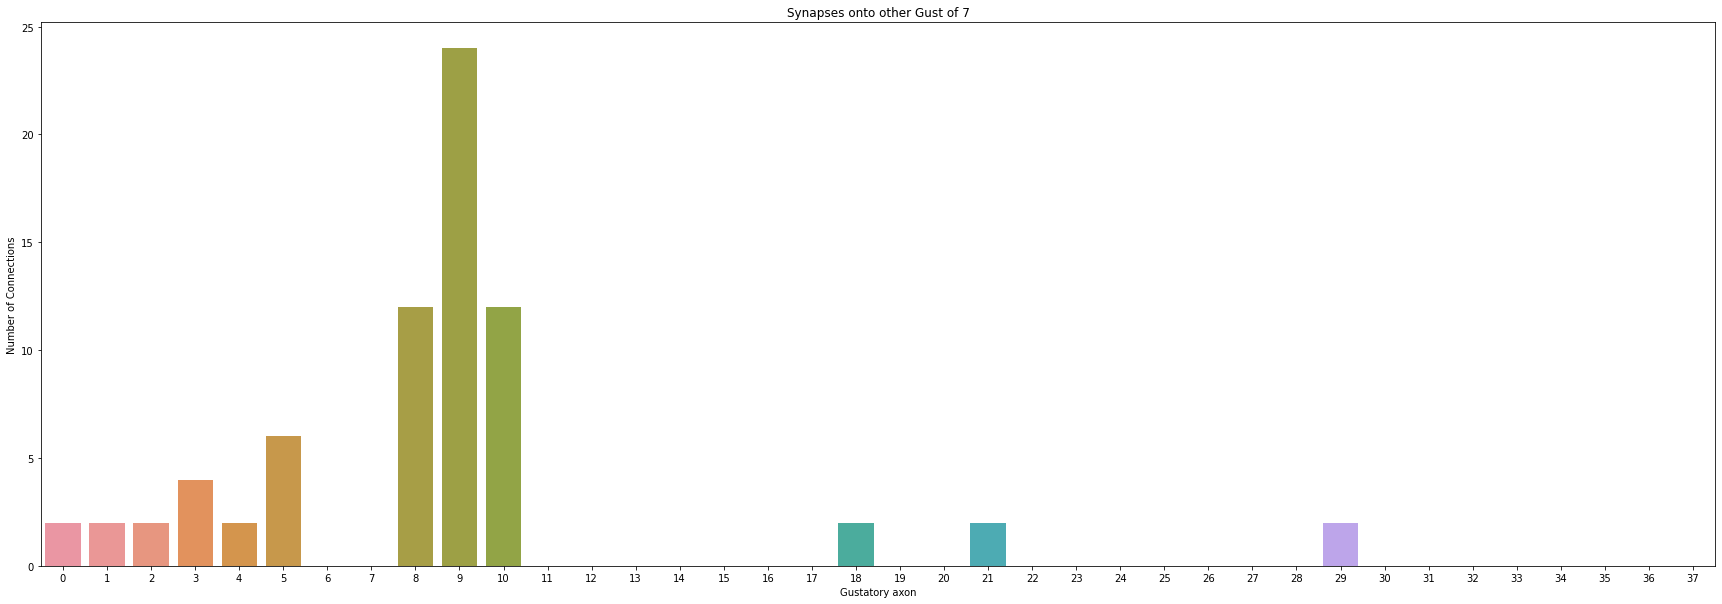

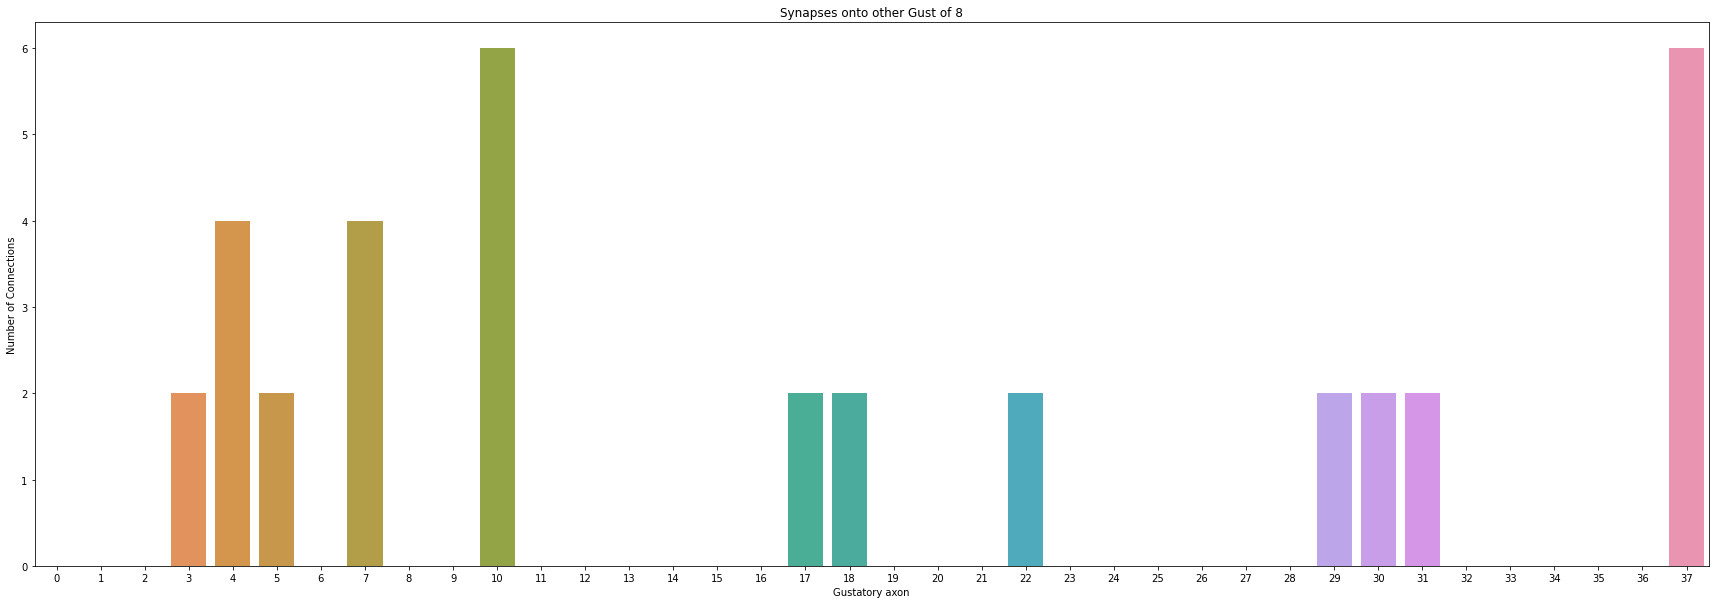

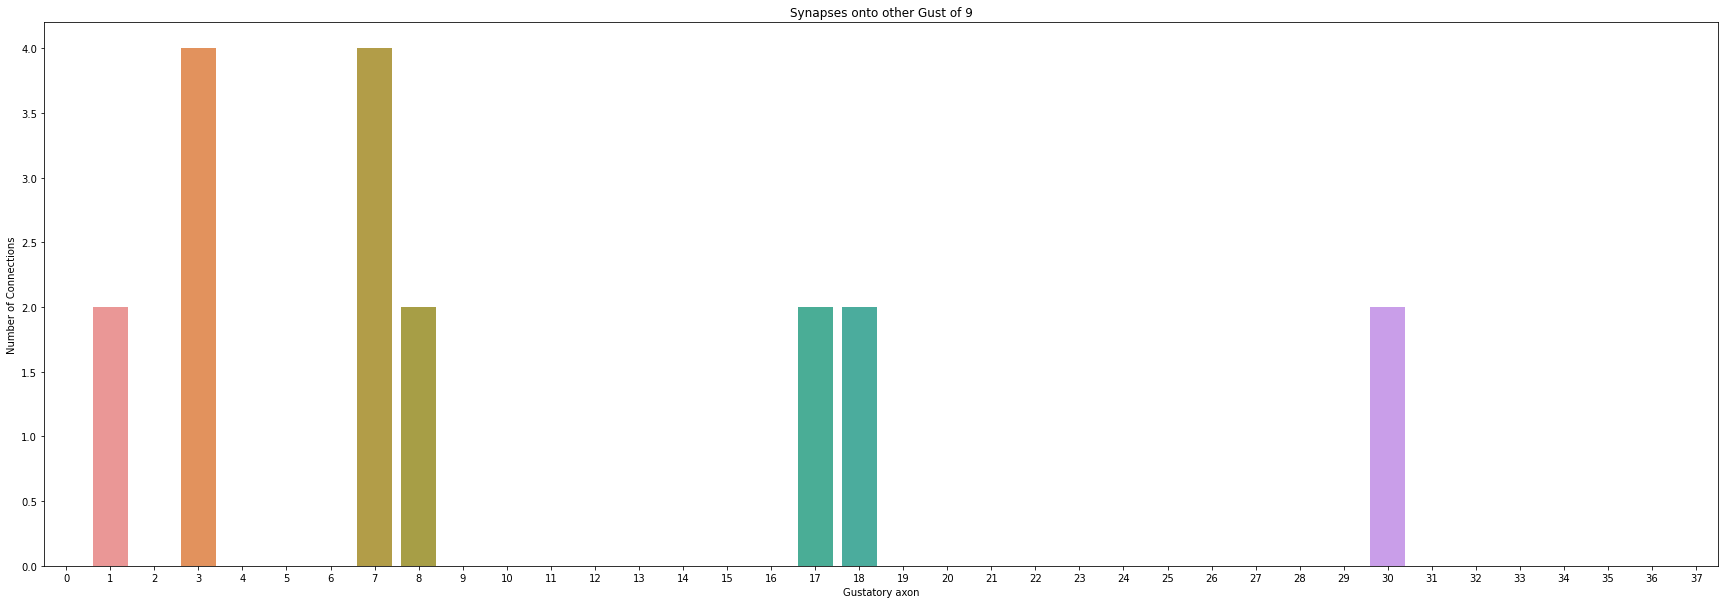

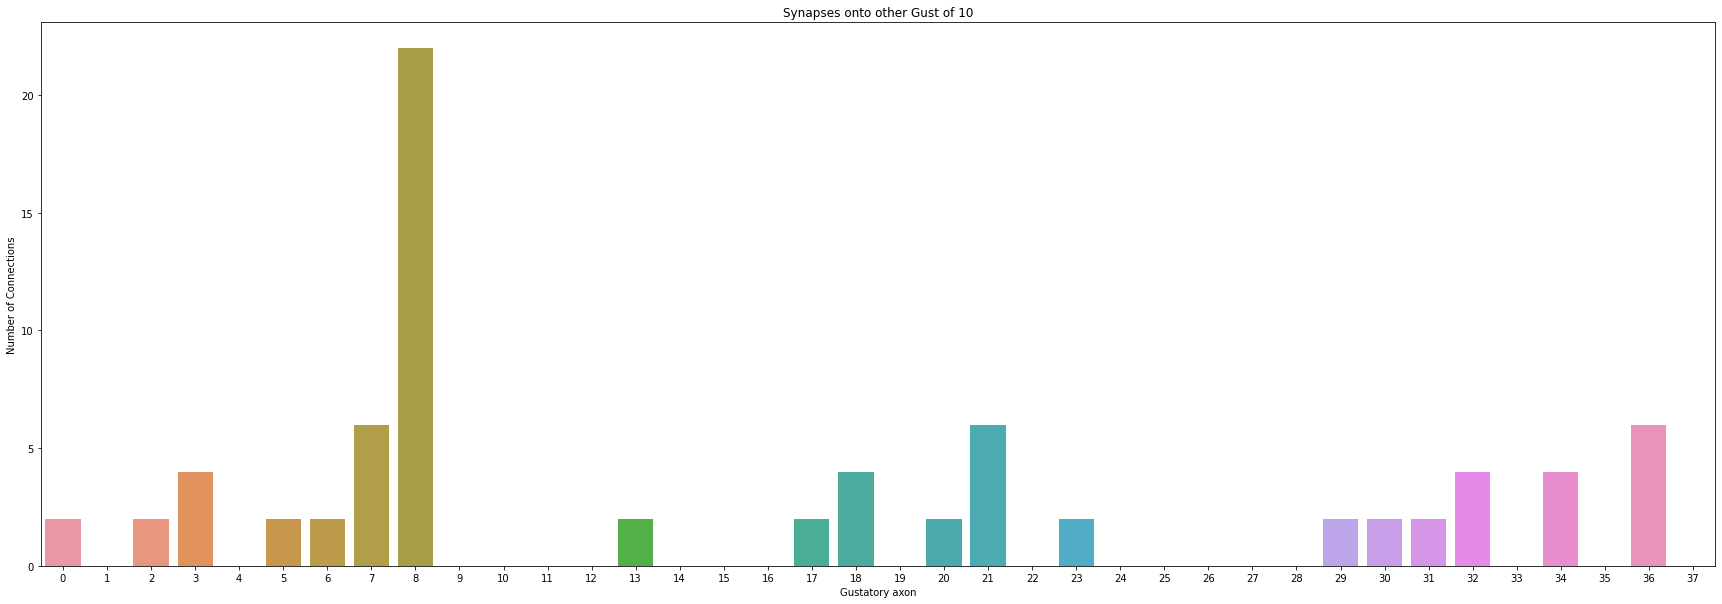

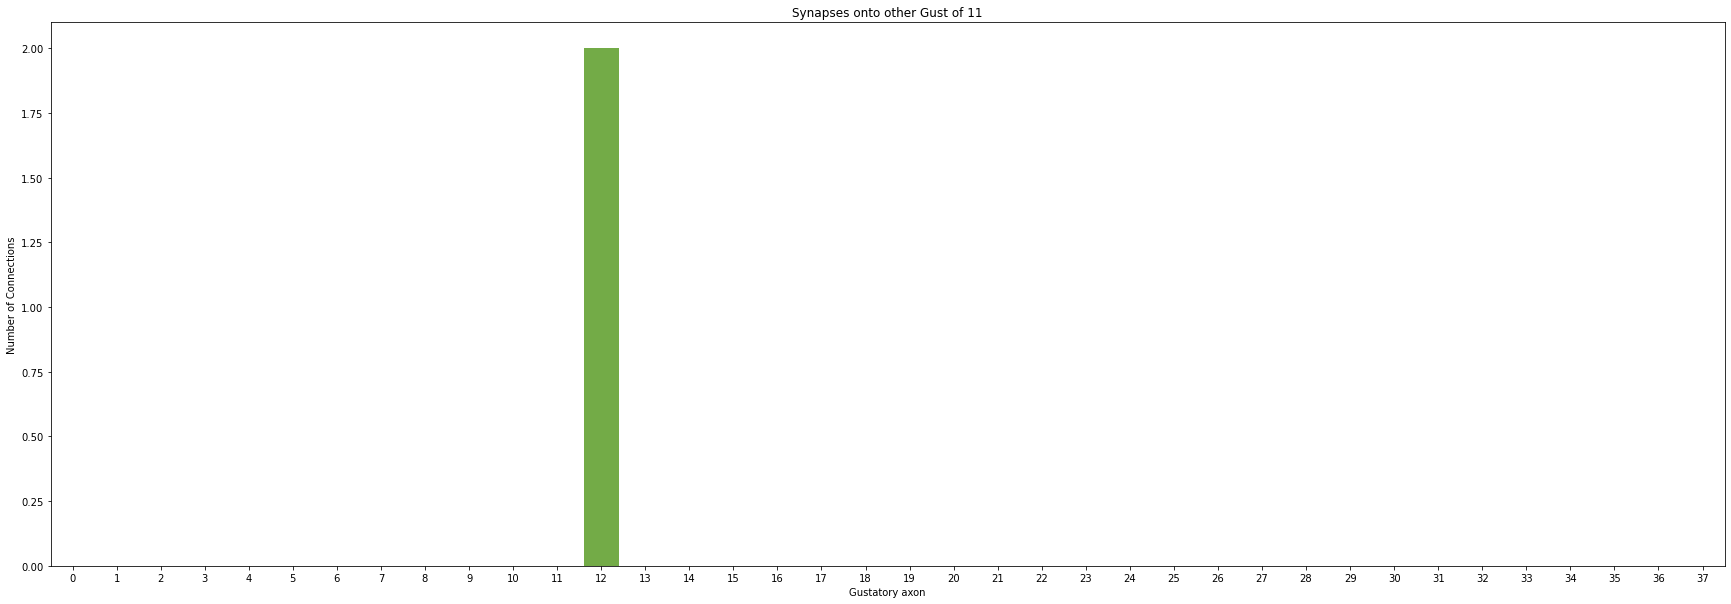

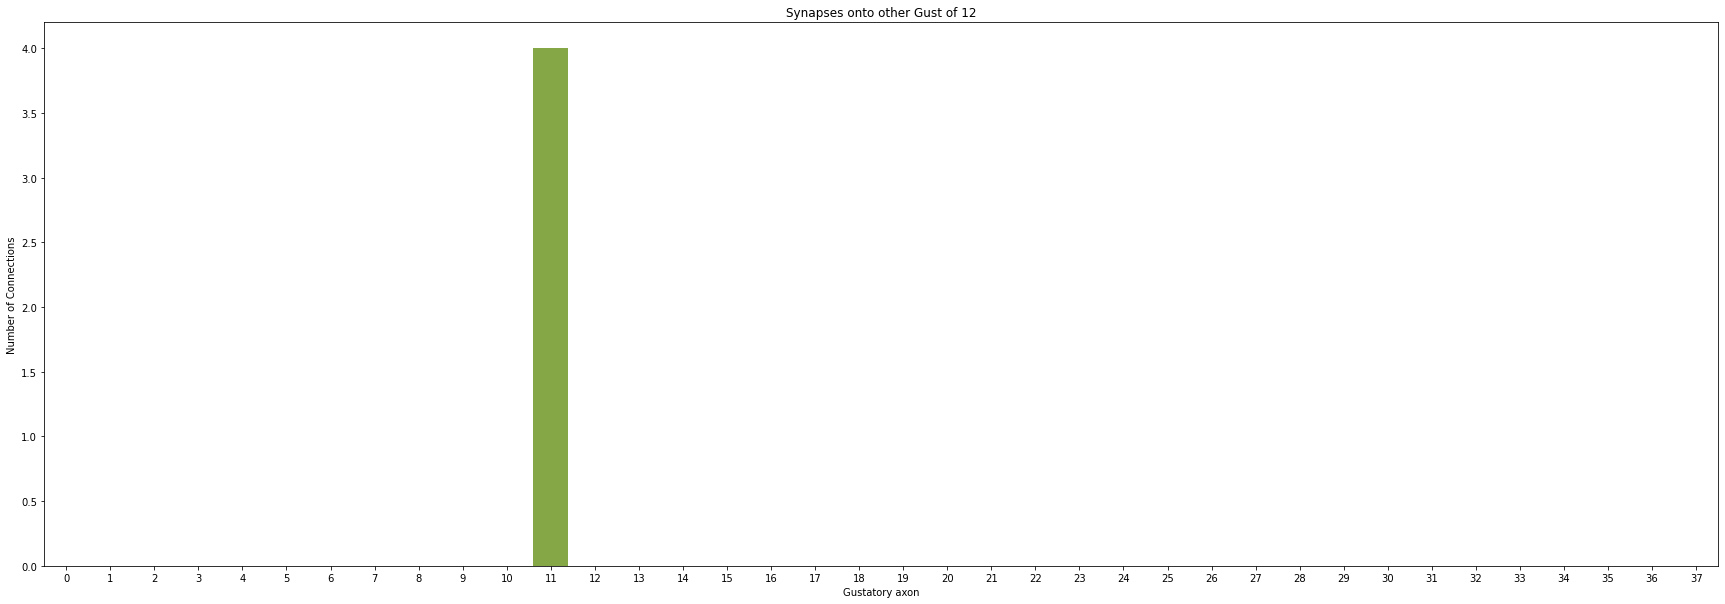

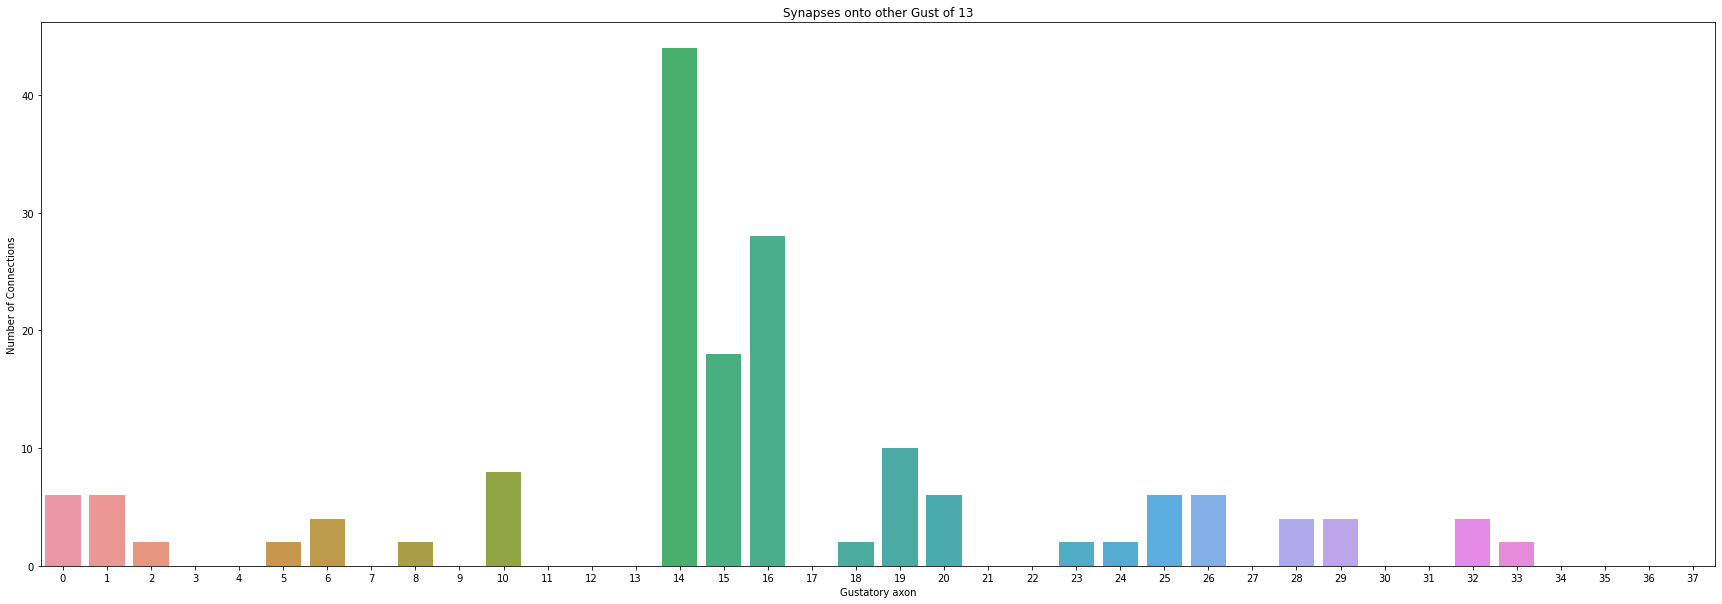

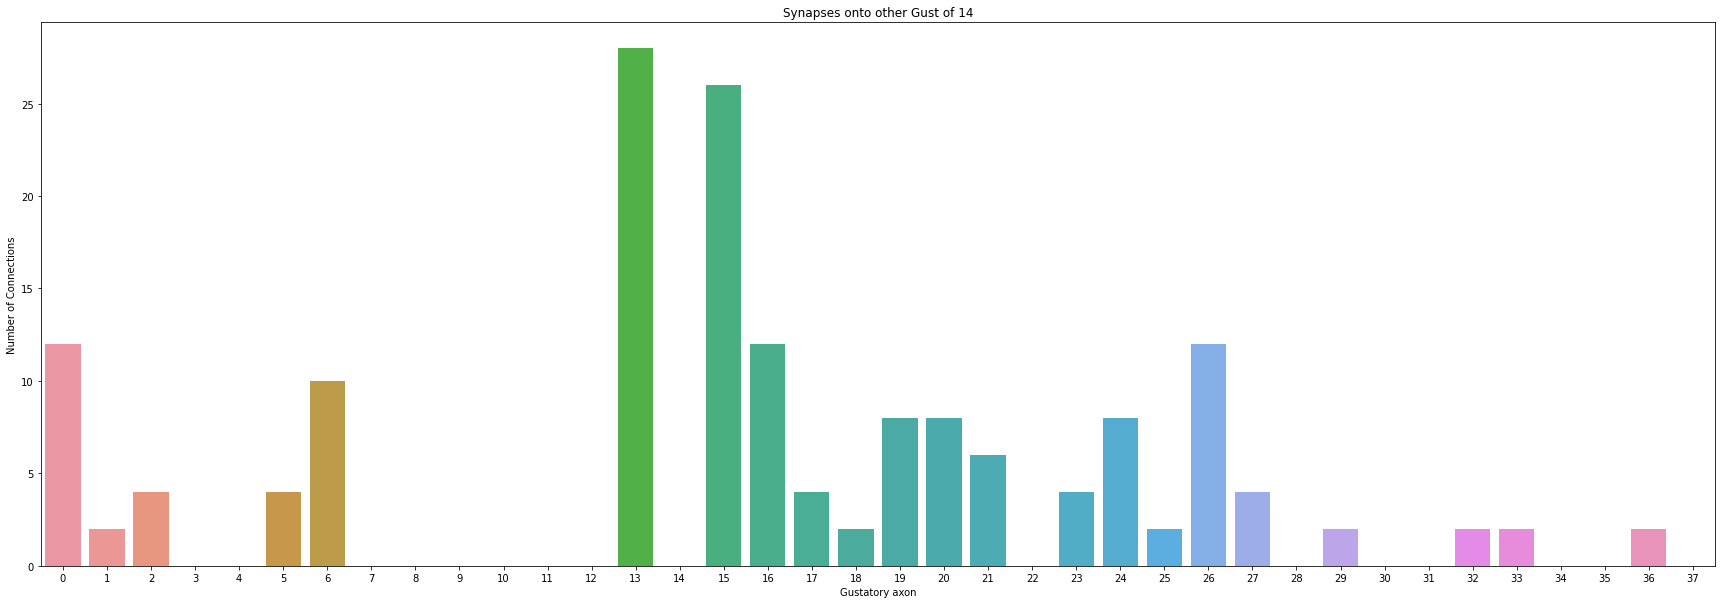

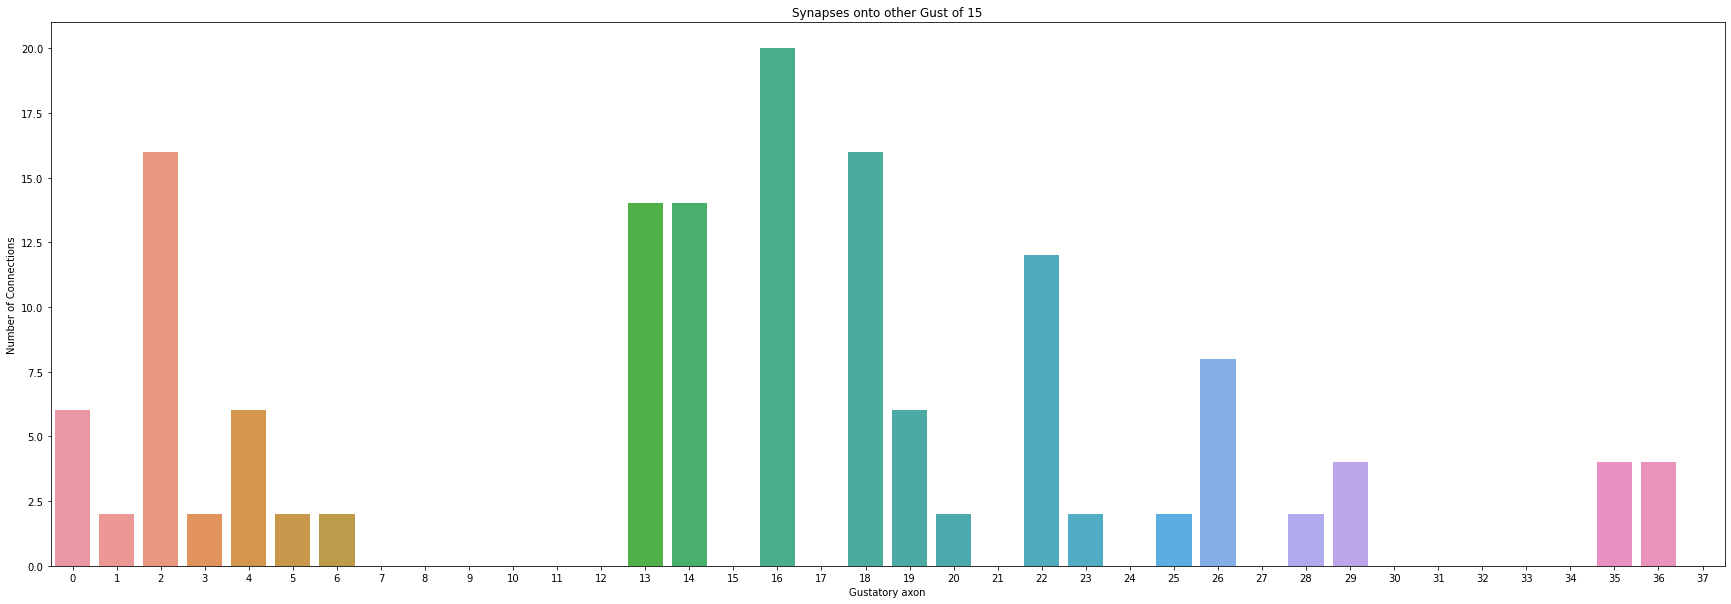

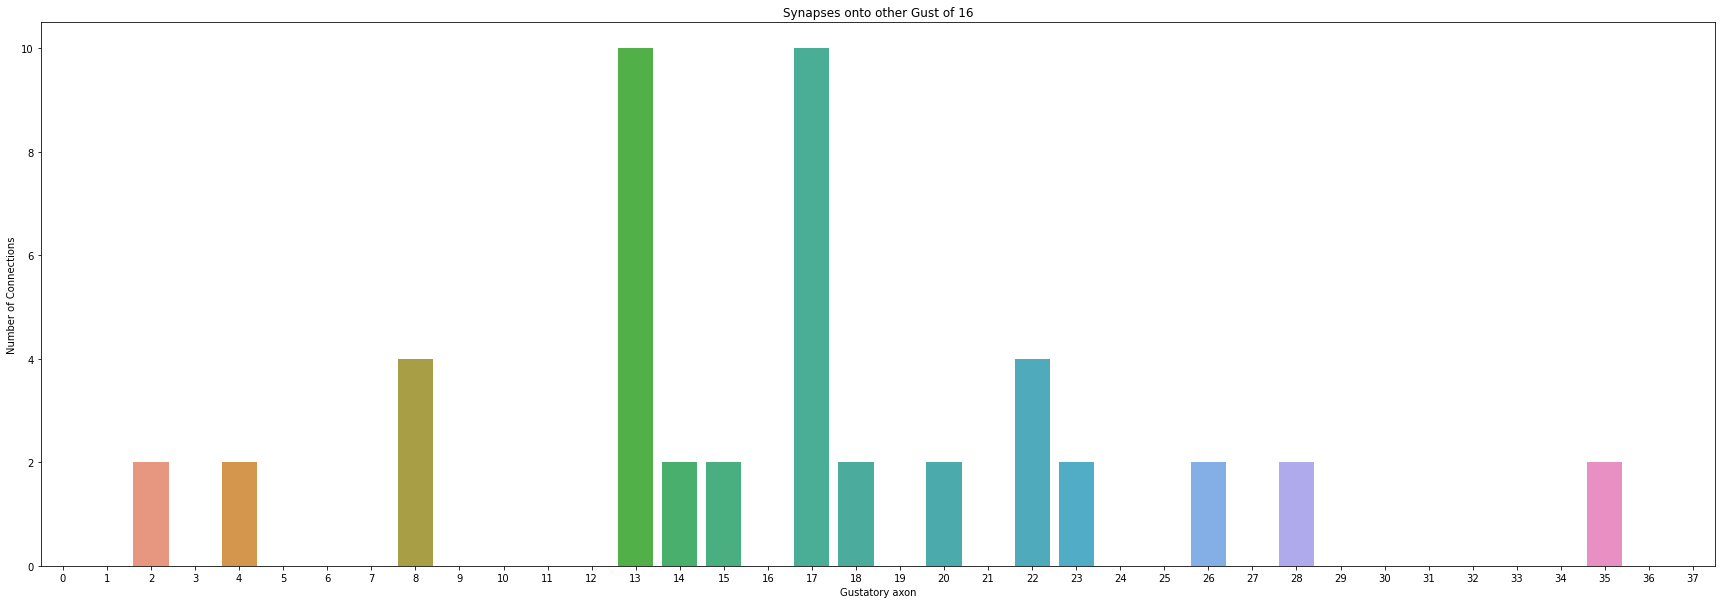

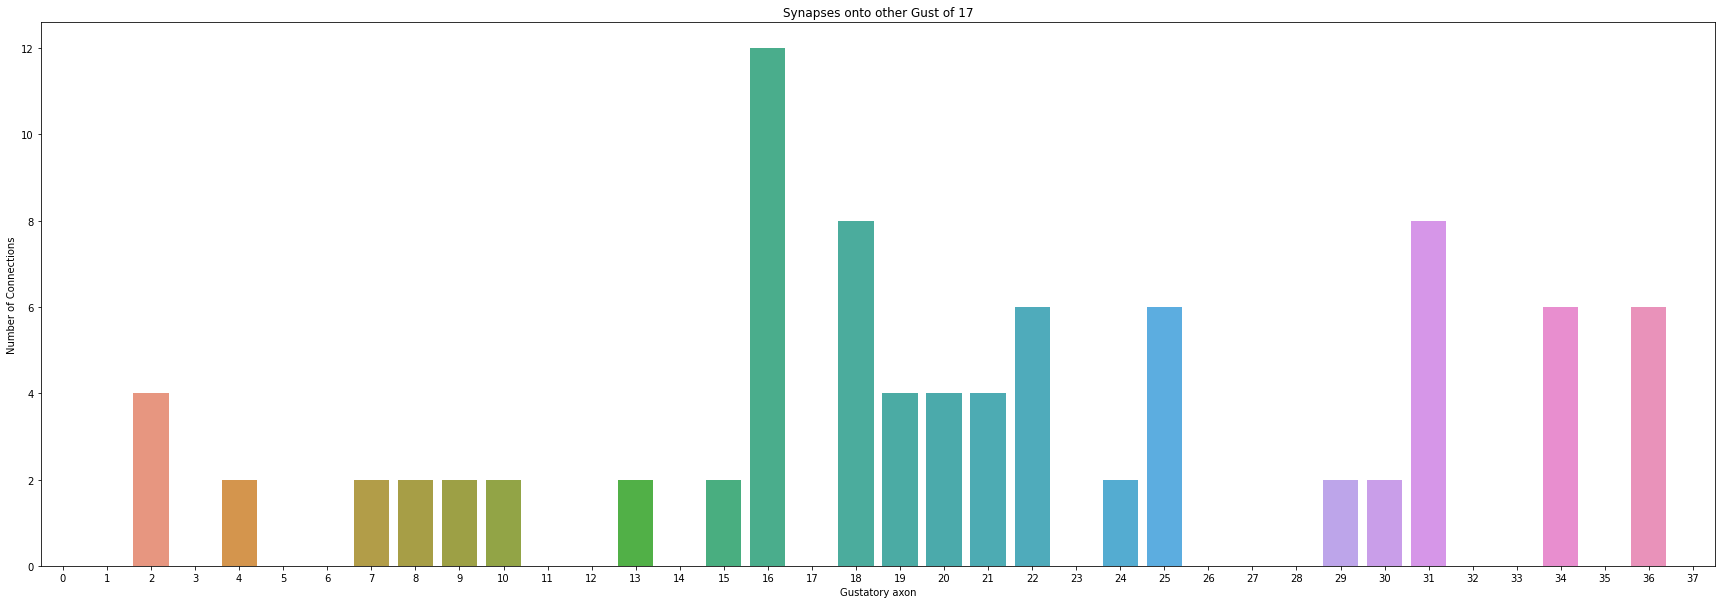

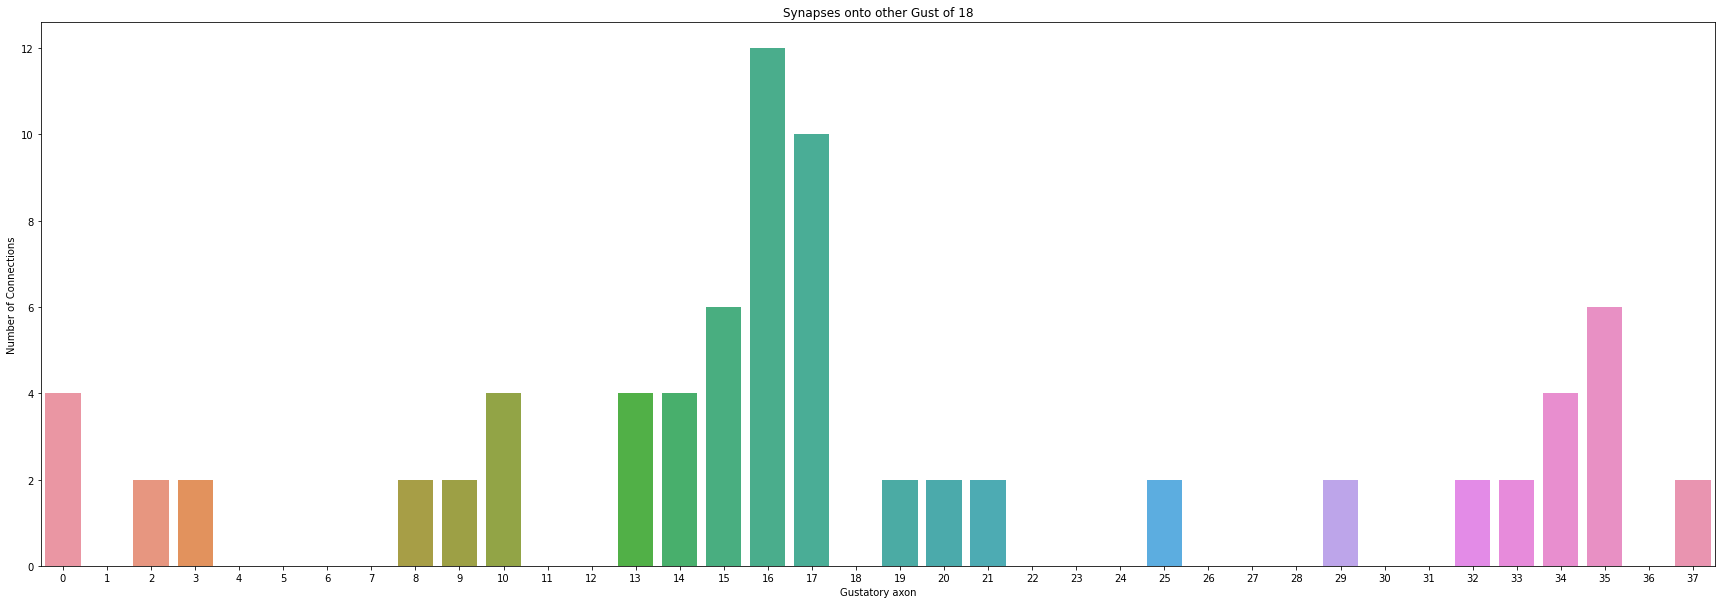

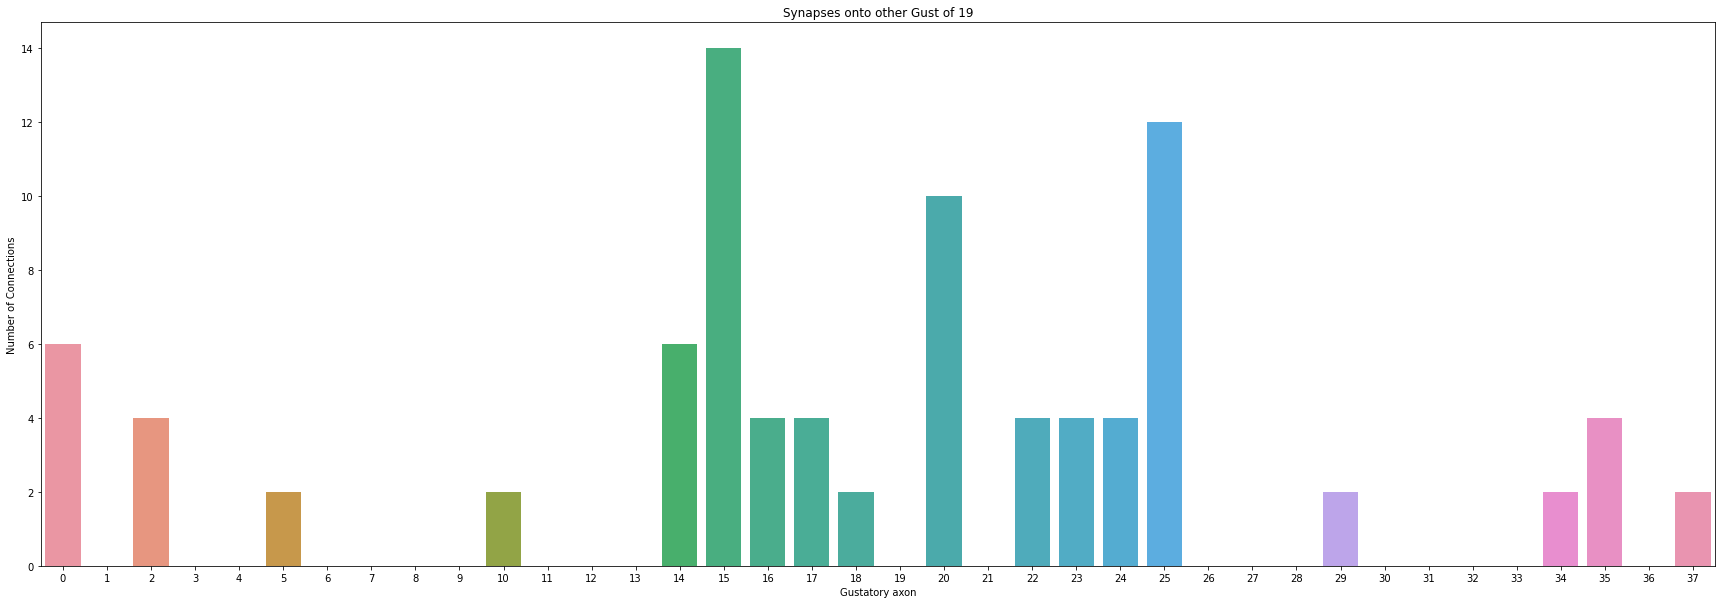

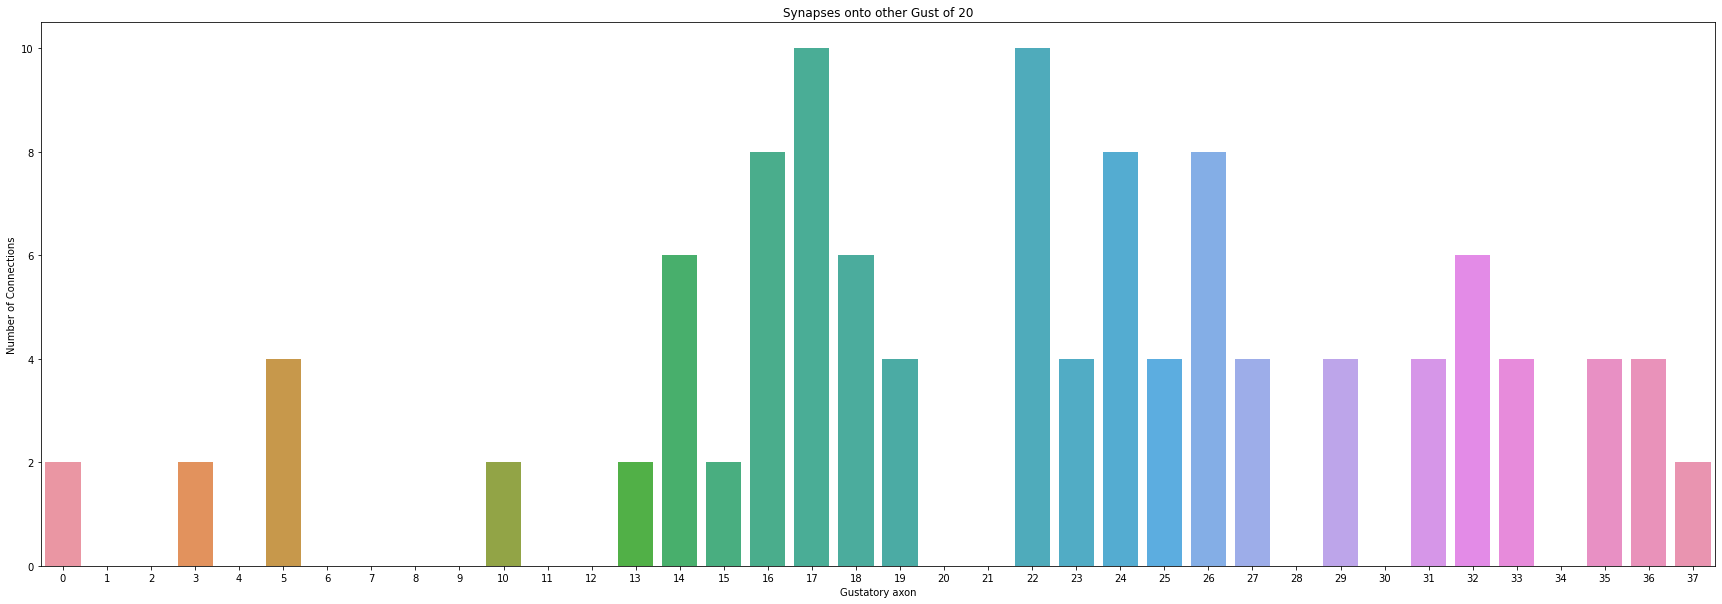

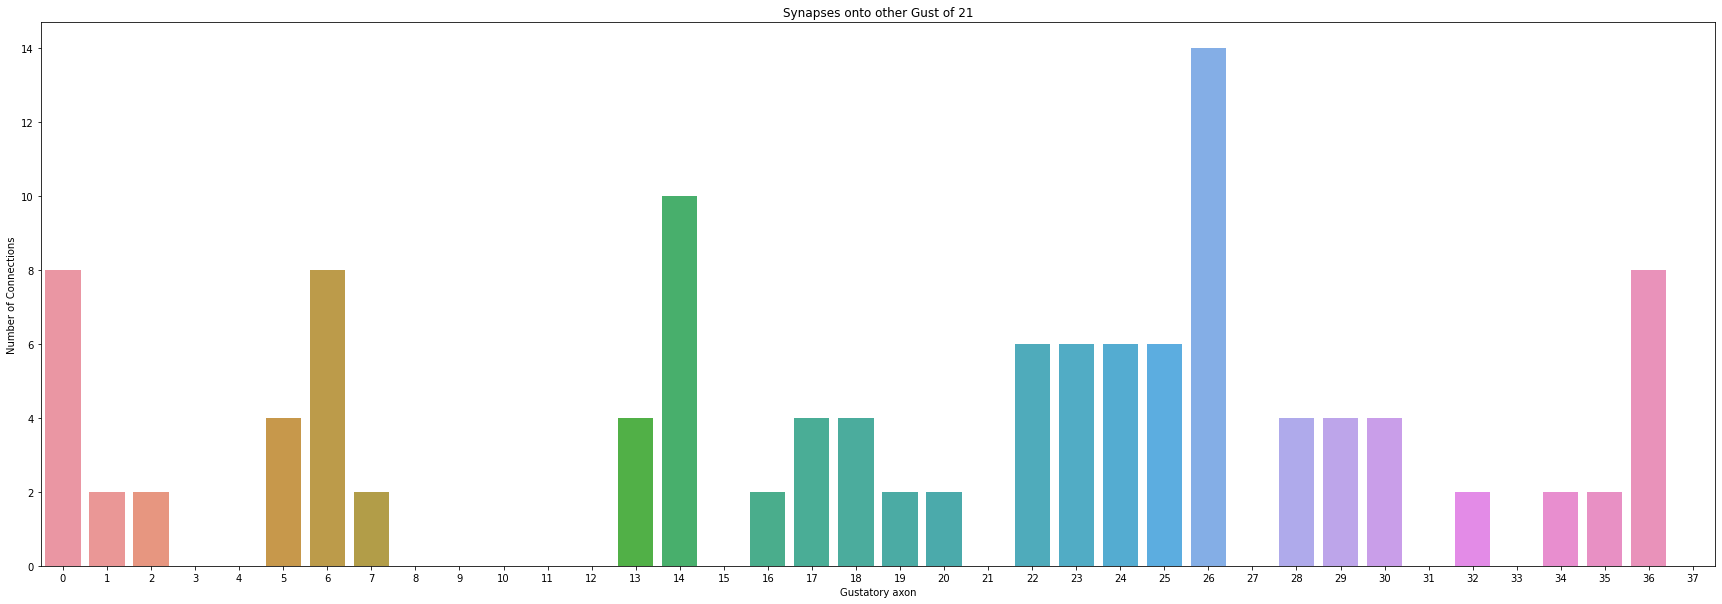

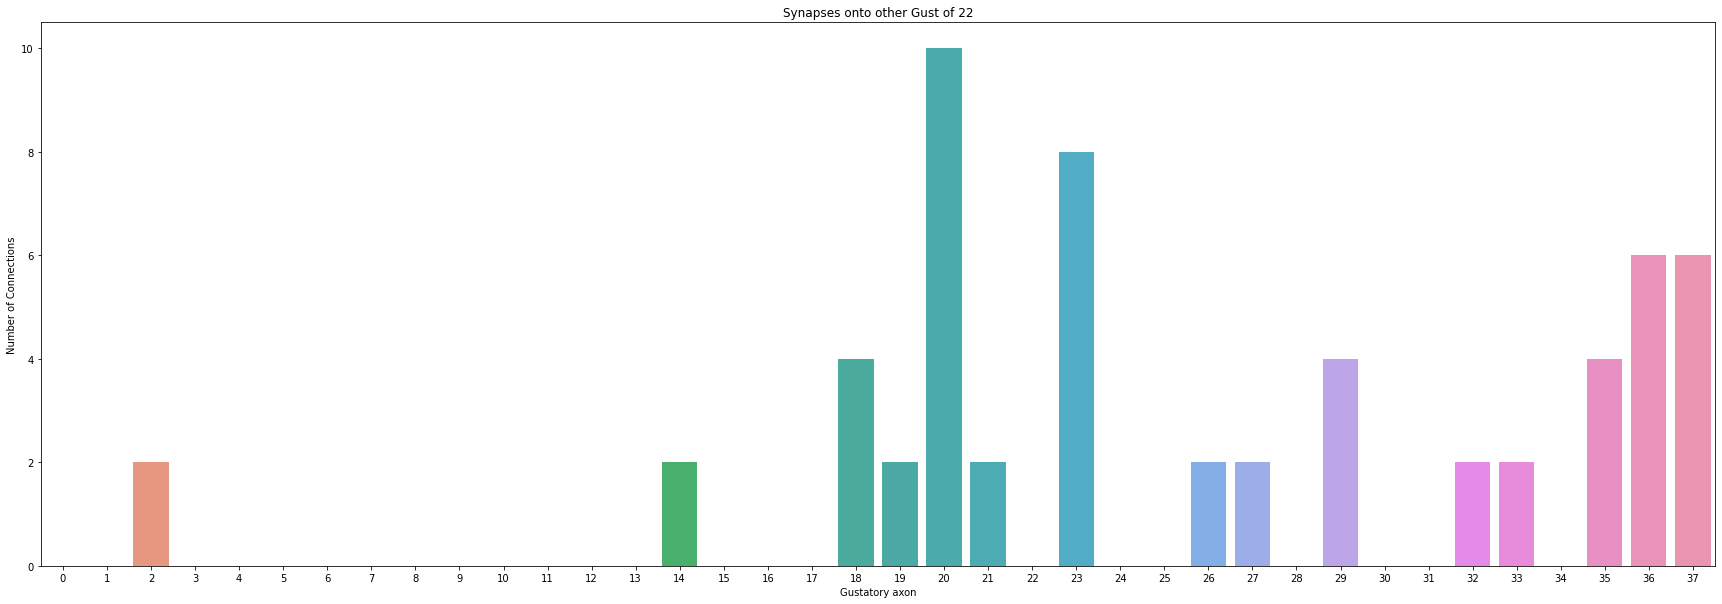

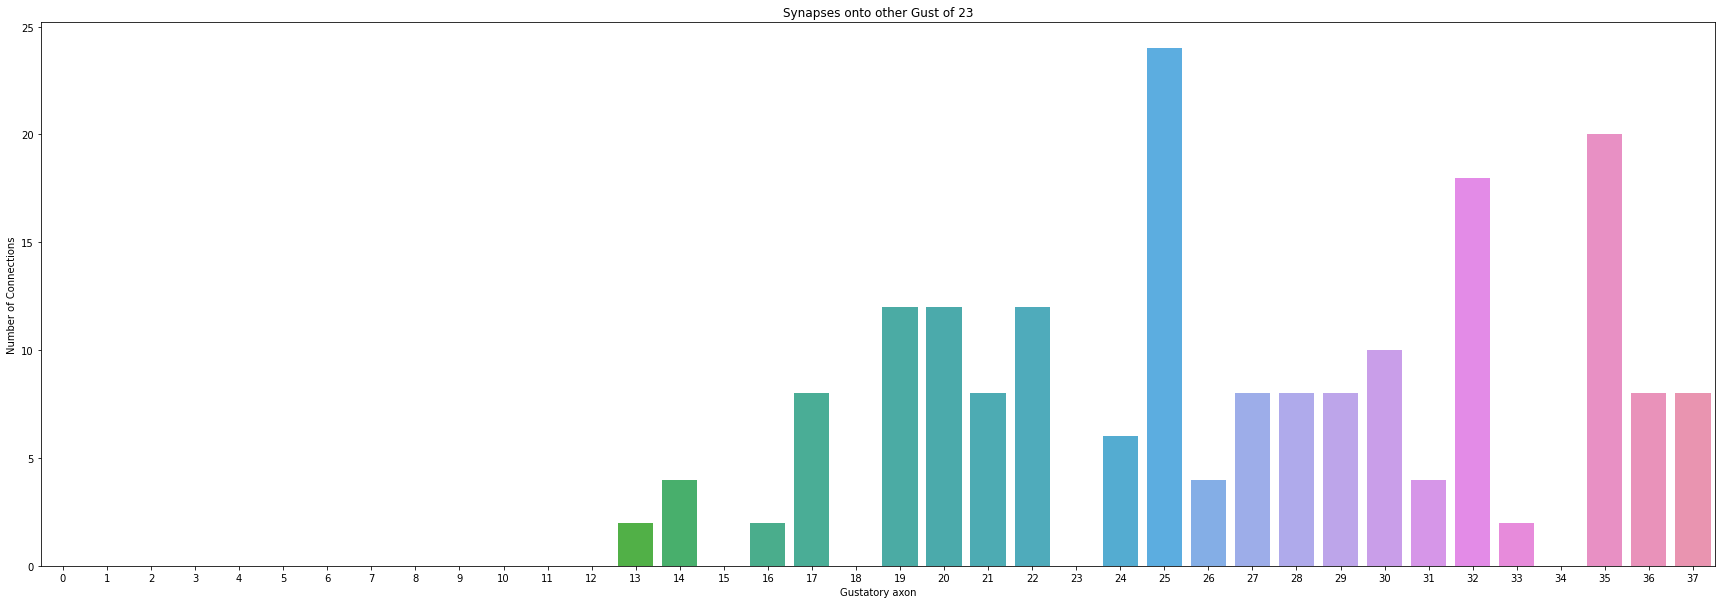

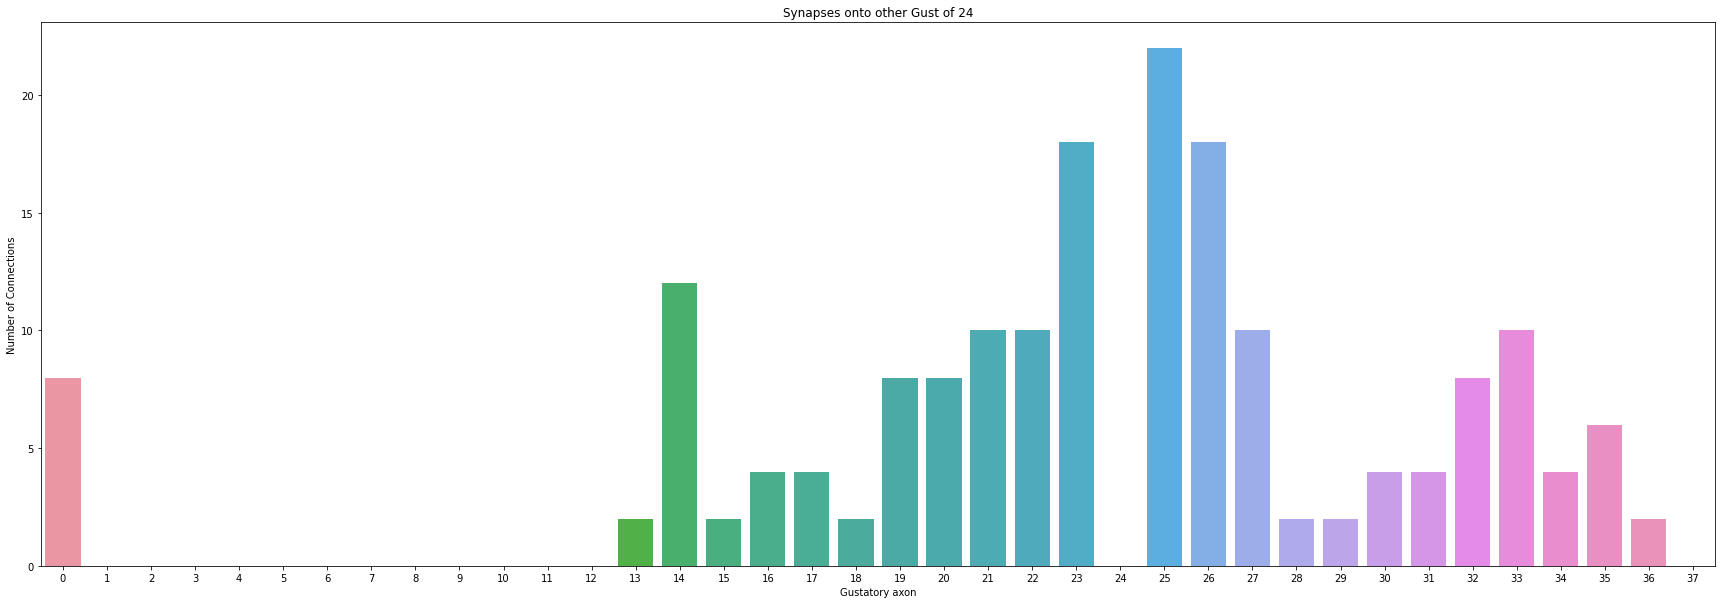

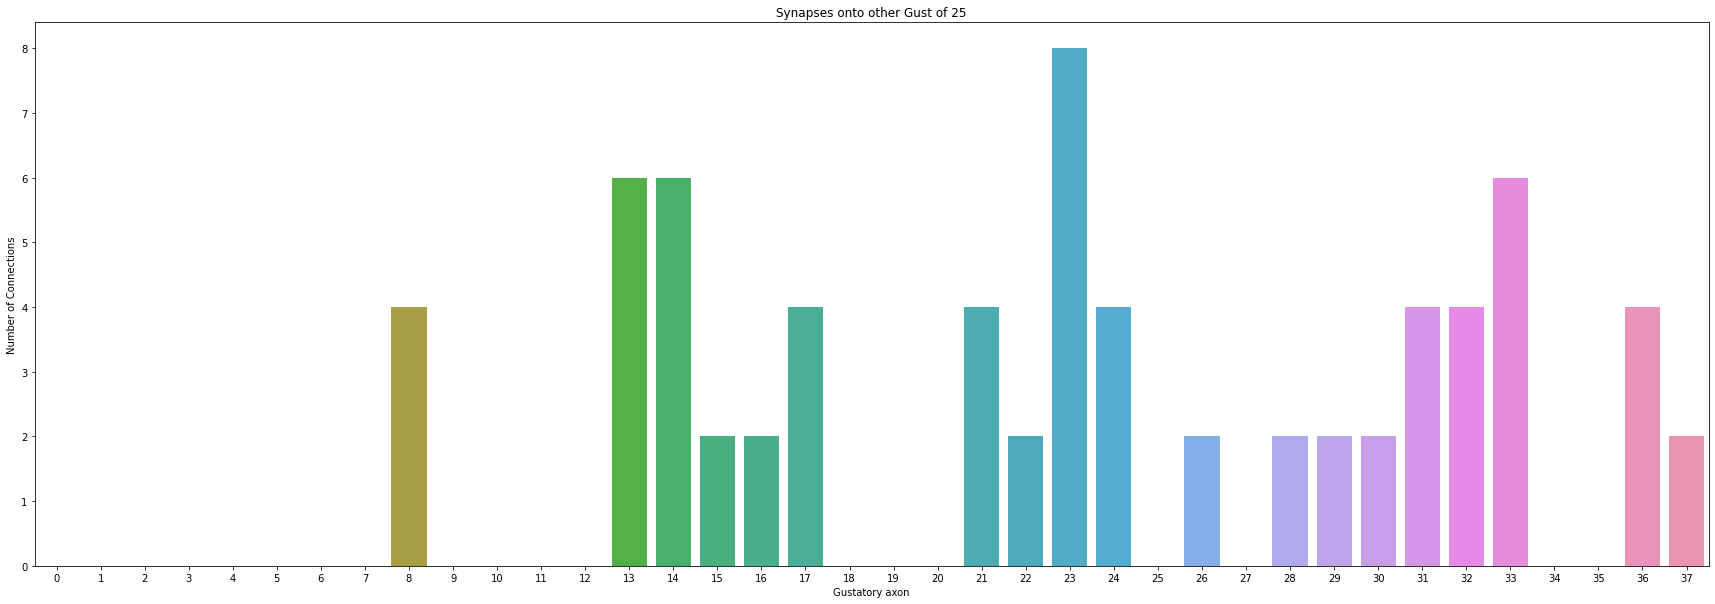

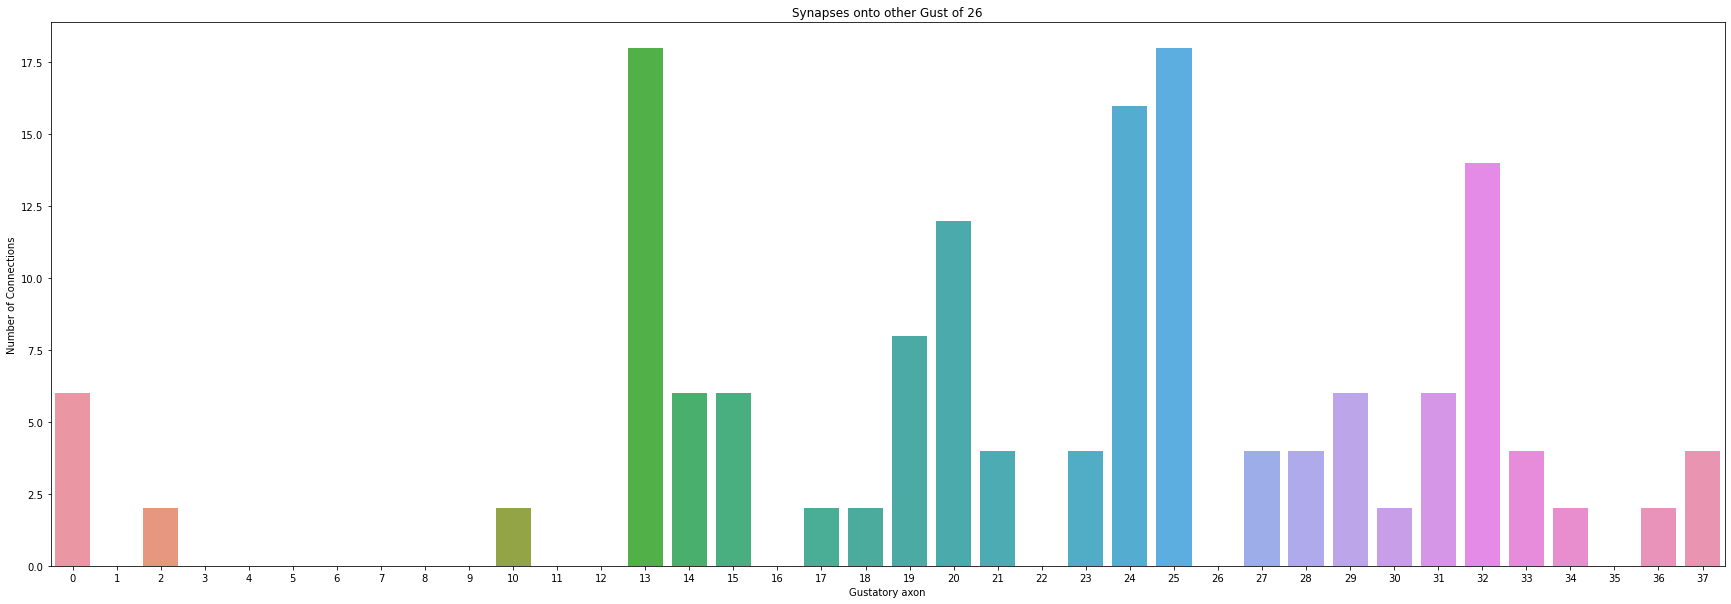

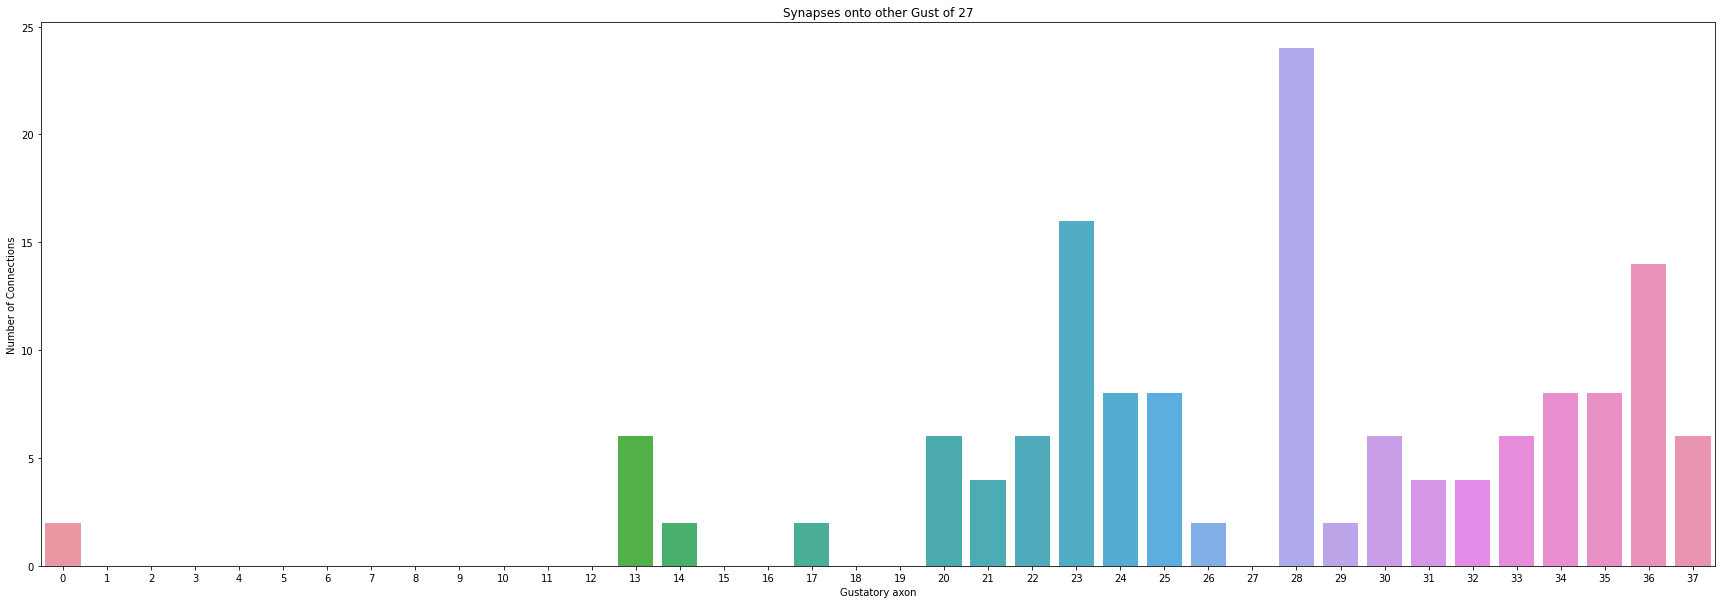

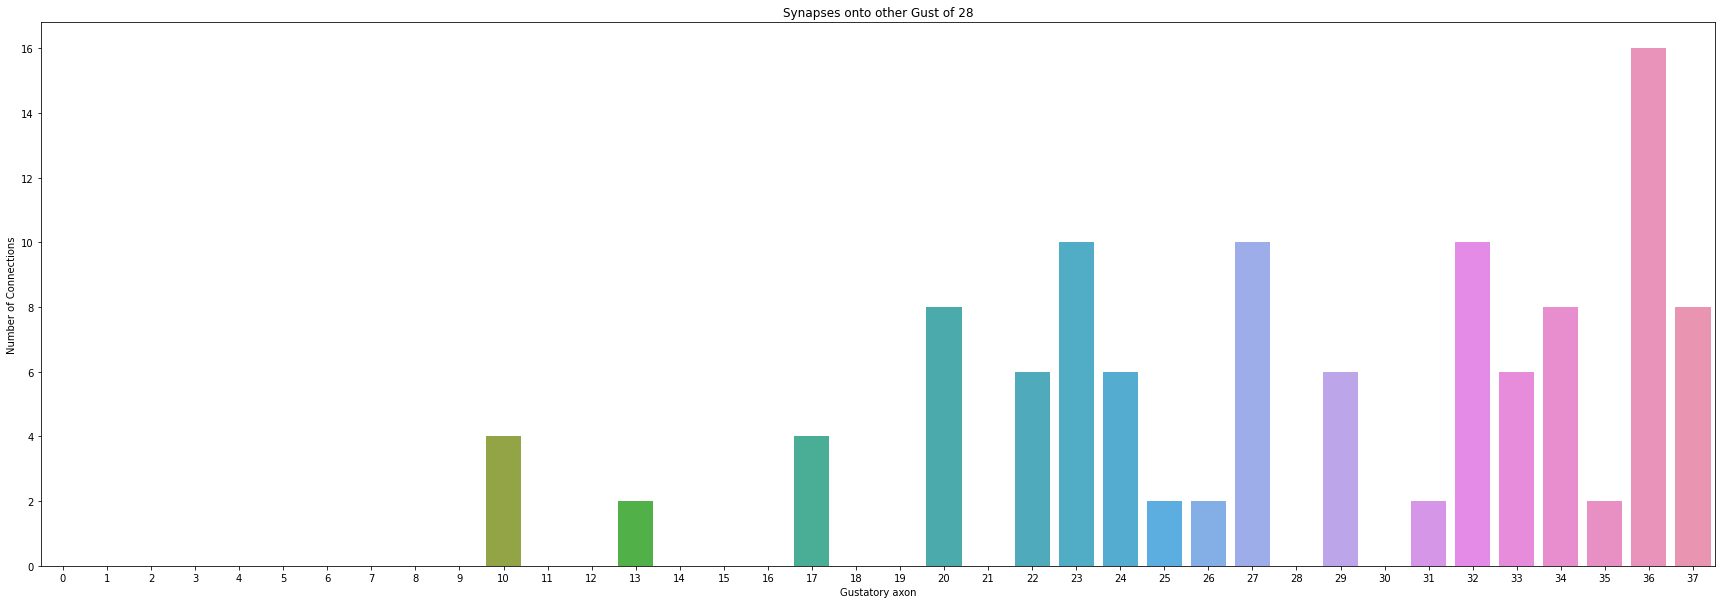

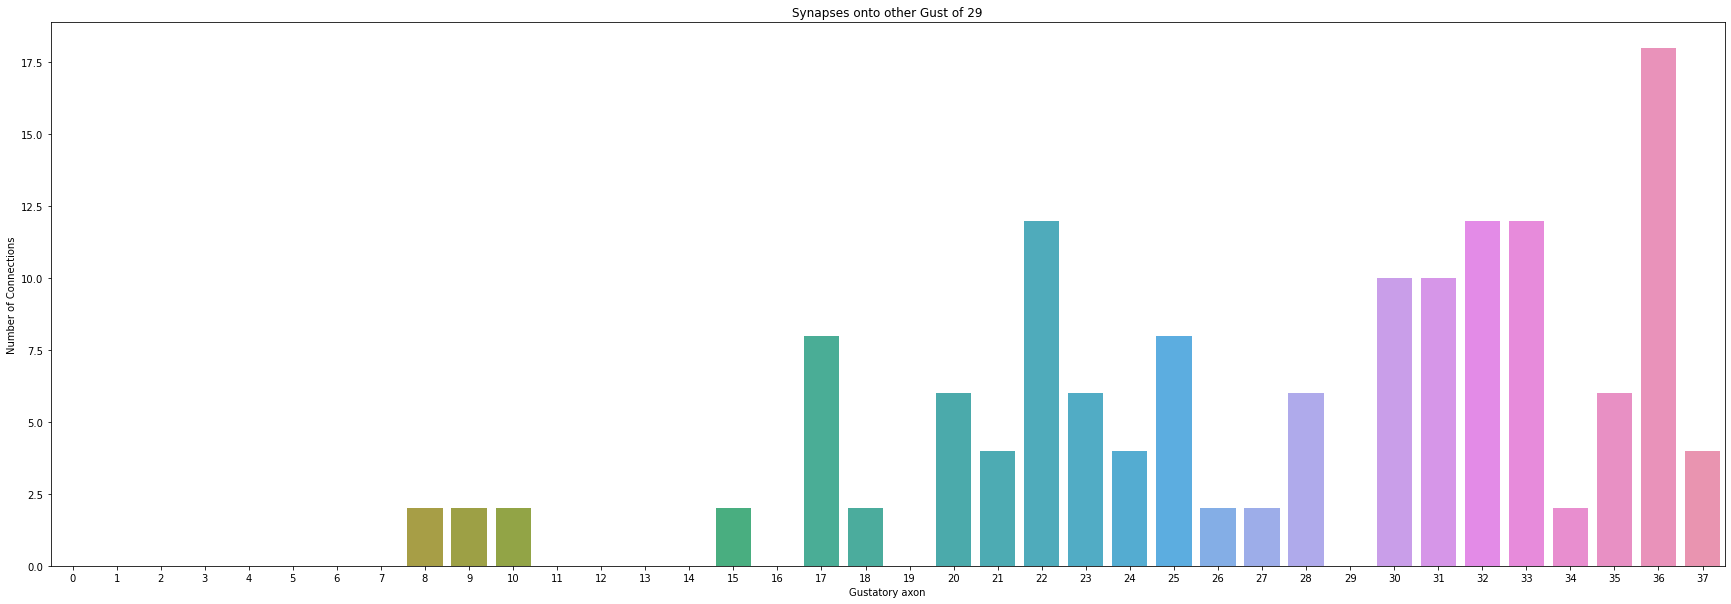

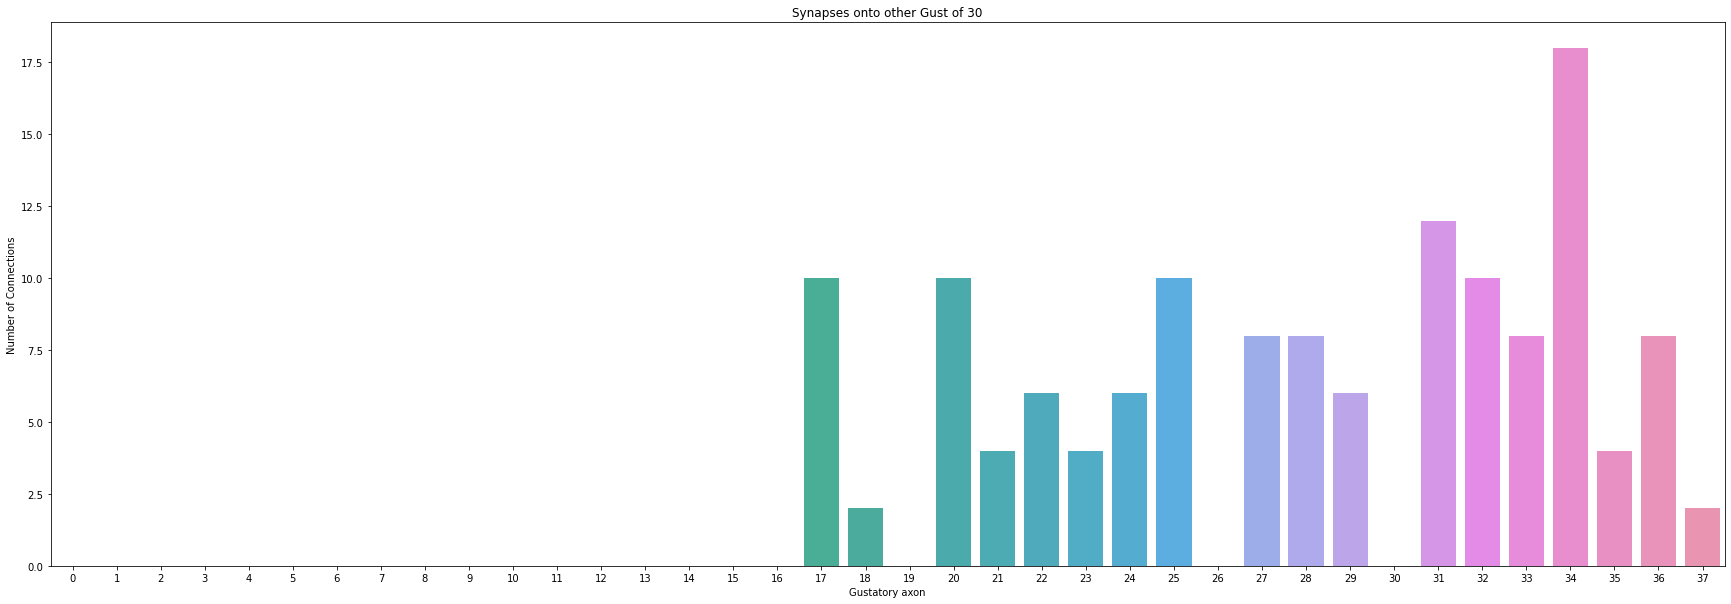

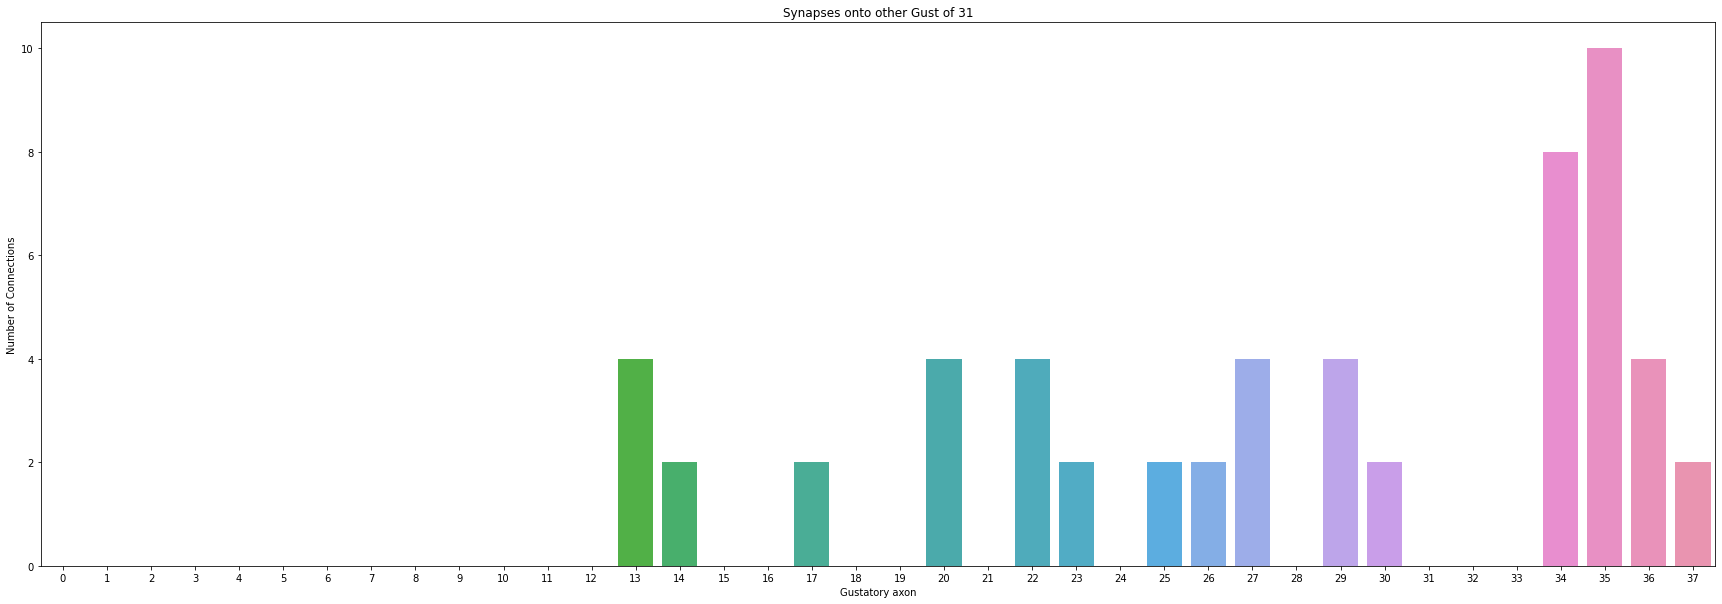

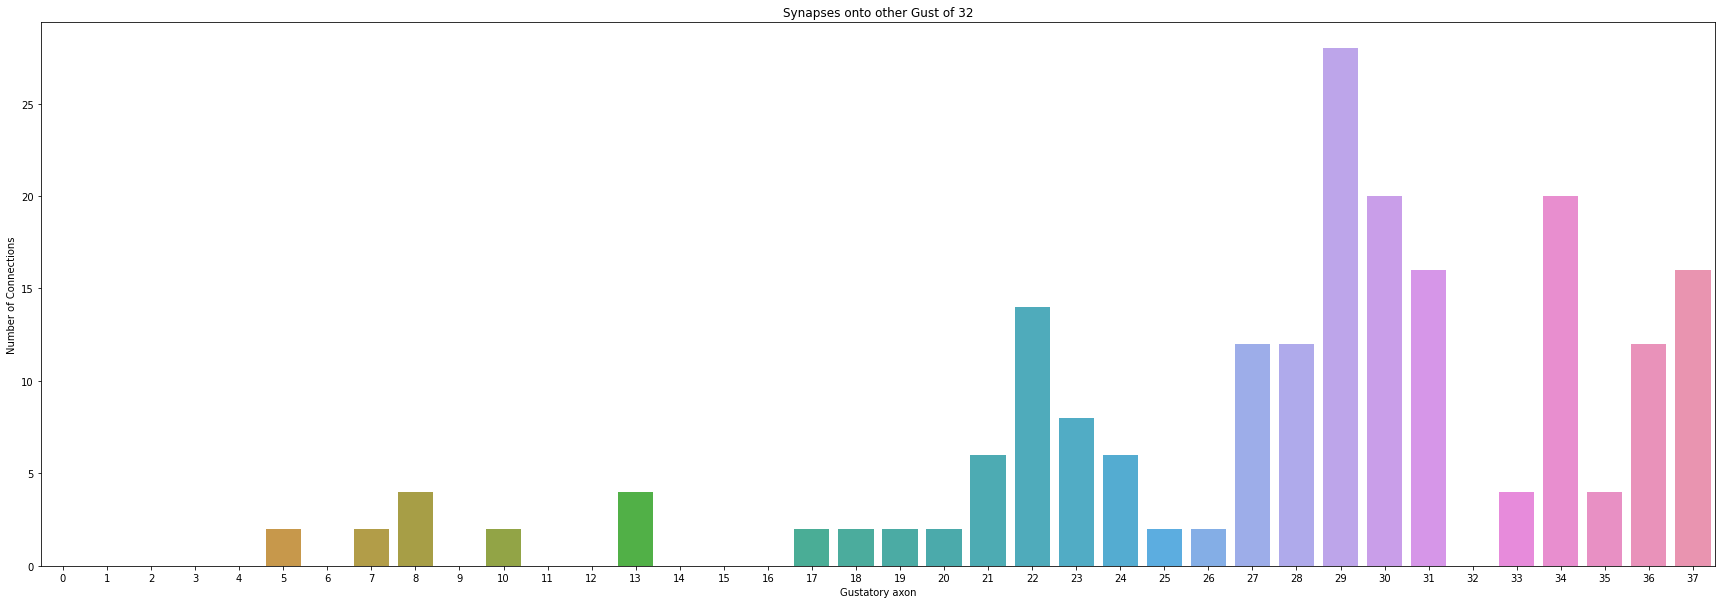

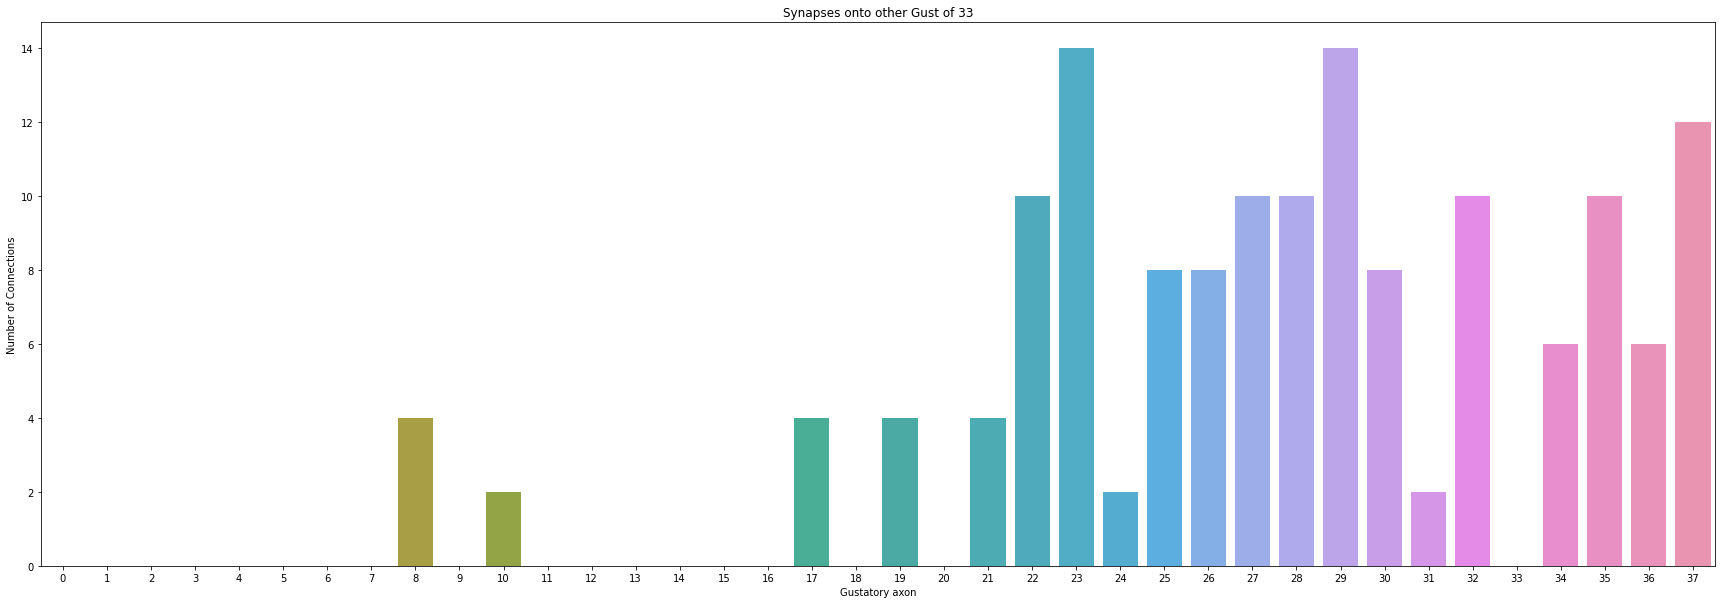

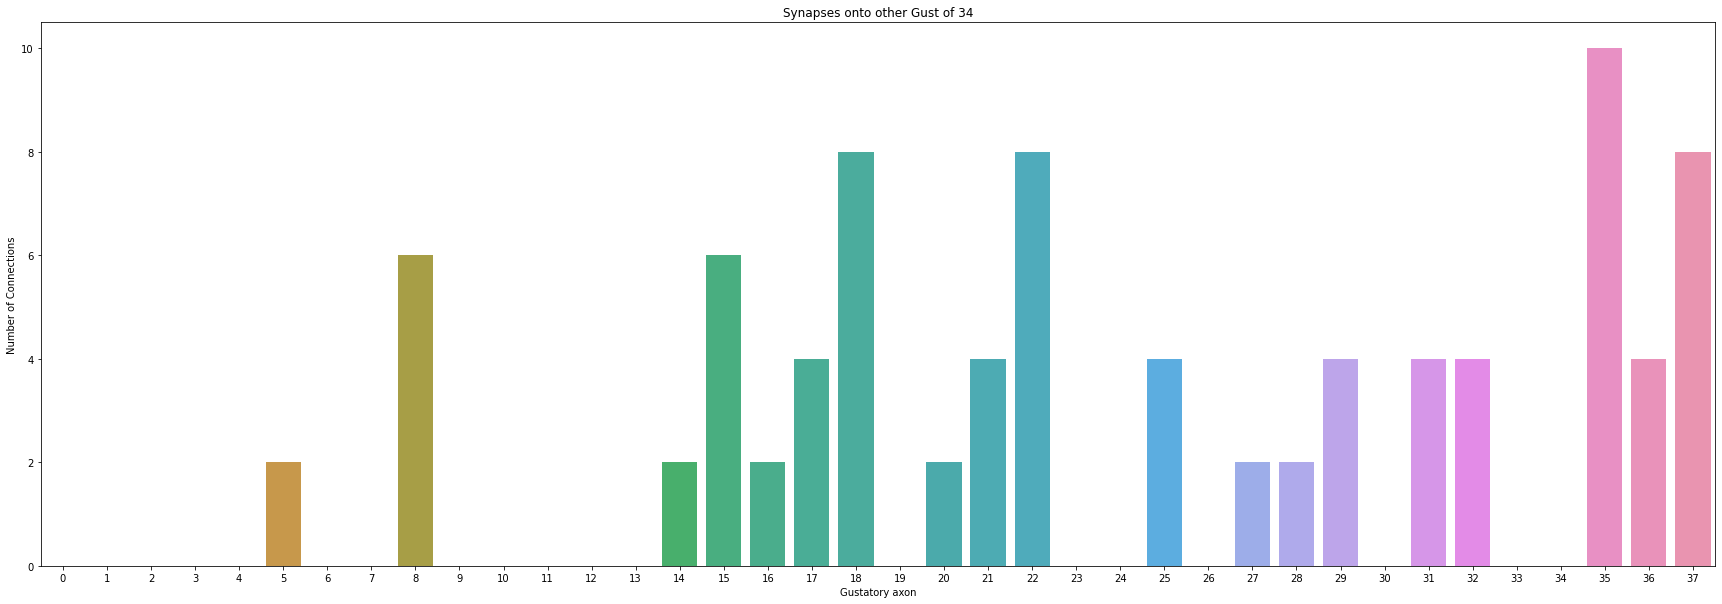

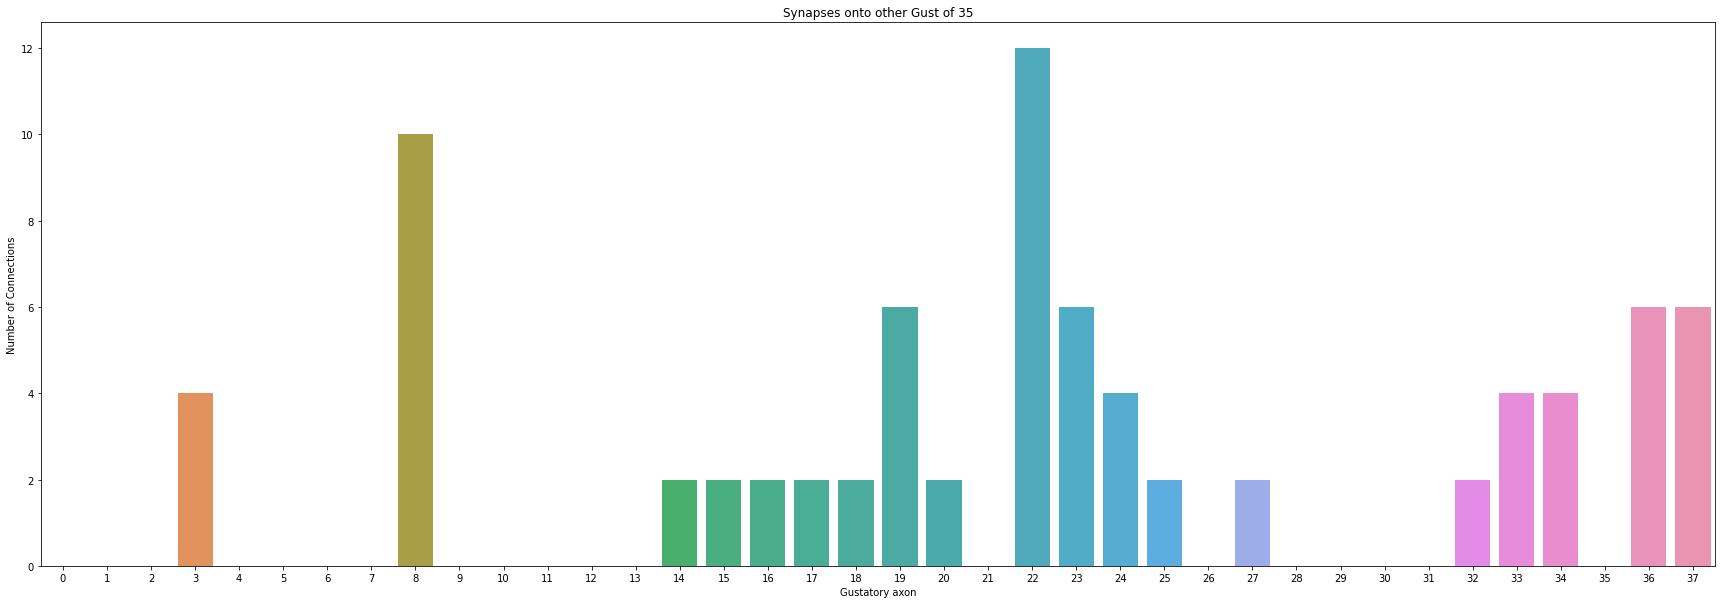

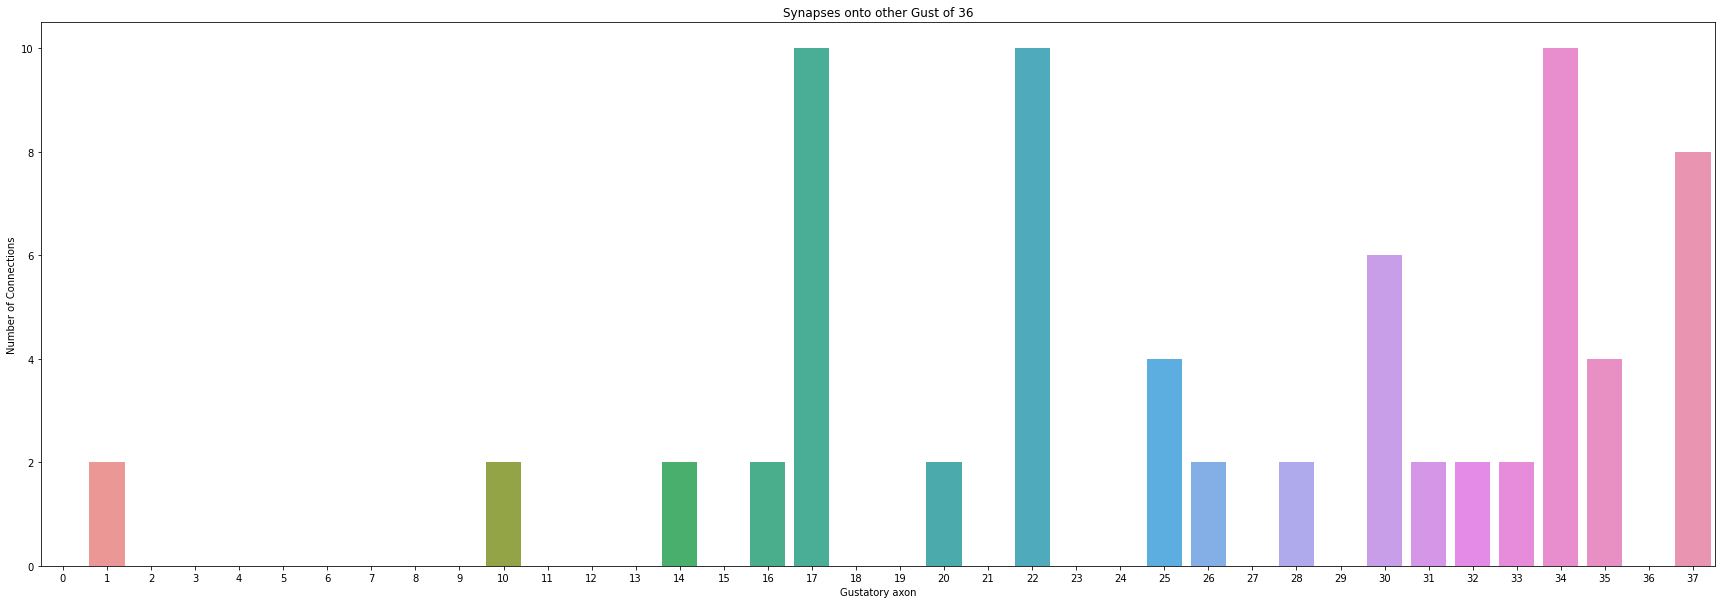

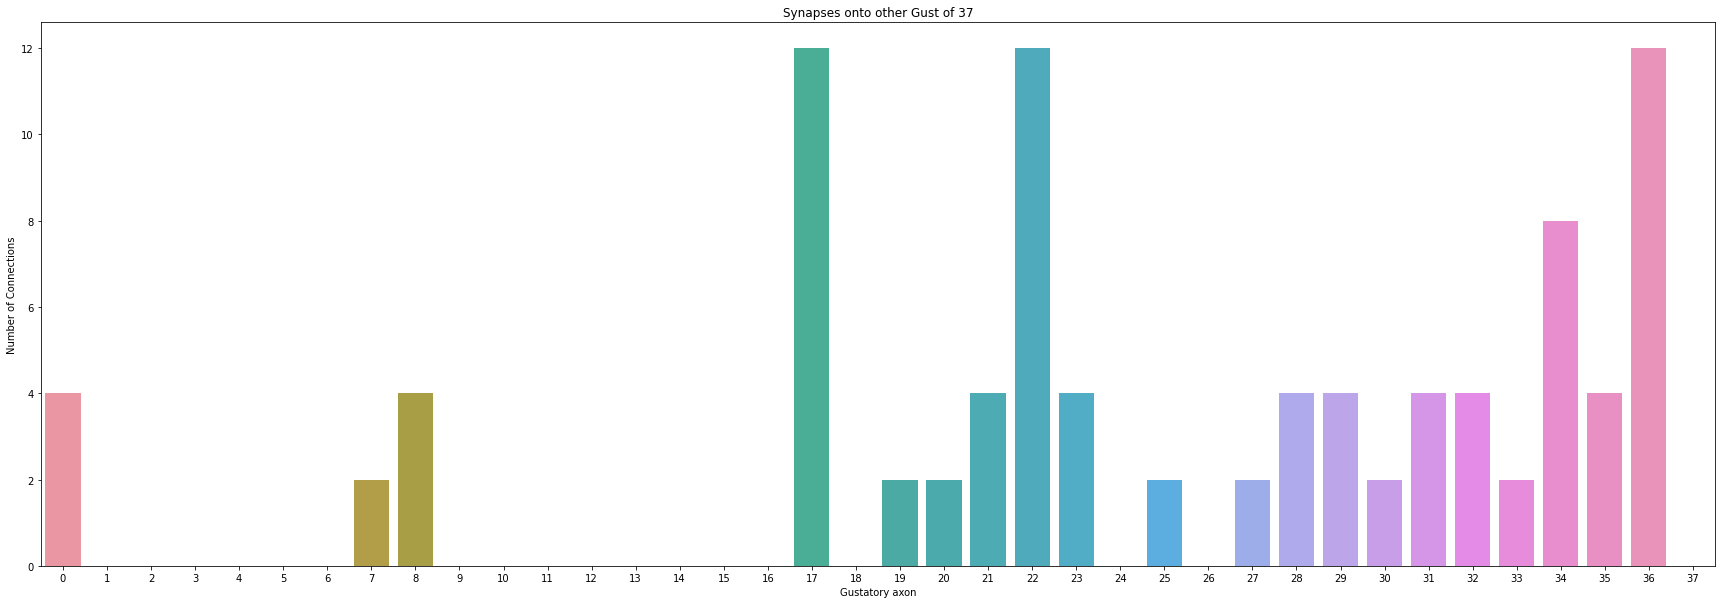

In [83]:
for i in range(0,len(ids_map_gust_gust)):
    barplot_a_gust(i, edge_with_zeros, normalized = False)

In [84]:
# create a vector encoding gustatory axons' synapses onto downstream partners for each gustatory axon
# barplot with downstream partners being x-axis categorical data and y-axis being synapses from each gust (or a group of gust)
## onto a downstream partners
# allows seeing what downstream partner groups stand out the most for each gust (or group of gust)

## Change labeling of gust_down_df for gustatory neurons in the df

In [85]:
gust_down_df

,id,created,superceded_id,valid,score,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position
0,18908478,2022-11-17 14:28:59.843347+00:00,NaN,t,45,72976031723852742,648518346490998904,72976031723844598,648518346472549067,"[26905, 110481, 3627]","[26879, 110479, 3627]"
1,21210916,2022-11-17 14:28:59.843347+00:00,NaN,t,52,72905731632166795,648518346498142362,72905731632154272,648518346496105674,"[25777, 111181, 3555]","[25741, 111175, 3555]"
2,42159490,2022-11-17 14:28:59.843347+00:00,NaN,t,26,73116769078208590,648518346512198702,73116769078362277,648518346480429339,"[31203, 109095, 3456]","[31191, 109095, 3456]"
3,42159345,2022-11-17 14:28:59.843347+00:00,NaN,t,28,73116769078066658,648518346475523508,73116769078061944,648518346449559180,"[30953, 109445, 3396]","[30977, 109421, 3396]"
4,42159216,2022-11-17 14:28:59.843347+00:00,NaN,t,39,73116769078086402,648518346475523508,73116769078083948,648518346496575868,"[30795, 109407, 3404]","[30767, 109415, 3405]"
...,...,...,...,...,...,...,...,...,...,...,...
20959,40317718,2022-11-17 14:28:59.843347+00:00,NaN,t,36,72905731565001707,648518346514564807,72905731565004298,648518346377222756,"[26007, 111771, 3403]","[26001, 111753, 3404]"
20960,40317959,2022-11-17 14:28:59.843347+00:00,NaN,t,45,72905731565092214,648518346517576040,72905731565078091,648518346494140411,"[26169, 111813, 3435]","[26189, 111805, 3434]"
20961,40318003,2022-11-17 14:28:59.843347+00:00,NaN,t,21,72905731564960564,648518346489829683,72905731564977593,648518346490999160,"[26229, 111707, 3393]","[26213, 111733, 3394]"
20962,40318002,2022-11-17 14:28:59.843347+00:00,NaN,t,33,72905731565039997,648518346476980168,72905731565039968,648518346508881215,"[26241, 111967, 3419]","[26211, 111947, 3419]"


In [86]:
post_class = np.array(['others']*gust_down_df.shape[0])
gust_down_post_gust = gust_down_df.post_pt_root_id.isin(gust_lst).to_numpy()
post_class[gust_down_post_gust] = 'gust'
gust_down_df['post_class'] = post_class

## Proportion of inputs and outputs on other gustatory neurons from/to gustatory neurons

In [87]:
# Get downstream table with labeling of gust and others for gustatory neurons
    # Get edge table for pre-post-others and pre-post-gust
    # plot hist proportion

In [88]:
# Get downstream table with labeling of gust and others for gustatory neurons
# Get edge table for pre-post-others and pre-post-gust
gust_dwn_edge = gust_down_df.groupby(['pre_pt_root_id','post_pt_root_id','post_class'], 
                                     dropna=False).size().sort_values(ascending=False).reset_index(name='count')
gust_dwn_edge = gust_dwn_edge.query('count > 3')


In [89]:
# total
gust_dwn_edge_tot = gust_dwn_edge.groupby(['post_class'], dropna=False).sum().reset_index()

In [90]:
gust_dwn_edge_tot

,post_class,pre_pt_root_id,post_pt_root_id,count
0,gust,118030339061426077696,118030339061770092544,1155
1,others,402081374825151201280,402081374825213722624,5749


[Text(0.5, 1.0, 'number of synapses made by gustatory neurons')]

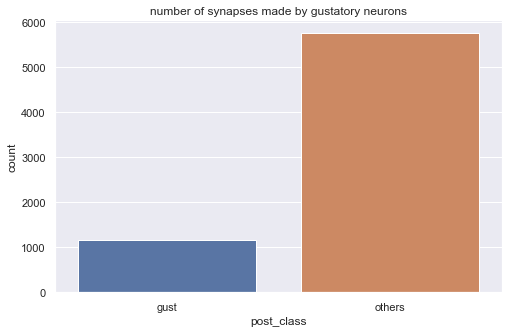

In [91]:
sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(data=gust_dwn_edge_tot, x="post_class", y='count').set(title='number of synapses made by gustatory neurons')


[Text(0.5, 1.0, 'Total Proportion of Connection Made by Gustatory Neruons')]

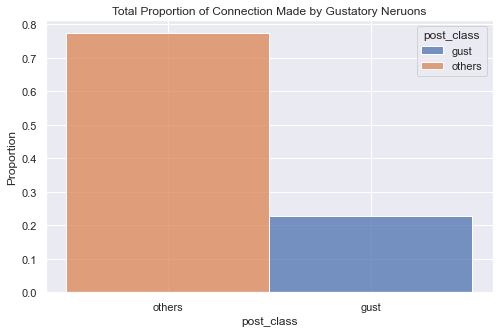

In [92]:
sns.set(rc={'figure.figsize':(8,5)})
sns.histplot(data=gust_dwn_edge, x='post_class', stat='proportion', 
             multiple='stack', hue='post_class', hue_order=gust_dwn_edge.post_class.unique()[::-1]).set(title='Total Proportion of Connection Made by Gustatory Neruons')


In [93]:
gust_dwn_edge['pre_order'] = gust_dwn_edge['pre_pt_root_id'].map(ids_map_gust_downstream)

### Defines percent_stacked_bar_2 using sns

In [94]:
# df must have column of 'count' for the number of synapses
# df: the df to be plotted
# by: the list of size 2 of strings of the columns names where by[0] is the column where the "counts" are of, 
#     and by[1] is the column with label/classification of the by[0] to be stacked on top of one another
def percent_stacked_bar_2(df, by):
    total = df.groupby(by[0])['count'].sum().reset_index()
    sum_of = list(df[by[1]].unique())
    items = []
    temp = total.copy() # temp list for culmulative sum of iterated counts of items/labels
    temp['count'] = [i/ j * 100 for i,j in zip(temp['count'], total['count'])]
    label = []
    color_cycle = sns.color_palette(n_colors=len(sum_of))
    sns.barplot(x=by[0][0], y='count', data=temp, color=color_cycle[0])
    label.append(mpatches.Patch(label=sum_of[0], color=color_cycle[0]))
    for i, item in enumerate(sum_of):
        items.append(df[df[by[1]]==item].groupby(by[0])['count'].sum().reset_index())
        items[i] = get_full_axon_df(total, items[i], groupby=by[0][0])
        items[i]['count'] = [i/ j * 100 for i,j in zip(items[i]['count'], total['count'])]
        temp['count'] = temp['count'] - items[i]['count']
#         items[i]['count'] = (items[i-1]['count'] - items[i]['count'])
        if (i+1 < len(sum_of)):
            sns.barplot(x=by[0][0],y='count', data=temp, color=color_cycle[i+1]).set(ylabel='Percent of Synapses')
            label.append(mpatches.Patch(label=sum_of[i+1], color=color_cycle[i+1]))
    plt.legend(handles=label,loc='lower right', bbox_to_anchor=(1,1), ncol=1, prop={"size":15})
    return items

[Text(0.5, 1.0, 'number of synapses made by each gustatory neuron')]

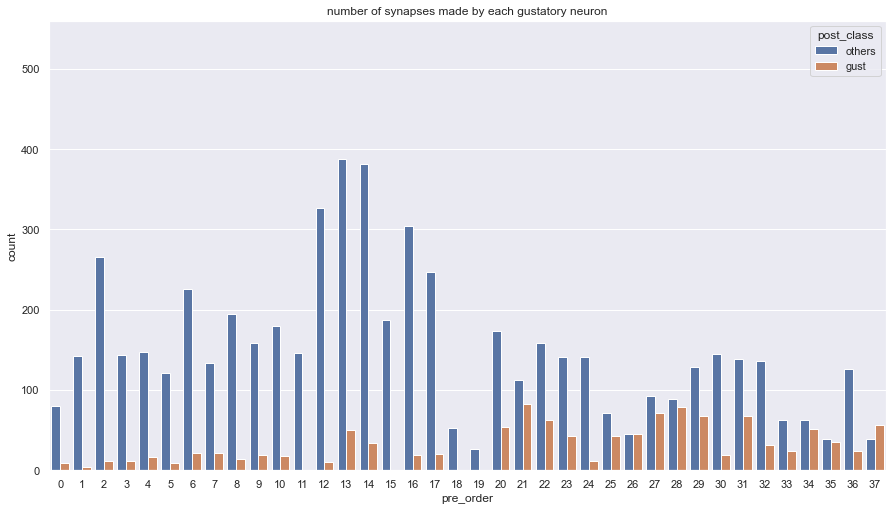

In [95]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.barplot(data=gust_dwn_edge, x="pre_order", y='count', hue='post_class', estimator = np.sum,
            errwidth=0).set(title='number of synapses made by each gustatory neuron')

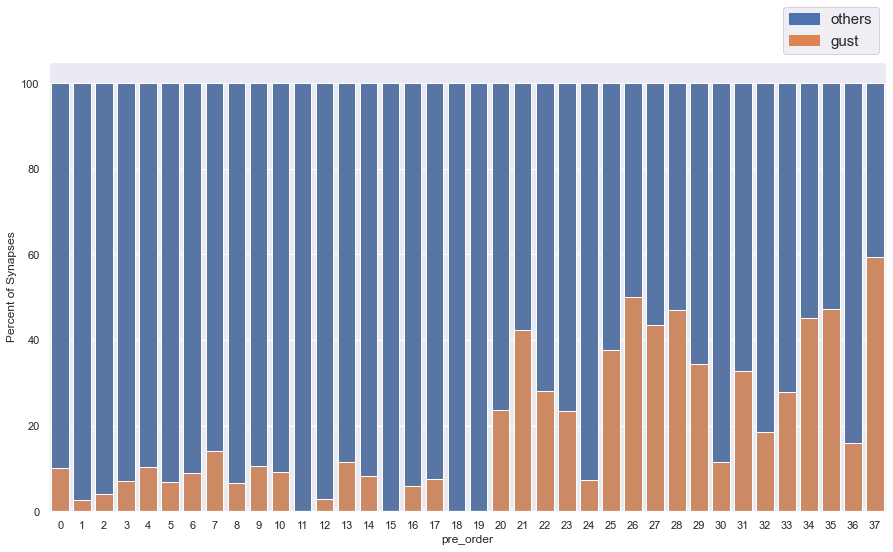

In [96]:
dwn_percentage = percent_stacked_bar_2(gust_dwn_edge, [['pre_order'], 'post_class'])

In [97]:
# Get upstream table with labeling of gust and others for gustatory neurons
    # Get edge table for post-pre-others and post-pre-gust
    # plot hist proportion

In [98]:
pre_class = np.array(['others']*gust_up_df.shape[0])
gust_up_pre_gust = gust_up_df.pre_pt_root_id.isin(gust_lst).to_numpy()
pre_class[gust_up_pre_gust] = 'gust'
gust_up_df['pre_class'] = pre_class

In [99]:
# groupby post-pre-preclass
gust_up_edge = gust_up_df.groupby(['post_pt_root_id','pre_pt_root_id','pre_class'], 
                                     dropna=False).size().sort_values(ascending=False).reset_index(name='count')
gust_up_edge = gust_up_edge.query('count > 3')

# total of 'gust' and 'others'
gust_up_edge_tot = gust_up_edge.groupby(['pre_class'], dropna=False).sum().reset_index()

In [100]:
1155/(1155+1635)

0.41397849462365593

In [101]:
gust_up_edge_tot

,pre_class,post_pt_root_id,pre_pt_root_id,count
0,gust,118030339061770092544,118030339061426077696,1155
1,others,120624412447914082304,120624412447986499584,1644


[Text(0.5, 1.0, 'number of synapses received by gustatory neurons')]

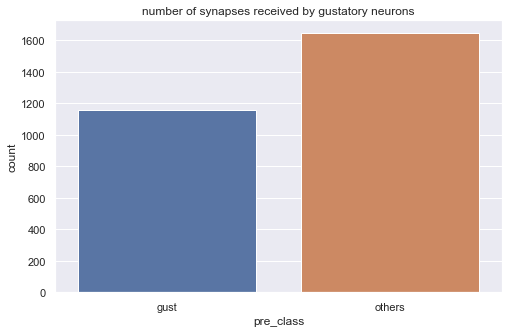

In [102]:
sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(data=gust_up_edge_tot, x="pre_class", y='count').set(title='number of synapses received by gustatory neurons')


[Text(0.5, 1.0, 'Total Proportion of Connection Made by Gustatory Neruons')]

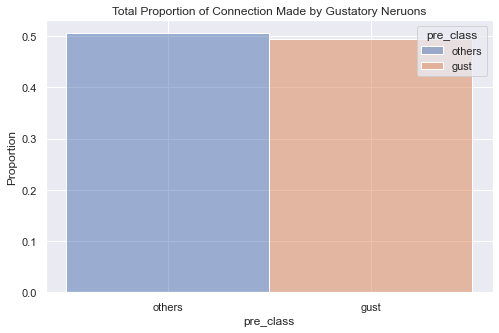

In [103]:
sns.set(rc={'figure.figsize':(8,5)})
sns.histplot(data=gust_up_edge, x='pre_class',stat='proportion',
             hue='pre_class').set(title='Total Proportion of Connection Made by Gustatory Neruons')

In [104]:
# ordering gustatory neurons by cosine similarity based on their downstream connectivity
gust_up_edge['post_order'] = gust_up_edge['post_pt_root_id'].map(ids_map_gust_downstream)

[Text(0.5, 1.0, 'number of synapses received by each gustatory neuron')]

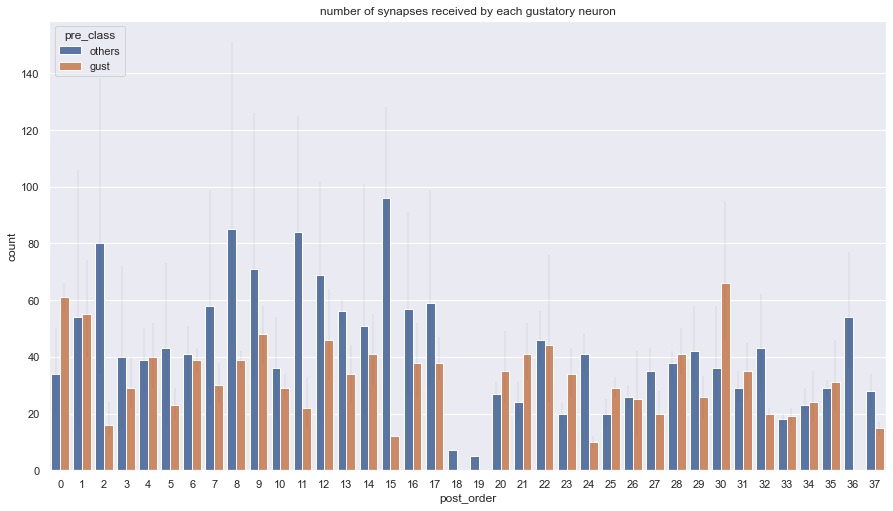

In [105]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.barplot(data=gust_up_edge, x="post_order", y='count', hue='pre_class', estimator=np.sum,
            errwidth=0.1).set(title='number of synapses received by each gustatory neuron')

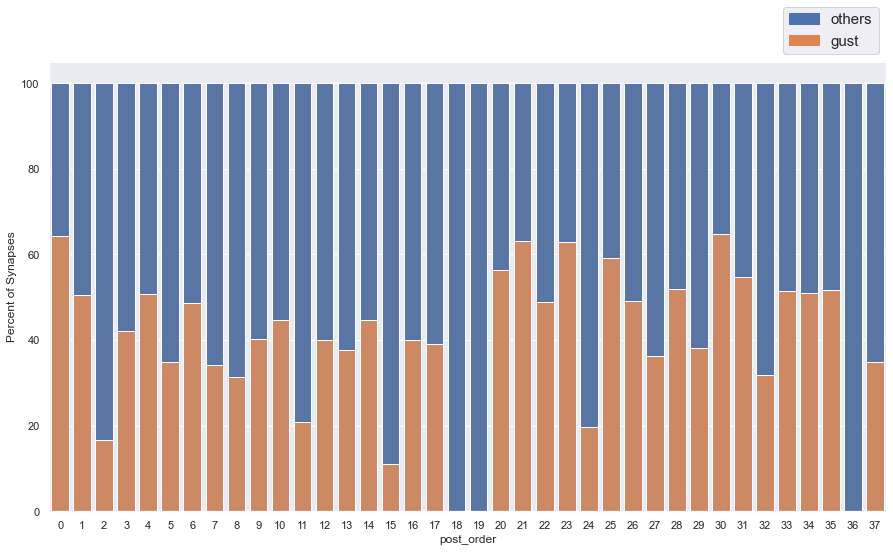

In [106]:
up_percentage = percent_stacked_bar_2(gust_up_edge, [['post_order'], 'pre_class'])

## Compare similarity between gust_downstream and gust_gust

In [107]:
lst1_dwn= list(range(19))
lst1_dwn = sorted([i for i in list(dct1.keys()) if (dct1[i] in lst1_dwn)])
lst2_dwn = list(range(19,39))
lst2_dwn = sorted([i for i in list(dct1.keys()) if (dct1[i] in lst2_dwn)])
lst1_gust = list(range(13))
lst1_gust = sorted([i for i in list(dct2.keys()) if (dct2[i] in lst1_gust)])
lst2_gust = list(range(13,37))
lst2_gust = sorted([i for i in list(dct2.keys()) if (dct2[i] in lst2_gust)])
len(lst1_dwn), len(lst2_dwn), len(lst1_gust), len(lst2_gust)

(19, 19, 13, 24)

In [108]:
from collections import Counter

In [109]:
def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

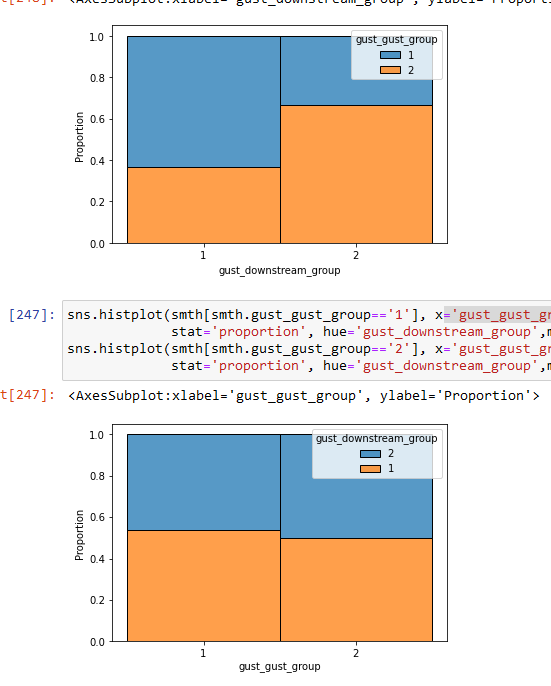

In [110]:
counter_cosine_similarity(Counter(lst1_dwn), Counter(lst1_gust))

0.38177085778546666

In [111]:
counter_cosine_similarity(Counter(lst1_dwn), Counter(lst2_gust))

0.5619514869490164

In [112]:
counter_cosine_similarity(Counter(lst2_dwn), Counter(lst1_gust))

0.44539933408304444

In [113]:
counter_cosine_similarity(Counter(lst2_dwn), Counter(lst2_gust))

0.5619514869490164

In [114]:
counter_cosine_similarity(Counter(lst1_dwn), Counter(lst2_dwn))

0.0